# Importing Modules

In [31]:
import warnings, re,math, datetime, time
start_time = time.time()
from datetime import timedelta
warnings.filterwarnings("ignore")
import math
import pandas as pd
import csv, io
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import nltk, string
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import geopandas as gpd
from geopy import geocoders
gn = geocoders.GeoNames(username = "idselection")
import shapely
from shapely.geometry import Point, LineString, Polygon

In [32]:
"""
from google.colab import files
uploaded = files.upload()
"""

'\nfrom google.colab import files\nuploaded = files.upload()\n'

# Loading Election Dataset

In [33]:
#df = pd.read_csv(io.BytesIO(uploaded['Elections2019.csv']))
df = pd.read_csv("Elections2019.csv")
df.head()

last_updated      tweet_id        created_at   user_location  \
0  06-03-2019 17:30  1.100000e+18  06-03-2019 03:33       Guwahati    
1  17-03-2019 18:11  1.110000e+18  17-03-2019 17:27             NaN   
2  23-03-2019 18:07  1.110000e+18  23-03-2019 11:28      New Delhi    
3  11-03-2019 17:47  1.100000e+18  26-02-2019 07:40             NaN   
4  27-02-2019 18:18  1.100000e+18  27-02-2019 12:21  Delhi | Odisha   

                                           full_text  quote_count  \
0  Guwahati has gained a lot of prominence in rec...          0.0   
1  RSS in school days itself? Indoctrinated since...          0.0   
2  Words don't exist in Vaccum!\nModi's post Pulw...          0.0   
3  India's #Icecream Industry stands at 15,000 cr...          0.0   
4  *40 CRPF Jawans killed in Pulwama Attack\n*IAF...          0.0   

   reply_count  retweet_count  favorite_count  hashtags  \
0          4.0          113.0             113   ActEast   
1          0.0            5.0               5       NaN   
2          4.0           31.0              31       NaN   
3          0.0            3.0               3  Icecream   
4          0.0            9.0               9       NaN   

  user_mentions_screen_name                         City  State  District  \
0              narendramodi                     Guwahati  Assam       NaN   
1                       NaN                          NaN    NaN       NaN   
2                       NaN  New Delhi Municipal Council  Delhi       NaN   
3                       NaN                          NaN    NaN       NaN   
4                       NaN                          NaN  Delhi       NaN   

  Country  
0   India  
1   India  
2   India  
3   India  
4   India

# Dimensions

In [34]:
df.shape

(46043, 15)

# Displaying columns with NaN

In [35]:
df.isnull().sum()

last_updated                     7
tweet_id                         2
created_at                       7
user_location                 5779
full_text                        2
quote_count                   1410
reply_count                   1410
retweet_count                   12
favorite_count                   0
hashtags                     36836
user_mentions_screen_name    28320
City                         30330
State                        28788
District                     46038
Country                      20700
dtype: int64

# Attribute Data Types

In [36]:
df.dtypes

last_updated                  object
tweet_id                     float64
created_at                    object
user_location                 object
full_text                     object
quote_count                  float64
reply_count                  float64
retweet_count                float64
favorite_count                 int64
hashtags                      object
user_mentions_screen_name     object
City                          object
State                         object
District                     float64
Country                       object
dtype: object

# Dropping unnecessary rows and columns

#### We drop user_location since they are redundant and aren't useful and district since 95% is NaN

In [37]:
df = df[pd.notnull(df['created_at'])]
df.dropna(subset=["full_text"], inplace = True)
df.drop("District", axis = 1, inplace =True)
df.drop("user_location", axis=1, inplace = True)
df.shape

(46036, 13)

# Removing US tweets

### The database also has US Congress tweets which must be removed

In [38]:
usa_terms = ["usa", "united states", "trump", "america", "democrat","cia", "fbi", "nsa"]
for i in range(0,46043):
    try:
        flag = True
        x = df.loc[i,"full_text"]
        #print(x)
        for j in usa_terms:
            if j in str(x).lower():
                flag = False
                break
        if flag==False:
            df = df.drop(i)
    except:
        pass
df = df[df["Country"] != "Others"]

In [39]:
df.shape

(39874, 13)

# Replacing NaN values

### All missing values are replaced with default twitter values

In [40]:
df["Country"].fillna("India", inplace=True)
df["retweet_count"].fillna(0, inplace=True)
df["quote_count"].fillna(0, inplace=True)
df["reply_count"].fillna(0, inplace=True)
df["favorite_count"].fillna(0, inplace=True)
df["State"].fillna("", inplace=True)
df["hashtags"].fillna("", inplace=True)
df["user_mentions_screen_name"].fillna("", inplace=True)
df["Country"]=df["Country"].replace("0","India") 
df["Country"]=df["Country"].replace("1","India")
df["Country"]=df["Country"].replace("2","India")
df["State"]=df["State"].replace("0","")
df["State"]=df["State"].replace("1","")
df["State"]=df["State"].replace("2","")
df["City"].fillna("", inplace=True) 

In [41]:
df.head()

last_updated      tweet_id        created_at  \
0  06-03-2019 17:30  1.100000e+18  06-03-2019 03:33   
1  17-03-2019 18:11  1.110000e+18  17-03-2019 17:27   
2  23-03-2019 18:07  1.110000e+18  23-03-2019 11:28   
3  11-03-2019 17:47  1.100000e+18  26-02-2019 07:40   
4  27-02-2019 18:18  1.100000e+18  27-02-2019 12:21   

                                           full_text  quote_count  \
0  Guwahati has gained a lot of prominence in rec...          0.0   
1  RSS in school days itself? Indoctrinated since...          0.0   
2  Words don't exist in Vaccum!\nModi's post Pulw...          0.0   
3  India's #Icecream Industry stands at 15,000 cr...          0.0   
4  *40 CRPF Jawans killed in Pulwama Attack\n*IAF...          0.0   

   reply_count  retweet_count  favorite_count  hashtags  \
0          4.0          113.0             113   ActEast   
1          0.0            5.0               5             
2          4.0           31.0              31             
3          0.0            3.0               3  Icecream   
4          0.0            9.0               9             

  user_mentions_screen_name                         City  State Country  
0              narendramodi                     Guwahati  Assam   India  
1                                                                 India  
2                            New Delhi Municipal Council  Delhi   India  
3                                                                 India  
4                                                         Delhi   India

# Fixing Dates

In [42]:
lastupdate, created = [], []
for i in df["last_updated"]:
    lastupdate.append(datetime.datetime.strptime(i, "%d-%m-%Y %H:%M"))
for i in df["created_at"]:
    created.append(datetime.datetime.strptime(i, "%d-%m-%Y %H:%M"))

In [43]:
df["created_at"] = created
df["last_updated"] = lastupdate
df.drop(df[df['last_updated'] > datetime.datetime(2019,5,23,0,0)].index, inplace = True) 
df.drop(df[df['created_at'] > datetime.datetime(2019,5,23,0,0)].index, inplace = True) 

In [44]:
df.head()

last_updated      tweet_id          created_at  \
0 2019-03-06 17:30:00  1.100000e+18 2019-03-06 03:33:00   
1 2019-03-17 18:11:00  1.110000e+18 2019-03-17 17:27:00   
2 2019-03-23 18:07:00  1.110000e+18 2019-03-23 11:28:00   
3 2019-03-11 17:47:00  1.100000e+18 2019-02-26 07:40:00   
4 2019-02-27 18:18:00  1.100000e+18 2019-02-27 12:21:00   

                                           full_text  quote_count  \
0  Guwahati has gained a lot of prominence in rec...          0.0   
1  RSS in school days itself? Indoctrinated since...          0.0   
2  Words don't exist in Vaccum!\nModi's post Pulw...          0.0   
3  India's #Icecream Industry stands at 15,000 cr...          0.0   
4  *40 CRPF Jawans killed in Pulwama Attack\n*IAF...          0.0   

   reply_count  retweet_count  favorite_count  hashtags  \
0          4.0          113.0             113   ActEast   
1          0.0            5.0               5             
2          4.0           31.0              31             
3          0.0            3.0               3  Icecream   
4          0.0            9.0               9             

  user_mentions_screen_name                         City  State Country  
0              narendramodi                     Guwahati  Assam   India  
1                                                                 India  
2                            New Delhi Municipal Council  Delhi   India  
3                                                                 India  
4                                                         Delhi   India

# Sorting Dataset by Dates

In [45]:
df = df.sort_values(by=['last_updated'])

In [46]:
df.head()

last_updated      tweet_id          created_at  \
13334 2019-02-08 17:29:00  1.090000e+18 2019-02-08 17:28:00   
9793  2019-02-08 17:29:00  1.090000e+18 2019-02-07 05:10:00   
32798 2019-02-08 17:30:00  1.090000e+18 2019-02-08 10:18:00   
34596 2019-02-08 17:30:00  1.090000e+18 2019-02-08 17:29:00   
28070 2019-02-08 17:30:00  1.090000e+18 2019-02-08 14:19:00   

                                               full_text  quote_count  \
13334  @DasComrade Sir any comment on modi's grand en...          0.0   
9793   Congress made Vemula national talking point ev...         47.0   
32798  BJP has been winning battles over the past mon...          1.0   
34596  @inclusivemind2 @Ark82876233 @BJP4India @Rahul...          0.0   
28070  Senior Congress leader @ManishTewari : There w...          0.0   

       reply_count  retweet_count  favorite_count hashtags  \
13334          0.0            1.0               1            
9793          72.0         2353.0            2353            
32798         12.0          513.0             513            
34596          0.0            2.0               2            
28070          1.0          159.0             159            

                              user_mentions_screen_name  \
13334                                        DasComrade   
9793                                                      
32798                                                     
34596  inclusivemind2,Ark82876233,BJP4India,RahulGandhi   
28070                                      ManishTewari   

                              City          State Country  
13334                     Guwahati          Assam   India  
9793                Greater Mumbai    Maharashtra   India  
32798                      Kolkata    West Bengal   India  
34596                      Aligarh  Uttar Pradesh   India  
28070  New Delhi Municipal Council          Delhi   India

# New Dimensions after dropping rows and columns

In [47]:
df.shape

(39874, 13)

# Showing NaN 

In [48]:
df.isnull().sum()

last_updated                 0
tweet_id                     0
created_at                   0
full_text                    0
quote_count                  0
reply_count                  0
retweet_count                0
favorite_count               0
hashtags                     0
user_mentions_screen_name    0
City                         0
State                        0
Country                      0
dtype: int64

# Mapping Cities and States

In [49]:
capitals = dict(zip(
    ['Delhi', 'Karnataka', 'Andhra Pradesh', 'Maharashtra',
       'Punjab', 'Uttar Pradesh', 'Gujarat', 'Pondicherry', 'Jharkhand',
       'Chandigarh', 'Madhya Pradesh', 'West Bengal', 'Assam',
       'Jammu & Kashmir', 'Bihar', 'Haryana', 'Tamil Nadu', 'Orissa',
       'Chhattisgarh', 'Rajasthan', 'Uttaranchal', 'Telangana',
       'Daman & Diu', 'Meghalaya', 'Tripura', 'Kerala', 'Goa',
       'Himachal Pradesh', 'Manipur', 'Arunachal Pradesh', 'Lakshadweep',
       'Andaman & Nicobar Islands', 'Mizoram', 'Nagaland', 'Sikkim'],
                    
    ['New Delhi','Bangalore','Hyderabad','Mumbai','Chandigarh','Lucknow', 'Gandhinagar', 'Pondicherry',"Ranchi","Chandigarh",
         "Bhopal", "Kolkata", "Dispur", "Srinagar", "Patna", "Chandigarh", "Chennai", "Bhubaneswar", "Raipur",
        "Jaipur", "Dehradun", "Hyderabad", "Daman", "Shillong", "Agartala", "Trivandrum", "Panaji", "Shimla",
        "Imphal", "Itanagar", "Kavaratti", "Port Blair", "Aizawl", "Kohima","Gangtok"]))

# Replacing NULL cities to state capitals

In [50]:
for i in range(0,46044):
    try:
        if df["City"][i]=='':
            df["City"][i] = capitals[df["State"][i]]
    except:
        pass
df.head()

last_updated      tweet_id          created_at  \
13334 2019-02-08 17:29:00  1.090000e+18 2019-02-08 17:28:00   
9793  2019-02-08 17:29:00  1.090000e+18 2019-02-07 05:10:00   
32798 2019-02-08 17:30:00  1.090000e+18 2019-02-08 10:18:00   
34596 2019-02-08 17:30:00  1.090000e+18 2019-02-08 17:29:00   
28070 2019-02-08 17:30:00  1.090000e+18 2019-02-08 14:19:00   

                                               full_text  quote_count  \
13334  @DasComrade Sir any comment on modi's grand en...          0.0   
9793   Congress made Vemula national talking point ev...         47.0   
32798  BJP has been winning battles over the past mon...          1.0   
34596  @inclusivemind2 @Ark82876233 @BJP4India @Rahul...          0.0   
28070  Senior Congress leader @ManishTewari : There w...          0.0   

       reply_count  retweet_count  favorite_count hashtags  \
13334          0.0            1.0               1            
9793          72.0         2353.0            2353            
32798         12.0          513.0             513            
34596          0.0            2.0               2            
28070          1.0          159.0             159            

                              user_mentions_screen_name  \
13334                                        DasComrade   
9793                                                      
32798                                                     
34596  inclusivemind2,Ark82876233,BJP4India,RahulGandhi   
28070                                      ManishTewari   

                              City          State Country  
13334                     Guwahati          Assam   India  
9793                Greater Mumbai    Maharashtra   India  
32798                      Kolkata    West Bengal   India  
34596                      Aligarh  Uttar Pradesh   India  
28070  New Delhi Municipal Council          Delhi   India

# Finding city name variations

In [51]:
d = {}
for i in df["City"]:
    #print("Checking for ",i)
    if i not in d:
        d[i]=set()
    for j in df["City"]:
        if(i in j and i!=''):
            d[i].add(j)
for i in d:
    if len(d[i])>1:
        print(i,d[i])

Hyderabad {'Hyderabad M.Corp', 'Hyderabad'}
New Delhi {'New Delhi Municipal Council', 'New Delhi'}
Mumbai {'Mumbai', 'Navi Mumbai', 'Greater Mumbai'}
Anand {'Anand Nagar', 'Anand'}
Rewa {'Rewa', 'Rewari'}
Nagar {'Jemari  (J.K. Nagar Township)', 'Nagar', 'S.A.S. Nagar (Mohali)', 'L.B. Nagar', 'Anand Nagar'}
Thane {'Thane', 'Thanesar', 'Kalambe Turf Thane'}
Ara {'Arani', 'Ara'}
Jodhpur {'Jam Jodhpur', 'Jodhpur'}
Bad {'Bad', 'Badgam'}
Bokaro {'Bokaro Steel City', 'Bokaro'}
Bagh {'Bagh', 'Baghpat'}
Durg {'Durgapur', 'Durg'}
Banga {'Bangalore', 'Banga'}
Udaipur {'Udaipur', 'Chhota Udaipur'}
Ambikapur {'Ambikapur Part-X', 'Ambikapur'}
Lakhimpur {'North Lakhimpur', 'Lakhimpur'}


# Modifying variations of city names

In [52]:
df["City"]=df["City"].replace("Navi Mumbai","Mumbai")
df["City"]=df["City"].replace("Greater Mumbai","Mumbai")
df["City"]=df["City"].replace("Bokaro Steel City","Bokaro")
df["City"]=df["City"].replace("L.B. Nagar","Hyderabad")
df["City"]=df["City"].replace("Delhi Cantt.","New Delhi")
df["City"]=df["City"].replace("New Delhi Municipal Council","New Delhi")
df["City"]=df["City"].replace("Hyderabad M.Corp", "Hyderabad")
df["City"]=df["City"].replace("Tambaur-cum-Ahmadabad", "Ahmedabad")
df["City"]=df["City"].replace("Ahmedabad Cantonment", "Ahmedabad")
df["City"]=df["City"].replace('S.A.S. Nagar (Mohali)', "Mohali")
df["City"]=df["City"].replace('Panchkula Urban Estate', "Panchkula")
df["City"]=df["City"].replace('Mirzapur-cum-Vindhyachal', "Mirzapur")
df["City"]=df["City"].replace('Jawaharnagar (Gujarat Refinery)', "Jawaharnagar")
df["City"]=df["City"].replace('Jemari  (J.K. Nagar Township)', "Jemari")
df["City"]=df["City"].replace('Jam Jodhpur', "Jodhpur")
df["City"]=df["City"].replace('Bodh Gaya', "Gaya")
df["City"]=df["City"].replace('Chamoli Gopeshwar', "Gopeshwar")
df["City"]=df["City"].replace('English Bazar', "Malda")
df["City"]=df["City"].replace('G.C.F Jabalpur', "Jabalpur")
df["City"]=df["City"].replace('Ambikapur Part-X', "Ambikapur")
df["City"]=df["City"].replace('Azhikode South', "Azikode")
df["City"]=df["City"].replace('Bhagalpur (M.Corp)', "Bhagalpur")
df["City"]=df["City"].replace('Bad', "Badgam")
df["City"]=df["City"].replace('Badgam', "Budgam")
df["City"]=df["City"].replace('Nagar', "Anand Nagar")
df["City"]=df["City"].replace('Kalambe Turf Thane', "Thane")
df["City"]=df["City"].replace('Anand', "Anand Nagar")
df["City"]=df["City"].replace('North Lakhimpur', "Lakhimpur")
df["City"]=df["City"].replace('Chhota Udaipur', "Udaipur")
df["City"]=df["City"].replace('Balod', "Baloda")
df["City"]=df["City"].replace('Chandrapur Bagicha', "Chandrapur")

# Looking for City and State mistmatches

In [53]:
set(df["City"]).intersection(set(df["State"]))

{'', 'Bihar', 'Chandigarh', 'Pondicherry'}

# Setting columns with city as Bihar to Patna

In [54]:
for i in range(1,46044):
    try:
        if df["City"][i] == "Bihar":
            if df["City"][i] == "" or df["City"][i] not in capitals:
                df["City"][i] = "Patna"
                df["State"][i] = "Bihar"
            else:
                df["City"][i] = capitals[df["State"][i]]
    except:
        pass

# Resetting index values

In [55]:
df = df.reset_index()
df.drop("index", axis=1, inplace = True)

# Final Cleaned Dataset

In [56]:
df

last_updated      tweet_id          created_at  \
0     2019-02-08 17:29:00  1.090000e+18 2019-02-08 17:28:00   
1     2019-02-08 17:29:00  1.090000e+18 2019-02-07 05:10:00   
2     2019-02-08 17:30:00  1.090000e+18 2019-02-08 10:18:00   
3     2019-02-08 17:30:00  1.090000e+18 2019-02-08 17:29:00   
4     2019-02-08 17:30:00  1.090000e+18 2019-02-08 14:19:00   
...                   ...           ...                 ...   
39869 2019-05-16 18:29:00  1.130000e+18 2019-05-16 14:55:00   
39870 2019-05-16 18:29:00  1.130000e+18 2019-05-15 13:15:00   
39871 2019-05-16 18:29:00  1.120000e+18 2019-04-26 14:10:00   
39872 2019-05-16 18:29:00  1.130000e+18 2019-05-16 14:17:00   
39873 2019-05-16 18:29:00  1.130000e+18 2019-05-16 09:41:00   

                                               full_text  quote_count  \
0      @DasComrade Sir any comment on modi's grand en...          0.0   
1      Congress made Vemula national talking point ev...         47.0   
2      BJP has been winning battles over the past mon...          1.0   
3      @inclusivemind2 @Ark82876233 @BJP4India @Rahul...          0.0   
4      Senior Congress leader @ManishTewari : There w...          0.0   
...                                                  ...          ...   
39869  A web page dedicated to tracking Rahul Gandhi'...          0.0   
39870  Itâ€™s time to end the forever wars. But in th...        156.0   
39871  The only phone number you need to reach any re...          0.0   
39872  Bjp officer bearer, faked Assangeâ€™s endorsem...          7.0   
39873  This is the real reason that Modi-Shah duo hav...         50.0   

       reply_count  retweet_count  favorite_count hashtags  \
0              0.0            1.0               1            
1             72.0         2353.0            2353            
2             12.0          513.0             513            
3              0.0            2.0               2            
4              1.0          159.0             159            
...            ...            ...             ...      ...   
39869          1.0           18.0              18            
39870        318.0        16017.0           16017            
39871          0.0           99.0              99            
39872         30.0          463.0             463            
39873        192.0          340.0             340            

                              user_mentions_screen_name       City  \
0                                            DasComrade   Guwahati   
1                                                           Mumbai   
2                                                          Kolkata   
3      inclusivemind2,Ark82876233,BJP4India,RahulGandhi    Aligarh   
4                                          ManishTewari  New Delhi   
...                                                 ...        ...   
39869                                                                
39870                                                                
39871                                                                
39872                                          PMOIndia  New Delhi   
39873                                        IndiaToday              

               State Country  
0              Assam   India  
1        Maharashtra   India  
2        West Bengal   India  
3      Uttar Pradesh   India  
4              Delhi   India  
...              ...     ...  
39869                  India  
39870                  India  
39871                  India  
39872          Delhi   India  
39873                  India  

[39874 rows x 13 columns]

# Final Dimensions

In [57]:
df.shape

(39874, 13)

# Inititalising Vectorizer, Sentiment Analyser and Stemmer

In [58]:
import nltk
"""nltk.download("vader_lexicon")
nltk.download("stopwords")"""
stemmer = SnowballStemmer('english')
vectorizer = TfidfVectorizer(use_idf = True, tokenizer = nltk.word_tokenize,stop_words='english', smooth_idf = True)
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
sid = SentimentIntensityAnalyzer()
stopw = set(stopwords.words('english'))

# Text Preprocessing Unit

In [59]:
contraction = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have", "bharatiya janata party" : "bjp",
                   "inc" : "congress","@narendramodi":"modi", "pappu":"rahul gandhi","gandhi":"rahul gandhi", "@rahulgandhi":"Rahul Gandhi"}

def clean(text):
    text = text.lower()
    temp = ""
    for i in text.split():
        if i not in stopw:
            try:
                temp+=contraction[i]+' '
            except:
                temp+= i+' '
    text = temp.strip()
    text = re.sub(r'http\S+','', text)
    text = text.lower().translate(remove_punctuation_map)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.replace("bhartiya janata party",'bjp')
    text = text.replace("indian national congress", 'congress')
    text = text.replace("aam aadmi party", 'aap')
    text = text.replace("narendra modi", 'modi')
    text = text.replace("rahulgandhi", 'rahul gandhi')
    temp=''
    for i in text:
        if i.isdigit()==False:
            temp+=i
    text = temp
    text = text.split()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text.strip()

# Cosine Similarity Function

In [60]:
'''def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1.strip(), text2.strip()])
    return ((tfidf * tfidfT.).A)[0,1]'''

'def cosine_sim(text1, text2):\n    tfidf = vectorizer.fit_transform([text1.strip(), text2.strip()])\n    return ((tfidf * tfidfT.).A)[0,1]'

# Preprocessing Tweets

In [61]:
preprocessed = []
for i in df["full_text"]:
    preprocessed.append(clean(i.strip().lower()))
preprocessed

['dascomrad sir comment modi grand entri',
 'congress made vemula nation talk point even though doubt case amp vemula dalit itself stop bjp make ramalingam case attain nation scale amp chang dalit discours take one remark pm modi make happen',
 'bjp win battl past month bengal pm modi arriv win biggest battl announc warcri upcom war tmc elect modisonarbangla',
 'inclusivemind ark bjpindia rahul gandhi bjp think cellchatumediacroniesscrit writer andbhakt crore speach give victori then late atal bihari vajpeyi much better shine india',
 'senior congress leader manishtewari jpc definit next parliament parallel crimin investig process go go away rafal rafalenot',
 'bc congress take kickback fr pp',
 'rahulliecaught exclus former defenc secretari g mohan kumar tear rahul gandhi lie say no pmo interfer rafal price',
 'expect meltdown congress elect wait till februari end bahut saar possibl hain ji',
 'stori realli expos develop propaganda nation congress cudnt yrs modi sirji ask month abl he

# Inserting Processed Tweets

In [62]:
df.insert(4,"processed_tweet",preprocessed,True)
df.head()

last_updated      tweet_id          created_at  \
0 2019-02-08 17:29:00  1.090000e+18 2019-02-08 17:28:00   
1 2019-02-08 17:29:00  1.090000e+18 2019-02-07 05:10:00   
2 2019-02-08 17:30:00  1.090000e+18 2019-02-08 10:18:00   
3 2019-02-08 17:30:00  1.090000e+18 2019-02-08 17:29:00   
4 2019-02-08 17:30:00  1.090000e+18 2019-02-08 14:19:00   

                                           full_text  \
0  @DasComrade Sir any comment on modi's grand en...   
1  Congress made Vemula national talking point ev...   
2  BJP has been winning battles over the past mon...   
3  @inclusivemind2 @Ark82876233 @BJP4India @Rahul...   
4  Senior Congress leader @ManishTewari : There w...   

                                     processed_tweet  quote_count  \
0             dascomrad sir comment modi grand entri          0.0   
1  congress made vemula nation talk point even th...         47.0   
2  bjp win battl past month bengal pm modi arriv ...          1.0   
3  inclusivemind ark bjpindia rahul gandhi bjp th...          0.0   
4  senior congress leader manishtewari jpc defini...          0.0   

   reply_count  retweet_count  favorite_count hashtags  \
0          0.0            1.0               1            
1         72.0         2353.0            2353            
2         12.0          513.0             513            
3          0.0            2.0               2            
4          1.0          159.0             159            

                          user_mentions_screen_name       City          State  \
0                                        DasComrade   Guwahati          Assam   
1                                                       Mumbai    Maharashtra   
2                                                      Kolkata    West Bengal   
3  inclusivemind2,Ark82876233,BJP4India,RahulGandhi    Aligarh  Uttar Pradesh   
4                                      ManishTewari  New Delhi          Delhi   

  Country  
0   India  
1   India  
2   India  
3   India  
4   India

# Finding most tagged twitter handles

In [63]:
df["user_mentions_screen_name"].value_counts()[:9]

                  25080
narendramodi       1377
RahulGandhi         693
INCIndia            399
BJP4India           143
ANI                 110
priyankagandhi       99
AmitShah             98
ArvindKejriwal       97
Name: user_mentions_screen_name, dtype: int64

# Processing Sentiment Scores

In [64]:
sentiment = {"Positive":[], "Negative" :[], "Neutral":[], "Compound":[]}
for i in df["processed_tweet"]:
    sentiment["Positive"].append(sid.polarity_scores(i)['pos'])
    sentiment["Negative"].append(sid.polarity_scores(i)['neg'])
    sentiment["Neutral"].append(sid.polarity_scores(i)['neu'])
    sentiment["Compound"].append(sid.polarity_scores(i)['compound'])

In [65]:
df.insert(9,"Neutral",sentiment['Neutral'],True)
df.insert(10,"Positive",sentiment['Positive'],True)
df.insert(11,"Negative",sentiment['Negative'],True)
df.insert(12,"Compound",sentiment['Compound'],True)

In [66]:
df.head()

last_updated      tweet_id          created_at  \
0 2019-02-08 17:29:00  1.090000e+18 2019-02-08 17:28:00   
1 2019-02-08 17:29:00  1.090000e+18 2019-02-07 05:10:00   
2 2019-02-08 17:30:00  1.090000e+18 2019-02-08 10:18:00   
3 2019-02-08 17:30:00  1.090000e+18 2019-02-08 17:29:00   
4 2019-02-08 17:30:00  1.090000e+18 2019-02-08 14:19:00   

                                           full_text  \
0  @DasComrade Sir any comment on modi's grand en...   
1  Congress made Vemula national talking point ev...   
2  BJP has been winning battles over the past mon...   
3  @inclusivemind2 @Ark82876233 @BJP4India @Rahul...   
4  Senior Congress leader @ManishTewari : There w...   

                                     processed_tweet  quote_count  \
0             dascomrad sir comment modi grand entri          0.0   
1  congress made vemula nation talk point even th...         47.0   
2  bjp win battl past month bengal pm modi arriv ...          1.0   
3  inclusivemind ark bjpindia rahul gandhi bjp th...          0.0   
4  senior congress leader manishtewari jpc defini...          0.0   

   reply_count  retweet_count  favorite_count  Neutral  Positive  Negative  \
0          0.0            1.0               1    0.625     0.375     0.000   
1         72.0         2353.0            2353    0.868     0.000     0.132   
2         12.0          513.0             513    0.582     0.276     0.142   
3          0.0            2.0               2    0.884     0.116     0.000   
4          1.0          159.0             159    1.000     0.000     0.000   

   Compound hashtags                         user_mentions_screen_name  \
0    0.4588                                                 DasComrade   
1   -0.5719                                                              
2    0.5719                                                              
3    0.4404           inclusivemind2,Ark82876233,BJP4India,RahulGandhi   
4    0.0000                                               ManishTewari   

        City          State Country  
0   Guwahati          Assam   India  
1     Mumbai    Maharashtra   India  
2    Kolkata    West Bengal   India  
3    Aligarh  Uttar Pradesh   India  
4  New Delhi          Delhi   India

# Summarising RT's, Quotes and Replies

In [67]:
df.loc[:,"quote_count":"retweet_count"].describe()

quote_count   reply_count  retweet_count
count  39874.000000  39874.000000   39874.000000
mean      10.774038     32.574284     446.036615
std      114.089735    309.171354    2708.395701
min        0.000000      0.000000       0.000000
25%        0.000000      0.000000       2.000000
50%        0.000000      1.000000      18.000000
75%        2.000000      7.000000     135.000000
max    13544.000000  19447.000000  206958.000000

# Analysing Tweet Importance

In [68]:
imp = []
for i in range(0,39874):
    if df["retweet_count"][i]>=70 or sum([df["retweet_count"][i],df["quote_count"][i],df["reply_count"][i]])>=50:
        imp.append(1)
    else:
        imp.append(0)

In [69]:
df.insert(8,"Importance",imp,True)
df.head()

last_updated      tweet_id          created_at  \
0 2019-02-08 17:29:00  1.090000e+18 2019-02-08 17:28:00   
1 2019-02-08 17:29:00  1.090000e+18 2019-02-07 05:10:00   
2 2019-02-08 17:30:00  1.090000e+18 2019-02-08 10:18:00   
3 2019-02-08 17:30:00  1.090000e+18 2019-02-08 17:29:00   
4 2019-02-08 17:30:00  1.090000e+18 2019-02-08 14:19:00   

                                           full_text  \
0  @DasComrade Sir any comment on modi's grand en...   
1  Congress made Vemula national talking point ev...   
2  BJP has been winning battles over the past mon...   
3  @inclusivemind2 @Ark82876233 @BJP4India @Rahul...   
4  Senior Congress leader @ManishTewari : There w...   

                                     processed_tweet  quote_count  \
0             dascomrad sir comment modi grand entri          0.0   
1  congress made vemula nation talk point even th...         47.0   
2  bjp win battl past month bengal pm modi arriv ...          1.0   
3  inclusivemind ark bjpindia rahul gandhi bjp th...          0.0   
4  senior congress leader manishtewari jpc defini...          0.0   

   reply_count  retweet_count  Importance  favorite_count  Neutral  Positive  \
0          0.0            1.0           0               1    0.625     0.375   
1         72.0         2353.0           1            2353    0.868     0.000   
2         12.0          513.0           1             513    0.582     0.276   
3          0.0            2.0           0               2    0.884     0.116   
4          1.0          159.0           1             159    1.000     0.000   

   Negative  Compound hashtags  \
0     0.000    0.4588            
1     0.132   -0.5719            
2     0.142    0.5719            
3     0.000    0.4404            
4     0.000    0.0000            

                          user_mentions_screen_name       City          State  \
0                                        DasComrade   Guwahati          Assam   
1                                                       Mumbai    Maharashtra   
2                                                      Kolkata    West Bengal   
3  inclusivemind2,Ark82876233,BJP4India,RahulGandhi    Aligarh  Uttar Pradesh   
4                                      ManishTewari  New Delhi          Delhi   

  Country  
0   India  
1   India  
2   India  
3   India  
4   India

In [70]:
df["Importance"].value_counts()

0    24544
1    15330
Name: Importance, dtype: int64

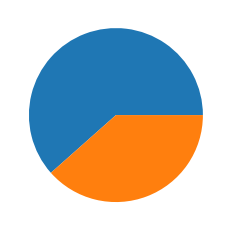

In [71]:
plt.pie(df["Importance"].value_counts())
plt.show()

# Correlating Tweet Attributes

In [72]:
dfcorr = df.corr(method="pearson")

In [73]:
dfcorr

tweet_id  quote_count  reply_count  retweet_count  Importance  \
tweet_id        1.000000    -0.041689    -0.020012      -0.022955   -0.005577   
quote_count    -0.041689     1.000000     0.800002       0.622179    0.116798   
reply_count    -0.020012     0.800002     1.000000       0.719914    0.130431   
retweet_count  -0.022955     0.622179     0.719914       1.000000    0.204256   
Importance     -0.005577     0.116798     0.130431       0.204256    1.000000   
favorite_count -0.022955     0.622179     0.719914       1.000000    0.204256   
Neutral         0.005210    -0.014657    -0.015987      -0.019757   -0.014811   
Positive       -0.000297     0.003821     0.005671       0.022822    0.007710   
Negative       -0.006349     0.014949     0.014840       0.002982    0.011366   
Compound        0.002504    -0.010084    -0.009755       0.011925   -0.001475   

                favorite_count   Neutral  Positive  Negative  Compound  
tweet_id             -0.022955  0.005210 -0.000297 -0.006349  0.002504  
quote_count           0.622179 -0.014657  0.003821  0.014949 -0.010084  
reply_count           0.719914 -0.015987  0.005671  0.014840 -0.009755  
retweet_count         1.000000 -0.019757  0.022822  0.002982  0.011925  
Importance            0.204256 -0.014811  0.007710  0.011366 -0.001475  
favorite_count        1.000000 -0.019757  0.022822  0.002982  0.011925  
Neutral              -0.019757  1.000000 -0.632498 -0.658254  0.062636  
Positive              0.022822 -0.632498  1.000000 -0.166741  0.671093  
Negative              0.002982 -0.658254 -0.166741  1.000000 -0.731972  
Compound              0.011925  0.062636  0.671093 -0.731972  1.000000

# Setting up Scoring Function

In [74]:
m11 = dfcorr["Compound"]["quote_count"]
m22 = dfcorr["Compound"]["reply_count"]
m33 = dfcorr["Compound"]["retweet_count"]
m44 = dfcorr["Compound"]["favorite_count"]
m55 = dfcorr["Compound"]["Importance"]

#Positive or compound?

m1 = dfcorr["Positive"]["quote_count"]
m2 = dfcorr["Positive"]["reply_count"]
m3 = dfcorr["Positive"]["retweet_count"]
m4 = dfcorr["Positive"]["favorite_count"]
m5 = dfcorr["Positive"]["Importance"]

In [75]:
score = lambda x1,x2,x3,x4,x5: m1*x1+m2*x2+m3*x3+m4*x4+x5
#score1 = lambda x1,x2,x3,x4,x5: m11*x1+m22*x2+m33*x3+m44*x4+x5

In [76]:
#Random test case
score(10,20,30,10,0)

1.064519682388548

In [77]:
score(10,20,30,10,1) 

2.064519682388548

# Scoring Tweets

In [78]:
scores = []
for i in range(0,39874):
    qt = df["quote_count"][i]
    reply = df["reply_count"][i]
    rt = df["retweet_count"][i]
    fav = df["favorite_count"][i]
    imp = df["Importance"][i]
    scores.append(score(qt,reply,rt,fav,imp))

In [79]:
df["Score"] = scores

In [80]:
df.head()

last_updated      tweet_id          created_at  \
0 2019-02-08 17:29:00  1.090000e+18 2019-02-08 17:28:00   
1 2019-02-08 17:29:00  1.090000e+18 2019-02-07 05:10:00   
2 2019-02-08 17:30:00  1.090000e+18 2019-02-08 10:18:00   
3 2019-02-08 17:30:00  1.090000e+18 2019-02-08 17:29:00   
4 2019-02-08 17:30:00  1.090000e+18 2019-02-08 14:19:00   

                                           full_text  \
0  @DasComrade Sir any comment on modi's grand en...   
1  Congress made Vemula national talking point ev...   
2  BJP has been winning battles over the past mon...   
3  @inclusivemind2 @Ark82876233 @BJP4India @Rahul...   
4  Senior Congress leader @ManishTewari : There w...   

                                     processed_tweet  quote_count  \
0             dascomrad sir comment modi grand entri          0.0   
1  congress made vemula nation talk point even th...         47.0   
2  bjp win battl past month bengal pm modi arriv ...          1.0   
3  inclusivemind ark bjpindia rahul gandhi bjp th...          0.0   
4  senior congress leader manishtewari jpc defini...          0.0   

   reply_count  retweet_count  Importance  favorite_count  Neutral  Positive  \
0          0.0            1.0           0               1    0.625     0.375   
1         72.0         2353.0           1            2353    0.868     0.000   
2         12.0          513.0           1             513    0.582     0.276   
3          0.0            2.0           0               2    0.884     0.116   
4          1.0          159.0           1             159    1.000     0.000   

   Negative  Compound hashtags  \
0     0.000    0.4588            
1     0.132   -0.5719            
2     0.142    0.5719            
3     0.000    0.4404            
4     0.000    0.0000            

                          user_mentions_screen_name       City          State  \
0                                        DasComrade   Guwahati          Assam   
1                                                       Mumbai    Maharashtra   
2                                                      Kolkata    West Bengal   
3  inclusivemind2,Ark82876233,BJP4India,RahulGandhi    Aligarh  Uttar Pradesh   
4                                      ManishTewari  New Delhi          Delhi   

  Country       Score  
0   India    0.045645  
1   India  108.990410  
2   India   24.487725  
3   India    0.091290  
4   India    8.263217

# Classifying Tweets - Testing K-Means

In [81]:
'''X = vectorizer.fit_transform(df["processed_tweet"])
k =3
model = KMeans(n_clusters=2, init='k-means++', max_iter=100)
model.fit(X)'''

'X = vectorizer.fit_transform(df["processed_tweet"])\nk =3\nmodel = KMeans(n_clusters=2, init=\'k-means++\', max_iter=100)\nmodel.fit(X)'

In [82]:
'''order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print'''

'order_centroids = model.cluster_centers_.argsort()[:, ::-1]\nterms = vectorizer.get_feature_names()\nfor i in range(2):\n    print("Cluster %d:" % i),\n    for ind in order_centroids[i, :10]:\n        print(\' %s\' % terms[ind]),\n    print'

In [83]:
#Y = vectorizer.transform(['''A multitude of supporters from across the length and breath of Bihar came out to listen to Congress President Shri @RahulGandhi today. #RahulGandhiInBihar https://t.co/f0O9RfxAeM'''])
#prediction = model.predict(Y)
#print(prediction)'''

# Testing Cosine Similarity

In [84]:
'''compare = ["bjp modi chowkidar rss",
          "congress rahul gandhi sonia pappu"]
party1 = []
for tweet in df["processed_tweet"]:
    sim = []
    sim.append([cosine_sim(compare[0],tweet),"BJP"])
    sim.append([cosine_sim(compare[1],tweet),"Congress"])
    sim.sort(key = lambda x: x[0],reverse = True)
    max_sim = sim[0][0]
    max_party = sim[0][1]
    if max_sim>0.2:
        party1.append(max_party)
    else:
        party1.append("Other")'''

'compare = ["bjp modi chowkidar rss",\n          "congress rahul gandhi sonia pappu"]\nparty1 = []\nfor tweet in df["processed_tweet"]:\n    sim = []\n    sim.append([cosine_sim(compare[0],tweet),"BJP"])\n    sim.append([cosine_sim(compare[1],tweet),"Congress"])\n    sim.sort(key = lambda x: x[0],reverse = True)\n    max_sim = sim[0][0]\n    max_party = sim[0][1]\n    if max_sim>0.2:\n        party1.append(max_party)\n    else:\n        party1.append("Other")'

# Testing Frequency Classification

In [85]:
compare = ["vijay rajnath ravishankar  yudhvirsethi patra narendra modi vijayvargiyah sadhvi bjp arun manoj reddy sushma rsprasad taneja maneka udhavthackeray gautam gambhir piyush goyal nitin gadkari gadkariji rss singh vasundhraraje bjpbengal smriti kailash gautamgambhir swamy udhav sushmaswaraj sadhvi pragya vasundhra sambitpatra shivraj arunjaitley manohar parikar subramanianswamy naredra modi manojtiwari amit modiji yogi adityanath sushma swaraj nitin vivekreddy shivrajsinghchouhan vijayrupani amit shah narendramodi pragya arun jaitley thackeray sunny deol bharatiya janata party kailashvijayvargiyah adityanath yogi jaitley piyush gadkari sambit smritiirani rajnathsingh irani swaraj gautam parikar nirmala bhartiya janta party ram nirmala sitaraman modi shivrajsingh nititngadkari manohar rammadhav smriti irani yedyurappa madhav gambhir narendra rajnath singh subrmanian goyal chouhan amitshah sitaraman manoharparikar ravishankar prasad rupani rao shah ravishankarprasad narsimha vivek vijay rupani prasad bhartiya janata party giriraj chowkidar",
          "congress rahul gandhi sonia pappu manish tiwari mani shankar aiyar amrinder singh navjot sidhu pilot sachin jyotiraditya scindia ashok gehlot ajay makhan makhen chidambaram raj babbar sheila dikshit kamal nath digvijay singh sanjay kaul ashok chavan prithviraj randeep surjaewala hooda deepender kapil sibal manmohan ahmed patil natwar gaurav vallabh pawan khera taneja reddy george antony venugopal rao raman gogoi lalu prasad yadav akhilesh ravat urmila milind deora siddaramiah shivkumar dks sandeep ashok tanwar prakash jha"]
documents = df["processed_tweet"]
party = []
for i in documents:
    l = len(i.split())
    freq_bjp = 0
    freq_cong = 0
    for j in compare[0].split():
        freq_bjp+=i.count(j.strip())
    for j in compare[1].split():
        freq_cong+=i.count(j.strip())
    #print(freq_cong, freq_bjp)
    if freq_bjp>freq_cong:
        party.append("BJP")
    elif freq_cong>freq_bjp:
        party.append("Congress")
    else:
        party.append("Other")

# Checking Party Counts

In [86]:
party.count("Other")

3649

In [87]:
party.count("BJP")


22234

In [88]:
party.count("Congress")

13991

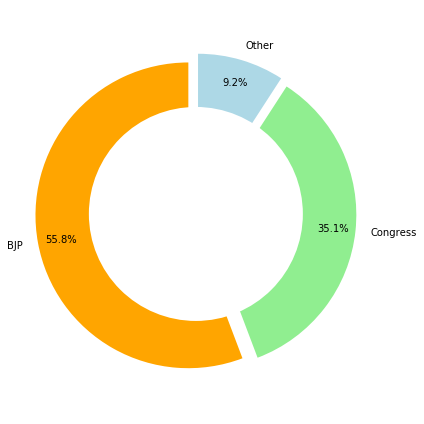

In [89]:
plt.rcParams["figure.figsize"] = [6,6]
labels = ["BJP","Congress","Other"]
count = [party.count("BJP"),party.count("Congress"),party.count("Other")]
explode = (0.05,0.05,0.05)
patches, texts,autotexts = plt.pie(count,labels=labels, explode = explode,colors = ["orange","lightgreen","lightblue"], startangle=90, autopct='%1.1f%%',shadow = False, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

# Inserting Party Attribute

In [90]:
df.insert(5,"Party",party)

In [91]:
df.head()

last_updated      tweet_id          created_at  \
0 2019-02-08 17:29:00  1.090000e+18 2019-02-08 17:28:00   
1 2019-02-08 17:29:00  1.090000e+18 2019-02-07 05:10:00   
2 2019-02-08 17:30:00  1.090000e+18 2019-02-08 10:18:00   
3 2019-02-08 17:30:00  1.090000e+18 2019-02-08 17:29:00   
4 2019-02-08 17:30:00  1.090000e+18 2019-02-08 14:19:00   

                                           full_text  \
0  @DasComrade Sir any comment on modi's grand en...   
1  Congress made Vemula national talking point ev...   
2  BJP has been winning battles over the past mon...   
3  @inclusivemind2 @Ark82876233 @BJP4India @Rahul...   
4  Senior Congress leader @ManishTewari : There w...   

                                     processed_tweet     Party  quote_count  \
0             dascomrad sir comment modi grand entri       BJP          0.0   
1  congress made vemula nation talk point even th...       BJP         47.0   
2  bjp win battl past month bengal pm modi arriv ...       BJP          1.0   
3  inclusivemind ark bjpindia rahul gandhi bjp th...     Other          0.0   
4  senior congress leader manishtewari jpc defini...  Congress          0.0   

   reply_count  retweet_count  Importance  ...  Neutral  Positive  Negative  \
0          0.0            1.0           0  ...    0.625     0.375     0.000   
1         72.0         2353.0           1  ...    0.868     0.000     0.132   
2         12.0          513.0           1  ...    0.582     0.276     0.142   
3          0.0            2.0           0  ...    0.884     0.116     0.000   
4          1.0          159.0           1  ...    1.000     0.000     0.000   

   Compound  hashtags                         user_mentions_screen_name  \
0    0.4588                                                  DasComrade   
1   -0.5719                                                               
2    0.5719                                                               
3    0.4404            inclusivemind2,Ark82876233,BJP4India,RahulGandhi   
4    0.0000                                                ManishTewari   

        City          State Country       Score  
0   Guwahati          Assam   India    0.045645  
1     Mumbai    Maharashtra   India  108.990410  
2    Kolkata    West Bengal   India   24.487725  
3    Aligarh  Uttar Pradesh   India    0.091290  
4  New Delhi          Delhi   India    8.263217  

[5 rows x 21 columns]

In [92]:
df["Party"].value_counts()

BJP         22234
Congress    13991
Other        3649
Name: Party, dtype: int64

# Obtaining Time Intervals

In [93]:
time_sec = list(set(df["last_updated"]))
time_sec.sort()

In [94]:
time_day = set()
time_month = set()
for i in time_sec:
    time_day.add(i.date())
    time_month.add(i.month)
time_day = list(time_day)
time_day.sort()
time_month = list(time_month)
time_month.sort()

In [95]:
time_week = set()
time_fortnight = set()
result=time_day[0]
while result<= time_day[-1]:
    time_week.add(result)
    result+=timedelta(days=7)
time_week = list(time_week)
time_week.sort()

In [96]:
result = time_day[0]
while result<= time_day[-1]:
    time_fortnight.add(result)
    result+=timedelta(days=15)
time_fortnight = list(time_fortnight)
time_fortnight.sort()

In [97]:
all_hour = []
result = time_sec[0]
while result<= time_sec[-1]:
    all_hour.append((result.date(),result.hour))
    result+=timedelta(hours=1)

In [98]:
all_min = []
result = time_sec[0]
while result<= time_sec[-1]:
    all_min.append((result.date(),result.hour,result.minute))
    result+=timedelta(minutes=1)

# Popularity per Tweet

In [99]:
score_sec = {}
for t in time_sec:
    score_sec[t] = {"BJP":0,"Congress":0,"Other":0}
for i in range(0,39874):
    t = df["last_updated"][i]
    score_sec[t][df["Party"][i]]+=df["Compound"][i]
#print(score_min)

In [100]:
sec_total_bjp, sec_total_cong, sec_total_other = [],[],[]
for i in score_sec:
    try:
        sec_total_bjp.append(score_sec[i]["BJP"]+sec_total_bjp[-1])
    except IndexError:
        sec_total_bjp.append(score_sec[i]["BJP"]+0)

for i in score_sec:
    try:
        sec_total_cong.append(score_sec[i]["Congress"]+sec_total_cong[-1])
    except IndexError:
        sec_total_cong.append(score_sec[i]["Congress"]+0)

for i in score_sec:
    try:
        sec_total_other.append(score_sec[i]["Other"]+sec_total_other[-1])
    except IndexError:
        sec_total_other.append(score_sec[i]["Other"]+0)

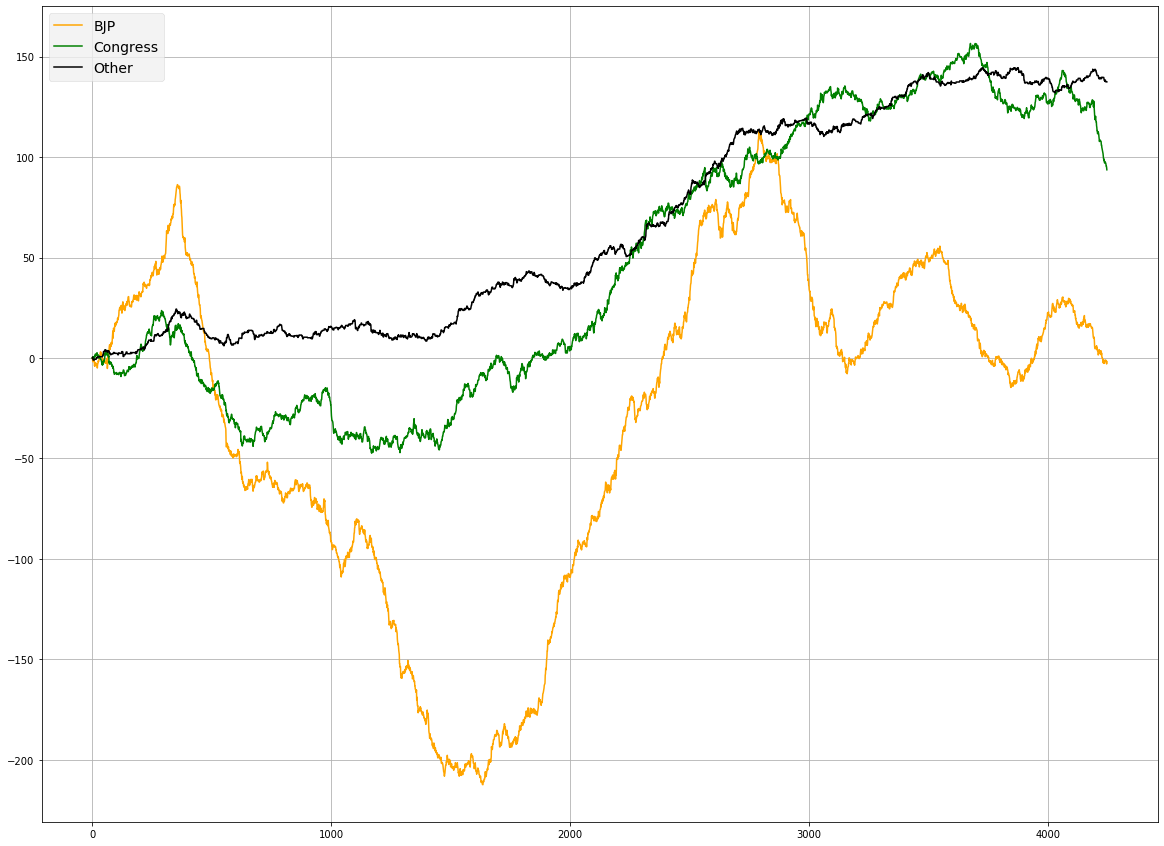

In [101]:
plt.rcParams["figure.figsize"] = [20,15]
plt.figure(num ='Lok Sabha')
plt.plot([i  for i in range(0,4248)],sec_total_bjp,label = 'BJP',color = 'orange')
plt.plot([i  for i in range(0,4248)],sec_total_cong,label = 'Congress',color = 'green')
plt.plot([i  for i in range(0,4248)],sec_total_other,label = 'Other',color = 'black')
plt.style.use('fivethirtyeight')
ax = plt.gca()
plt.grid(True)
plt.legend()
plt.show()
plt.close()

# Popularity per minute

In [102]:
score_min = {}
for t in all_min:
    score_min[t] = {"BJP":0,"Congress":0,"Other":0}
for i in range(0,39874):
    t = df["last_updated"][i]
    score_min[(t.date(),t.hour,t.minute)][df["Party"][i]]+=df["Compound"][i]

In [103]:
min_total_bjp, min_total_cong, min_total_other = [],[],[]
for i in score_min:
    try:
        min_total_bjp.append(score_min[i]["BJP"]+min_total_bjp[-1])
    except IndexError:
        min_total_bjp.append(score_min[i]["BJP"]+0)

for i in score_min:
    try:
        min_total_cong.append(score_min[i]["Congress"]+min_total_cong[-1])
    except IndexError:
        min_total_cong.append(score_min[i]["Congress"]+0)

for i in score_min:
    try:
        min_total_other.append(score_min[i]["Other"]+min_total_other[-1])
    except IndexError:
        min_total_other.append(score_min[i]["Other"]+0)

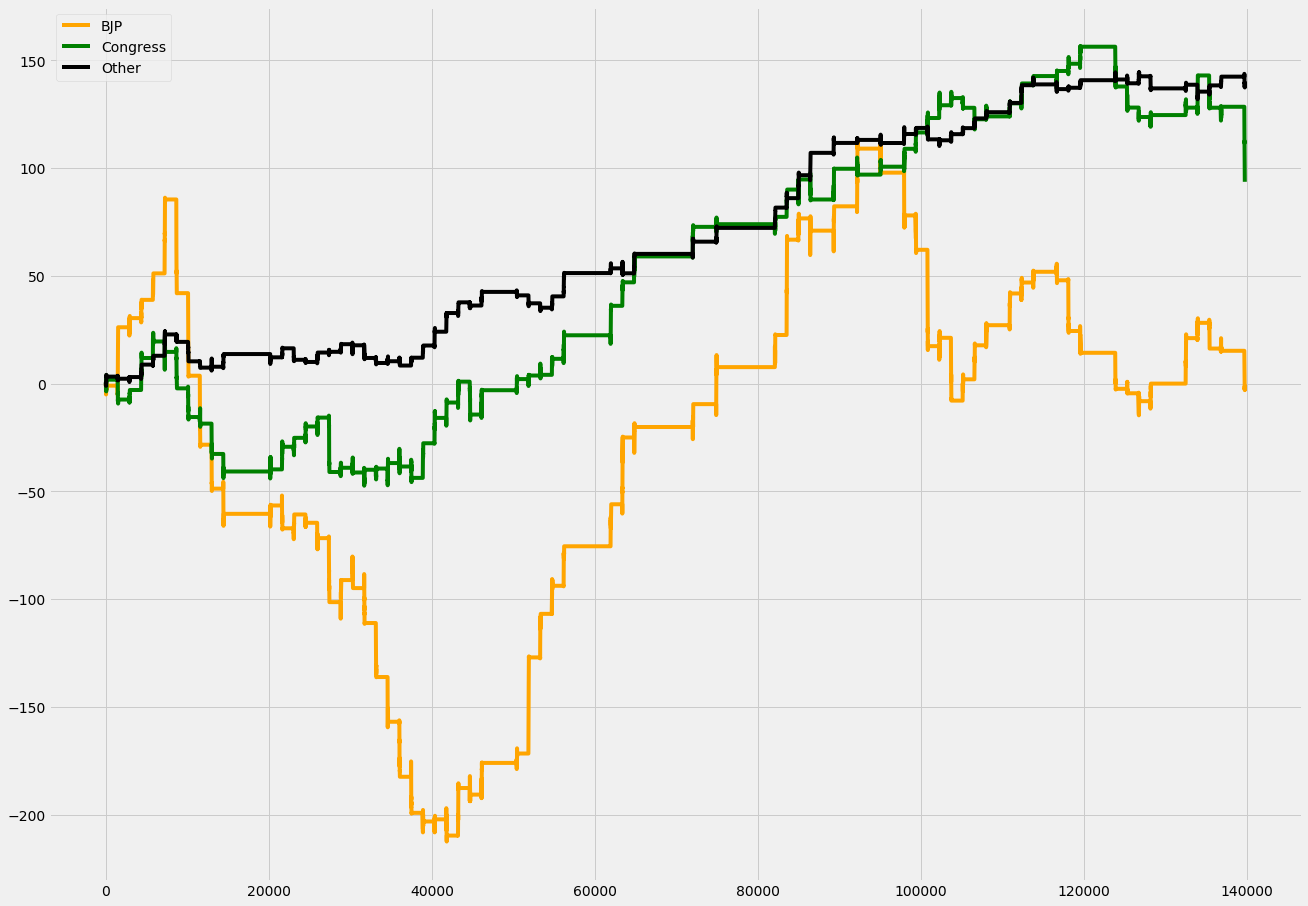

In [104]:
plt.rcParams["figure.figsize"] = [20,15]
plt.figure(num ='Lok Sabha')
plt.plot([i  for i in range(0,139741)],min_total_bjp,label = 'BJP',color = 'orange')
plt.plot([i  for i in range(0,139741)],min_total_cong,label = 'Congress',color = 'green')
plt.plot([i  for i in range(0,139741)],min_total_other,label = 'Other',color = 'black')
plt.style.use('fivethirtyeight')
ax = plt.gca()
plt.grid(True)
plt.legend()
plt.show()
plt.close()

# Popularity per hour

In [105]:
score_hour = {}
for t in all_hour:
    score_hour[t] = {"BJP":0,"Congress":0,"Other":0}
for i in range(0,39874):
    t = df["last_updated"][i]
    score_hour[(t.date(),t.hour)][df["Party"][i]]+=df["Compound"][i]

In [106]:
hour_total_bjp, hour_total_cong, hour_total_other = [],[],[]
for i in score_hour:
    try:
        hour_total_bjp.append(score_hour[i]["BJP"]+hour_total_bjp[-1])
    except IndexError:
        hour_total_bjp.append(score_hour[i]["BJP"]+0)

for i in score_hour:
    try:
        hour_total_cong.append(score_hour[i]["Congress"]+hour_total_cong[-1])
    except IndexError:
        hour_total_cong.append(score_hour[i]["Congress"]+0)

for i in score_hour:
    try:
        hour_total_other.append(score_hour[i]["Other"]+hour_total_other[-1])
    except IndexError:
        hour_total_other.append(score_hour[i]["Other"]+0)

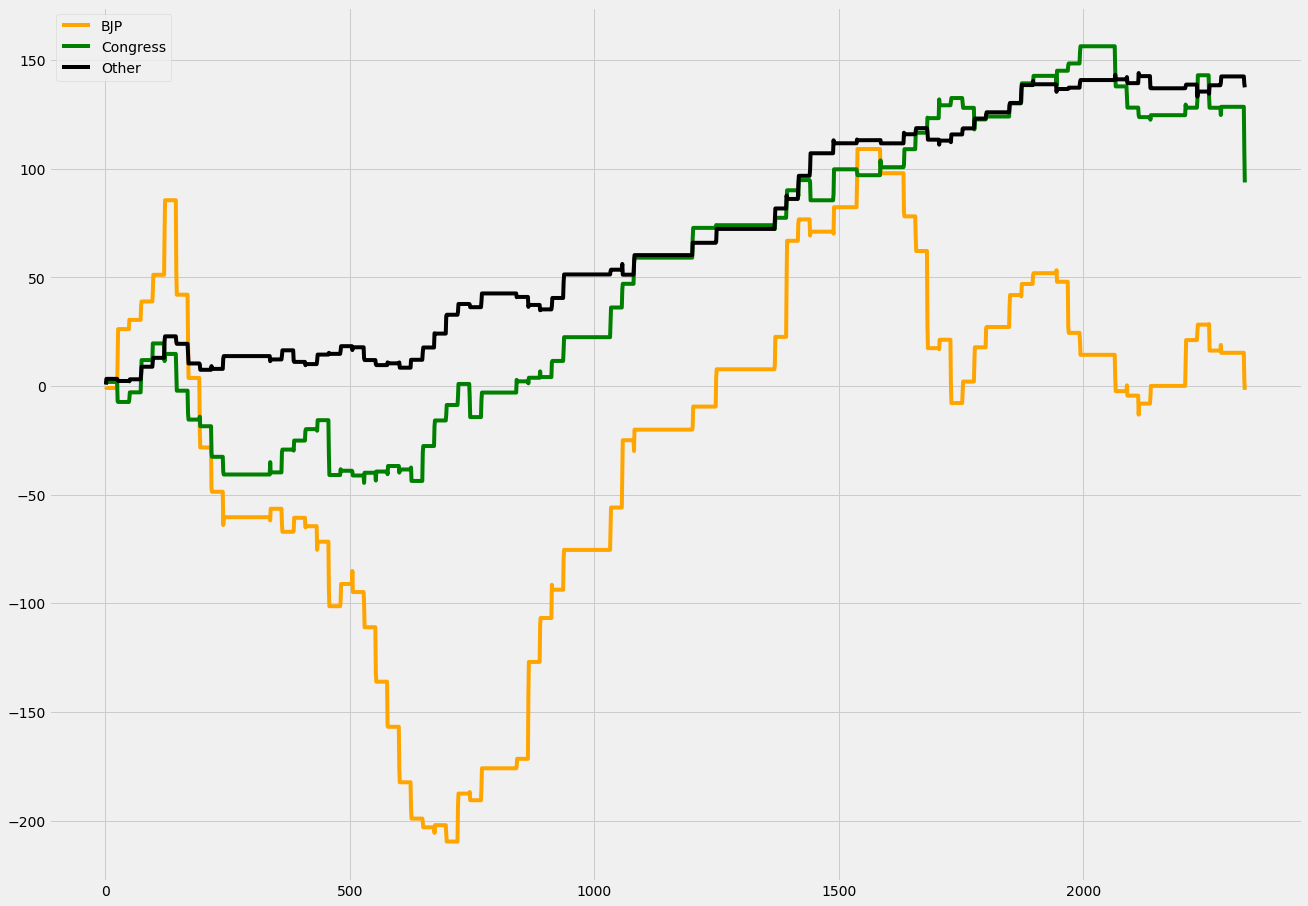

In [107]:
plt.rcParams["figure.figsize"] = [20,15]
plt.figure(num ='Lok Sabha')
plt.plot([i  for i in range(1,2331)],hour_total_bjp,label = 'BJP',color = 'orange')
plt.plot([i  for i in range(1,2331)],hour_total_cong,label = 'Congress',color = 'green')
plt.plot([i  for i in range(1,2331)],hour_total_other,label = 'Other',color = 'black')
plt.style.use('fivethirtyeight')
ax = plt.gca()
plt.grid(True)
plt.legend()
plt.show()
plt.close()

# Per Day Popularity over 100 days

In [108]:
score_day = {}
all_days = []
result=time_day[0]
while result<= time_day[-1]:
    all_days.append(result)
    result+=timedelta(days=1)
#print(all_days)
for t in all_days:
    score_day[t] = {"BJP":0,"Congress":0,"Other":0}
for i in range(0,39874):
    t = df["last_updated"][i]
    score_day[t.date()][df["Party"][i]]+=df["Compound"][i]

In [109]:
day_total_bjp, day_total_cong, day_total_other = [],[],[]
for i in score_day:
    try:
        day_total_bjp.append(score_day[i]["BJP"]+day_total_bjp[-1])
    except IndexError:
        day_total_bjp.append(score_day[i]["BJP"]+0)

for i in score_day:
    try:
        day_total_cong.append(score_day[i]["Congress"]+day_total_cong[-1])
    except IndexError:
        day_total_cong.append(score_day[i]["Congress"]+0)

for i in score_day:
    try:
        day_total_other.append(score_day[i]["Other"]+day_total_other[-1])
    except IndexError:
        day_total_other.append(score_day[i]["Other"]+0)

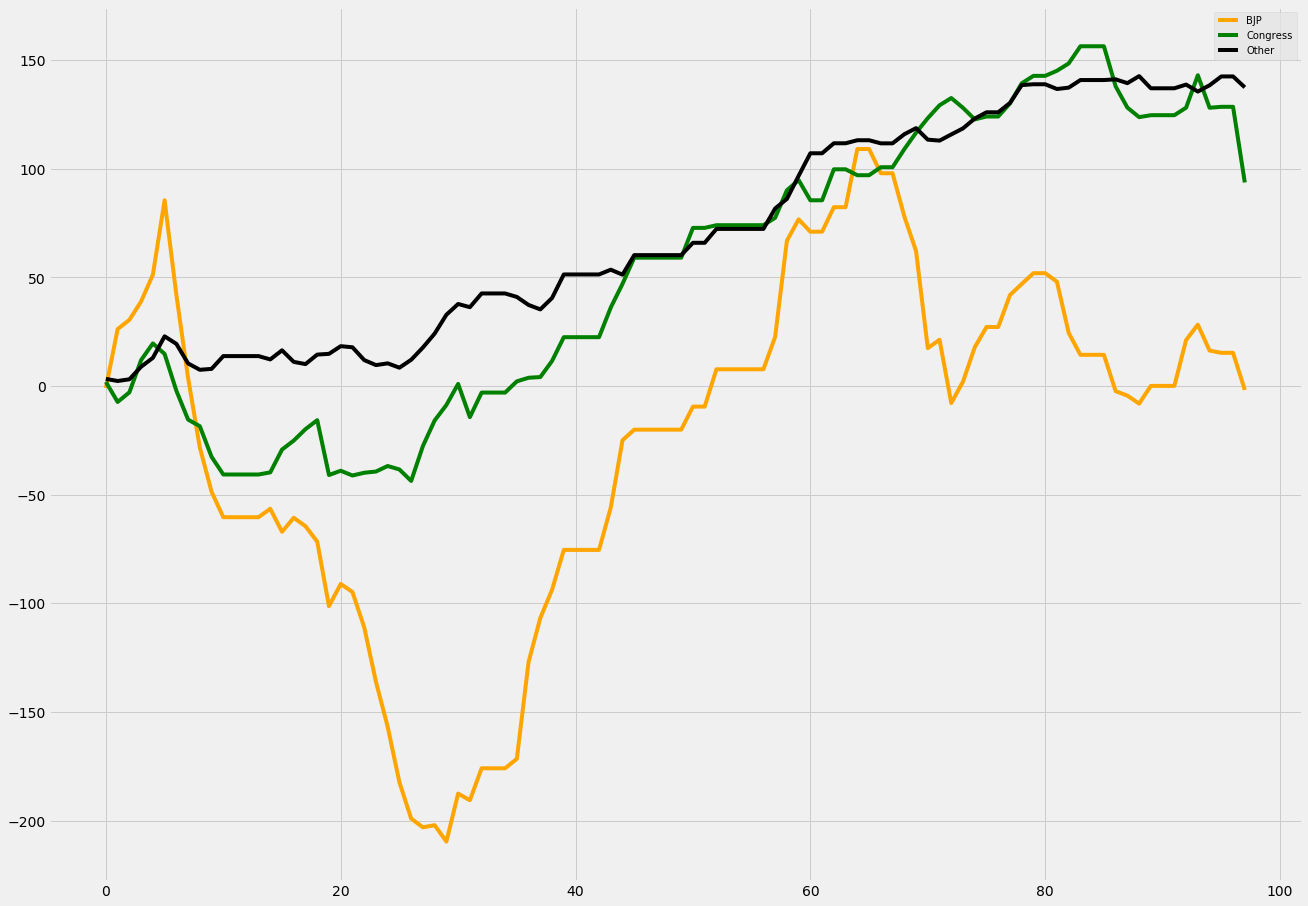

In [110]:
plt.rcParams["figure.figsize"] = [20,15]
plt.figure(num ='Lok Sabha')
plt.plot([i  for i in range(0,98)],day_total_bjp,label = 'BJP',color = 'orange')
plt.plot([i  for i in range(0,98)],day_total_cong,label = 'Congress',color = 'green')
plt.plot([i  for i in range(0,98)],day_total_other,label = 'Other',color = 'black')
plt.style.use('ggplot')
ax = plt.gca()
plt.grid(True)
plt.legend()
plt.show()
plt.close()

In [111]:
score_day = {}
all_days = []
result=time_day[0]
while result<= time_day[-1]:
    all_days.append(result)
    result+=timedelta(days=1)
#print(all_days)
for t in all_days:
    score_day[t] = {"BJP":0,"Congress":0,"Other":0}
for i in range(0,39874):
    t = df["last_updated"][i]
    score_day[t.date()][df["Party"][i]]+=df["Score"][i]

In [112]:
day_total_bjp, day_total_cong, day_total_other = [],[],[]
for i in score_day:
    try:
        day_total_bjp.append(score_day[i]["BJP"]+day_total_bjp[-1])
    except IndexError:
        day_total_bjp.append(score_day[i]["BJP"]+0)

for i in score_day:
    try:
        day_total_cong.append(score_day[i]["Congress"]+day_total_cong[-1])
    except IndexError:
        day_total_cong.append(score_day[i]["Congress"]+0)

for i in score_day:
    try:
        day_total_other.append(score_day[i]["Other"]+day_total_other[-1])
    except IndexError:
        day_total_other.append(score_day[i]["Other"]+0)

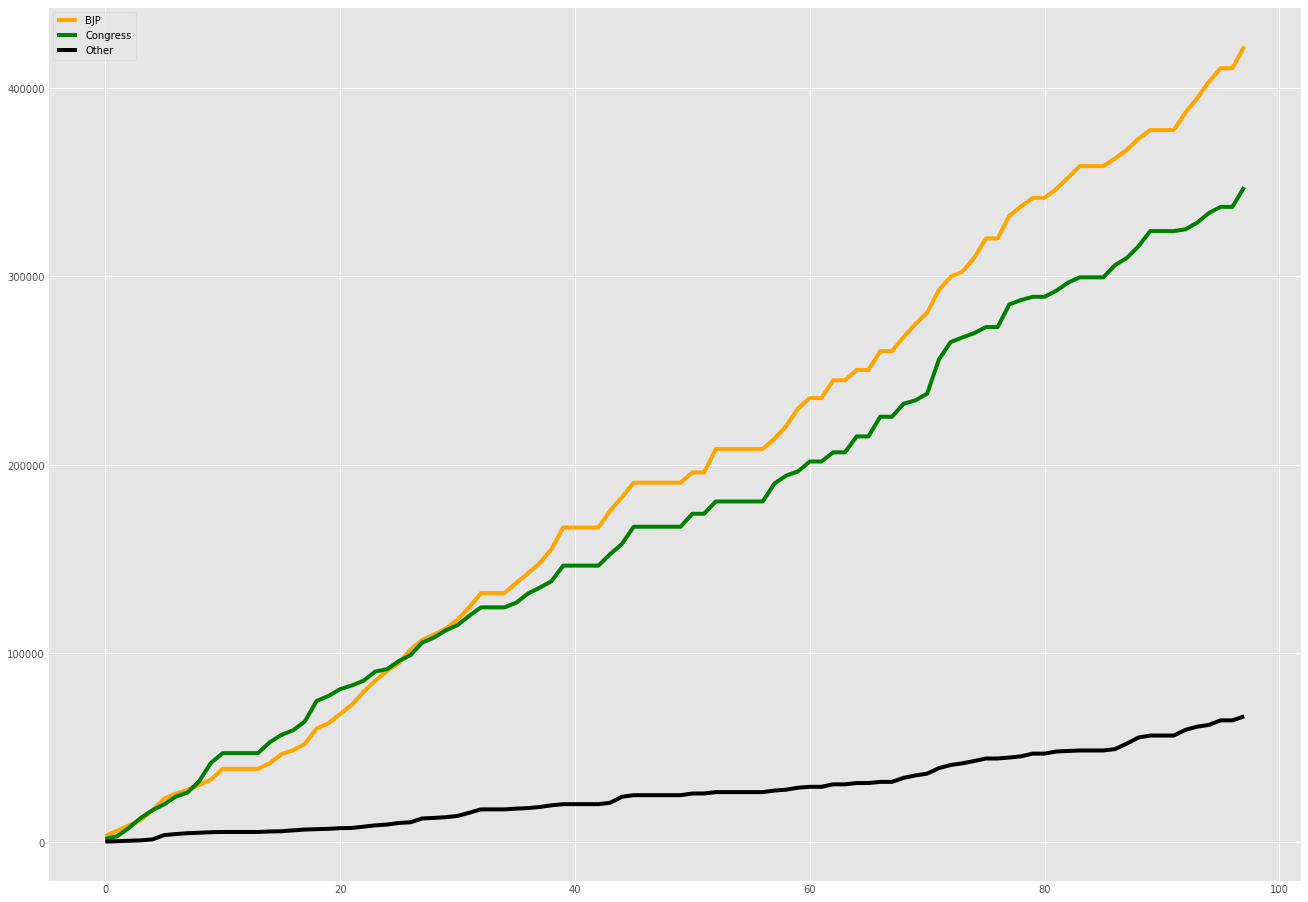

In [113]:
plt.rcParams["figure.figsize"] = [20,15]
plt.figure(num ='Lok Sabha')
plt.plot([i  for i in range(0,98)],day_total_bjp,label = 'BJP',color = 'orange')
plt.plot([i  for i in range(0,98)],day_total_cong,label = 'Congress',color = 'green')
plt.plot([i  for i in range(0,98)],day_total_other,label = 'Other',color = 'black')
plt.style.use('ggplot')
ax = plt.gca()
plt.grid(True)
plt.legend()
plt.show()
plt.close()

# Weekly Popularity over 14 weeks

In [114]:
score_week = {}
for t in time_week:
    score_week[t] = {"BJP":0,"Congress":0,"Other":0}
last = time_day[0]
ctr = 0
while last<=all_days[-1]:
    if last in time_week:
        score_week[last]["BJP"] = day_total_bjp[ctr]
        score_week[last]["Congress"] = day_total_cong[ctr]
        score_week[last]["Other"] = day_total_other[ctr]
    last+= timedelta(days=1)
    ctr+=1

In [115]:
week_total_bjp, week_total_cong, week_total_other = [],[],[]
for i in score_week:
    week_total_bjp.append(score_week[i]["BJP"])
    week_total_cong.append(score_week[i]["Congress"])
    week_total_other.append(score_week[i]["Other"])

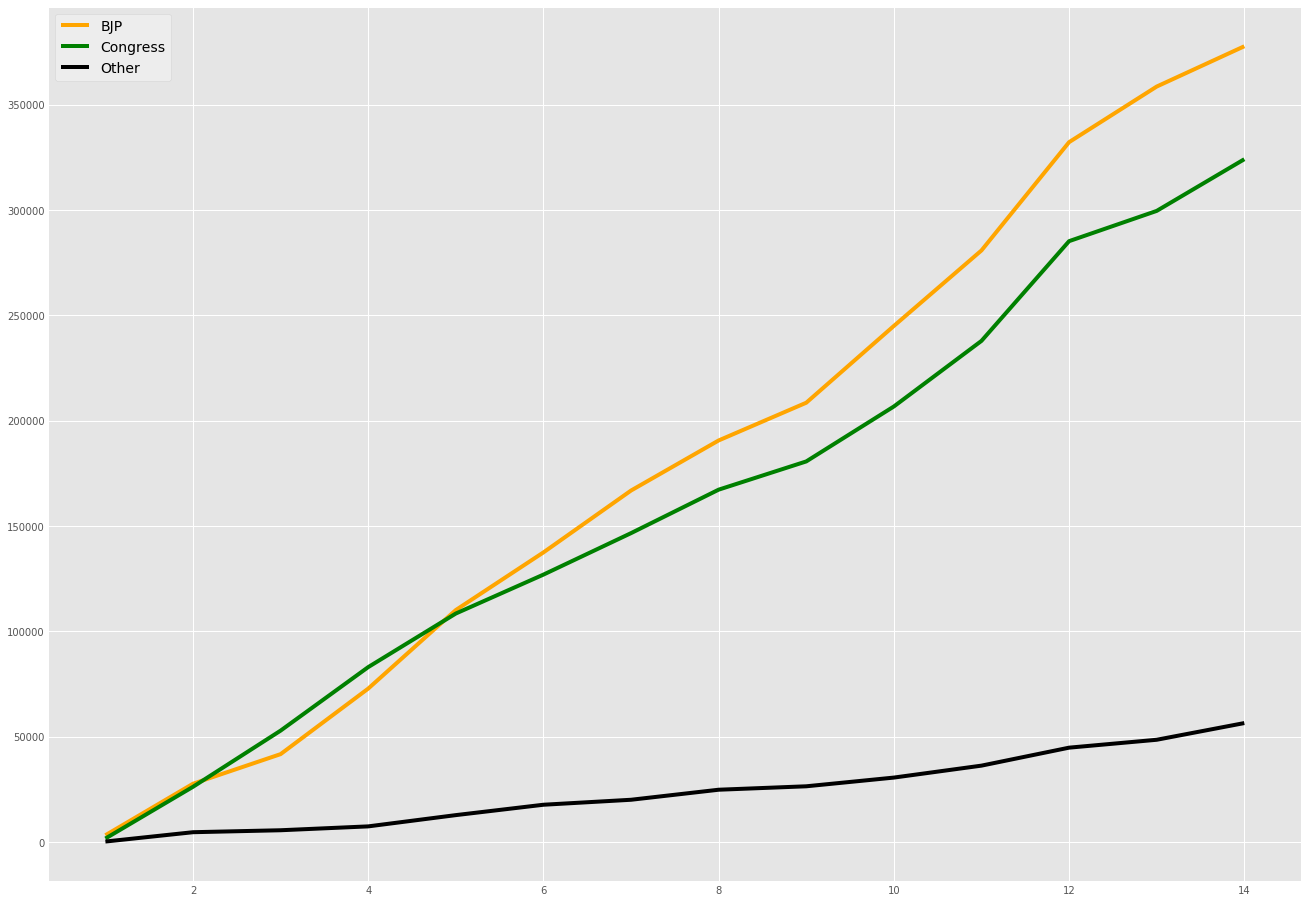

In [116]:
plt.rcParams["figure.figsize"] = [20,15]
plt.figure(num ='Lok Sabha')
plt.plot([i  for i in range(1,15)],week_total_bjp,label = 'BJP',color = 'orange')
plt.plot([i  for i in range(1,15)],week_total_cong,label = 'Congress',color = 'green')
plt.plot([i  for i in range(1,15)],week_total_other,label = 'Other',color = 'black')
plt.style.use('fivethirtyeight')
ax = plt.gca()
plt.grid(True)
plt.legend()
plt.show()
plt.close()

# Fortnightly Popularity over 7 fortnights

In [117]:
score_fn = {}
for t in time_fortnight:
    score_fn[t] = {"BJP":0,"Congress":0,"Other":0}
last = time_day[0]
ctr = 0
while last<=all_days[-1]:
    if last in time_fortnight:
        score_fn[last]["BJP"] = day_total_bjp[ctr]
        score_fn[last]["Congress"] = day_total_cong[ctr]
        score_fn[last]["Other"] = day_total_other[ctr]
    last+= timedelta(days=1)
    ctr+=1

In [118]:
fn_total_bjp, fn_total_cong, fn_total_other = [],[],[]
for i in score_fn:
    fn_total_bjp.append(score_fn[i]["BJP"])
    fn_total_cong.append(score_fn[i]["Congress"])
    fn_total_other.append(score_fn[i]["Other"])

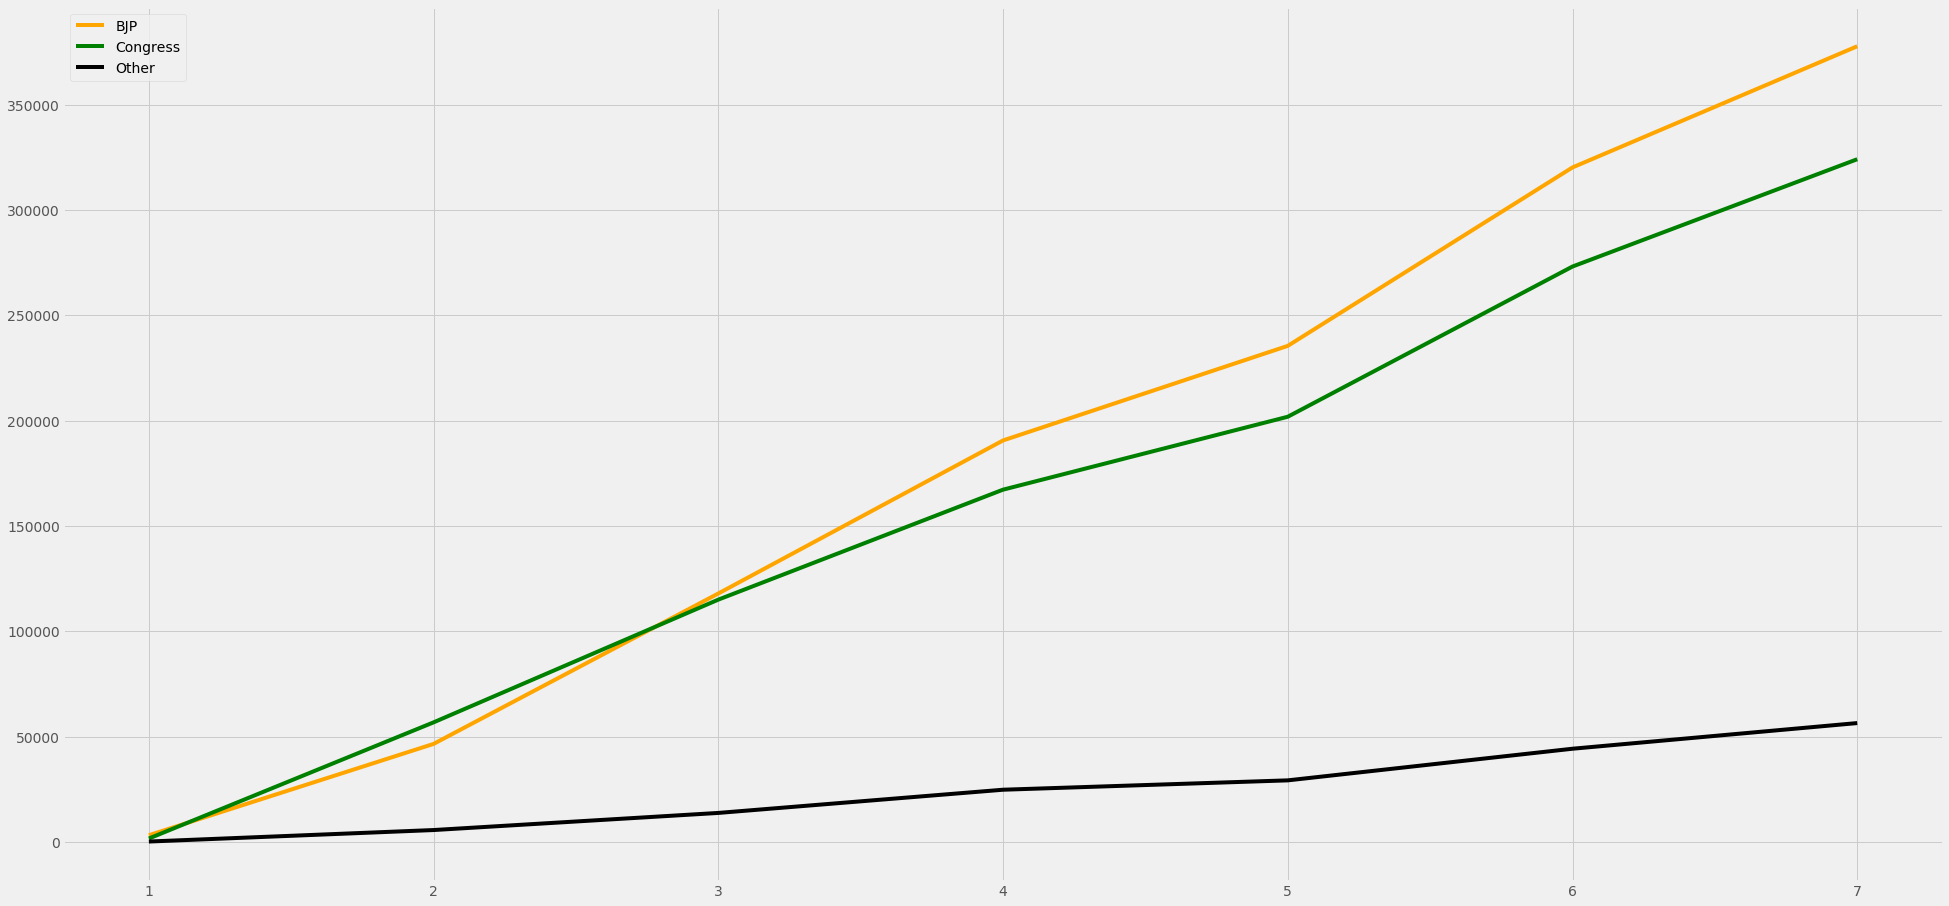

In [119]:
plt.rcParams["figure.figsize"] = [30,15]
plt.figure(num ='Lok Sabha')
plt.plot([i  for i in range(1,8)],fn_total_bjp,label = 'BJP',color = 'orange')
plt.plot([i  for i in range(1,8)],fn_total_cong,label = 'Congress',color = 'green')
plt.plot([i  for i in range(1,8)],fn_total_other,label = 'Other',color = 'black')
plt.style.use('fivethirtyeight')
ax = plt.gca()
plt.grid(True)
plt.legend()
plt.show()
plt.close()

# Monthly Popularity over 4 months

In [120]:
score_month = {}
for t in time_month:
    score_month[t] = {"BJP":0,"Congress":0,"Other":0}
for i in range(0,39874):
    t = df["last_updated"][i].month
    score_month[t][df["Party"][i]]+=df["Compound"][i]

In [121]:
month_total_bjp, month_total_cong, month_total_other = [],[],[]
for i in score_month:
    try:
        month_total_bjp.append(score_month[i]["BJP"]+month_total_bjp[-1])
    except IndexError:
        month_total_bjp.append(score_month[i]["BJP"]+0)

for i in score_month:
    try:
        month_total_cong.append(score_month[i]["Congress"]+month_total_cong[-1])
    except IndexError:
        month_total_cong.append(score_month[i]["Congress"]+0)

for i in score_month:
    try:
        month_total_other.append(score_month[i]["Other"]+month_total_other[-1])
    except IndexError:
        month_total_other.append(score_month[i]["Other"]+0)

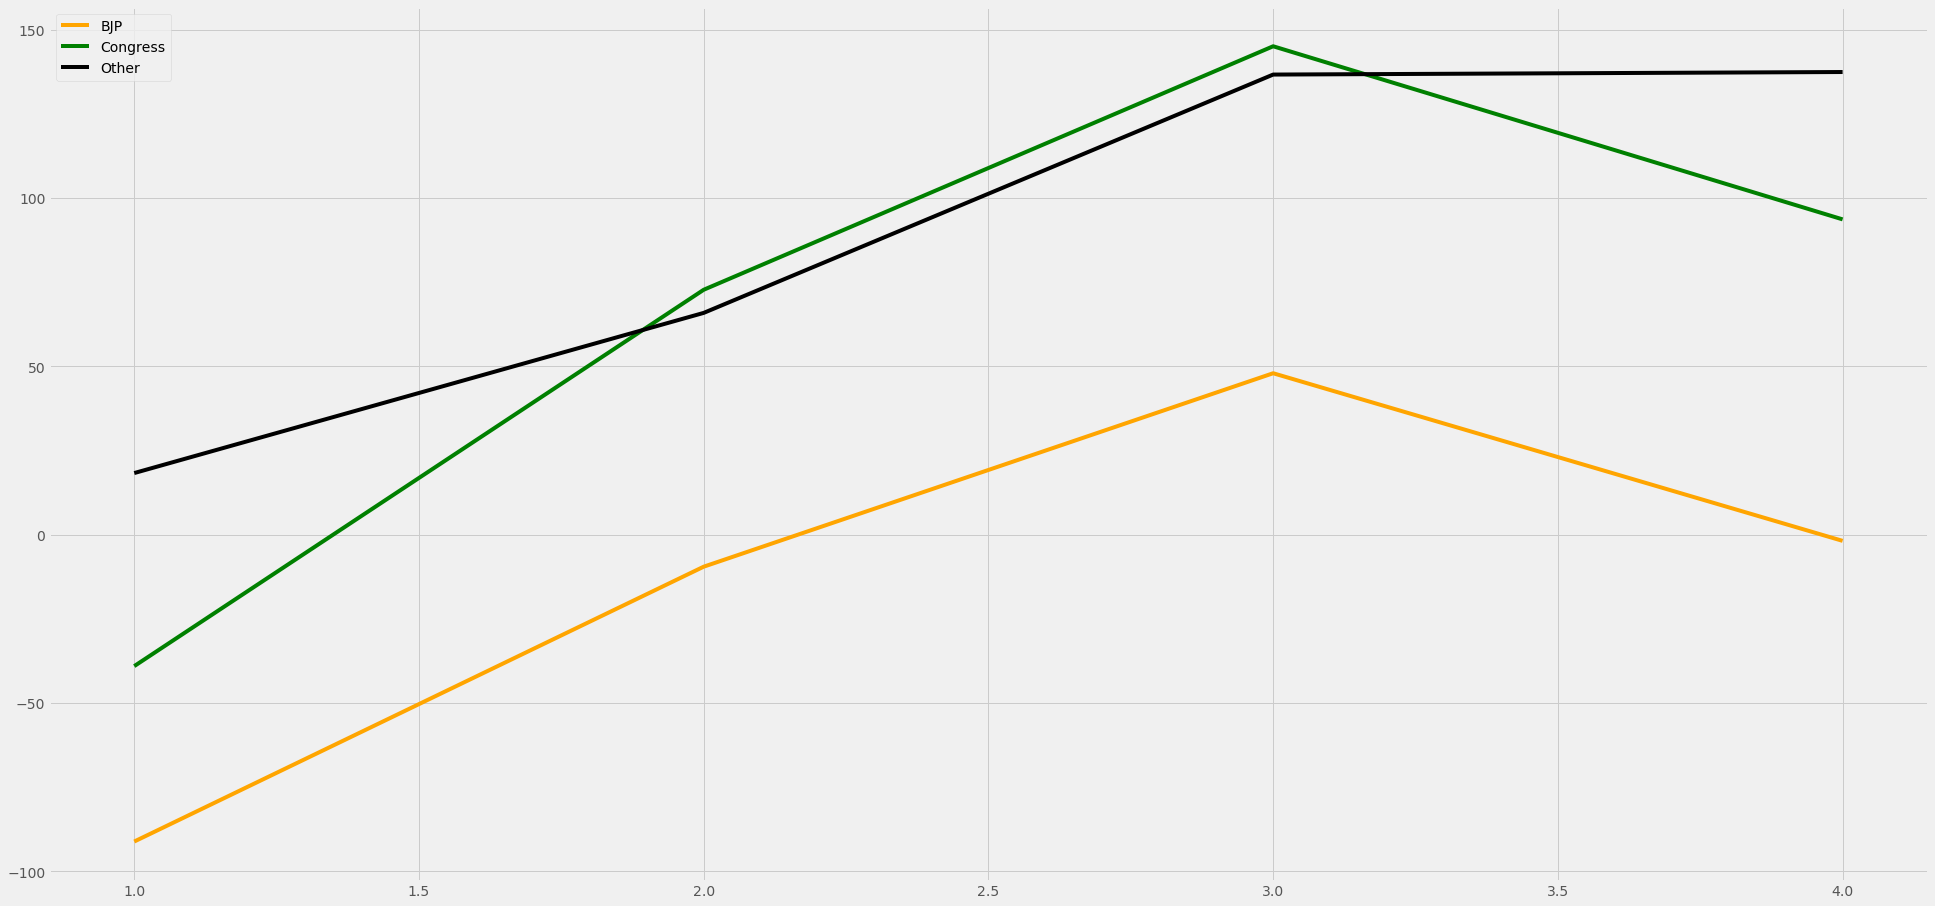

In [122]:
plt.rcParams["figure.figsize"] = [30,15]
plt.figure(num ='Lok Sabha')
plt.plot([i  for i in range(1,5)],month_total_bjp,label = 'BJP',color = 'orange')
plt.plot([i  for i in range(1,5)],month_total_cong,label = 'Congress',color = 'green')
plt.plot([i  for i in range(1,5)],month_total_other,label = 'Other',color = 'black')
plt.style.use('fivethirtyeight')
ax = plt.gca()
plt.grid(True)
plt.legend()
plt.show()
plt.close()

# Day wise Popularity per State

In [123]:
state_day_score = dict()
for i in set(list(df["State"])):
    if list(df["State"]).count(i)>500 and i!='':
        state_day_score[i]=dict()
        for t in all_days:
            state_day_score[i][t] = {"BJP":0,"Congress":0,"Other":0}

In [124]:
state_day_score["Other"]=dict()
for t in all_days:
            state_day_score["Other"][t] = {"BJP":0,"Congress":0,"Other":0}

In [125]:
for i in range(0,39874):
    t = df["last_updated"][i].date()
    st = df["State"][i]
    pty = df["Party"][i]
    cp = df["Compound"][i]
    if st in state_day_score:
            state_day_score[st][t][pty]+=cp
    else:
        state_day_score["Other"][t][pty]+=cp

In [126]:
state_popularity = dict()
for i in state_day_score:
    state_popularity[i] = {"BJP":[],"Congress":[],"Other":[]}

for st in state_day_score:
    for t in state_day_score[st]:
        try:
            state_popularity[st]["BJP"].append(state_day_score[st][t]["BJP"]+state_popularity[st]["BJP"][-1])
        except IndexError:
            state_popularity[st]["BJP"].append(state_day_score[st][t]["BJP"]+0)
            
for st in state_day_score:
    for t in state_day_score[st]:
        try:
            state_popularity[st]["Congress"].append(state_day_score[st][t]["Congress"]+state_popularity[st]["Congress"][-1])
        except IndexError:
            state_popularity[st]["Congress"].append(state_day_score[st][t]["Congress"]+0)

for st in state_day_score:
    for t in state_day_score[st]:
        try:
            state_popularity[st]["Other"].append(state_day_score[st][t]["Other"]+state_popularity[st]["Other"][-1])
        except IndexError:
            state_popularity[st]["Other"].append(state_day_score[st][t]["Other"]+0)


In [127]:
del state_popularity["Other"]

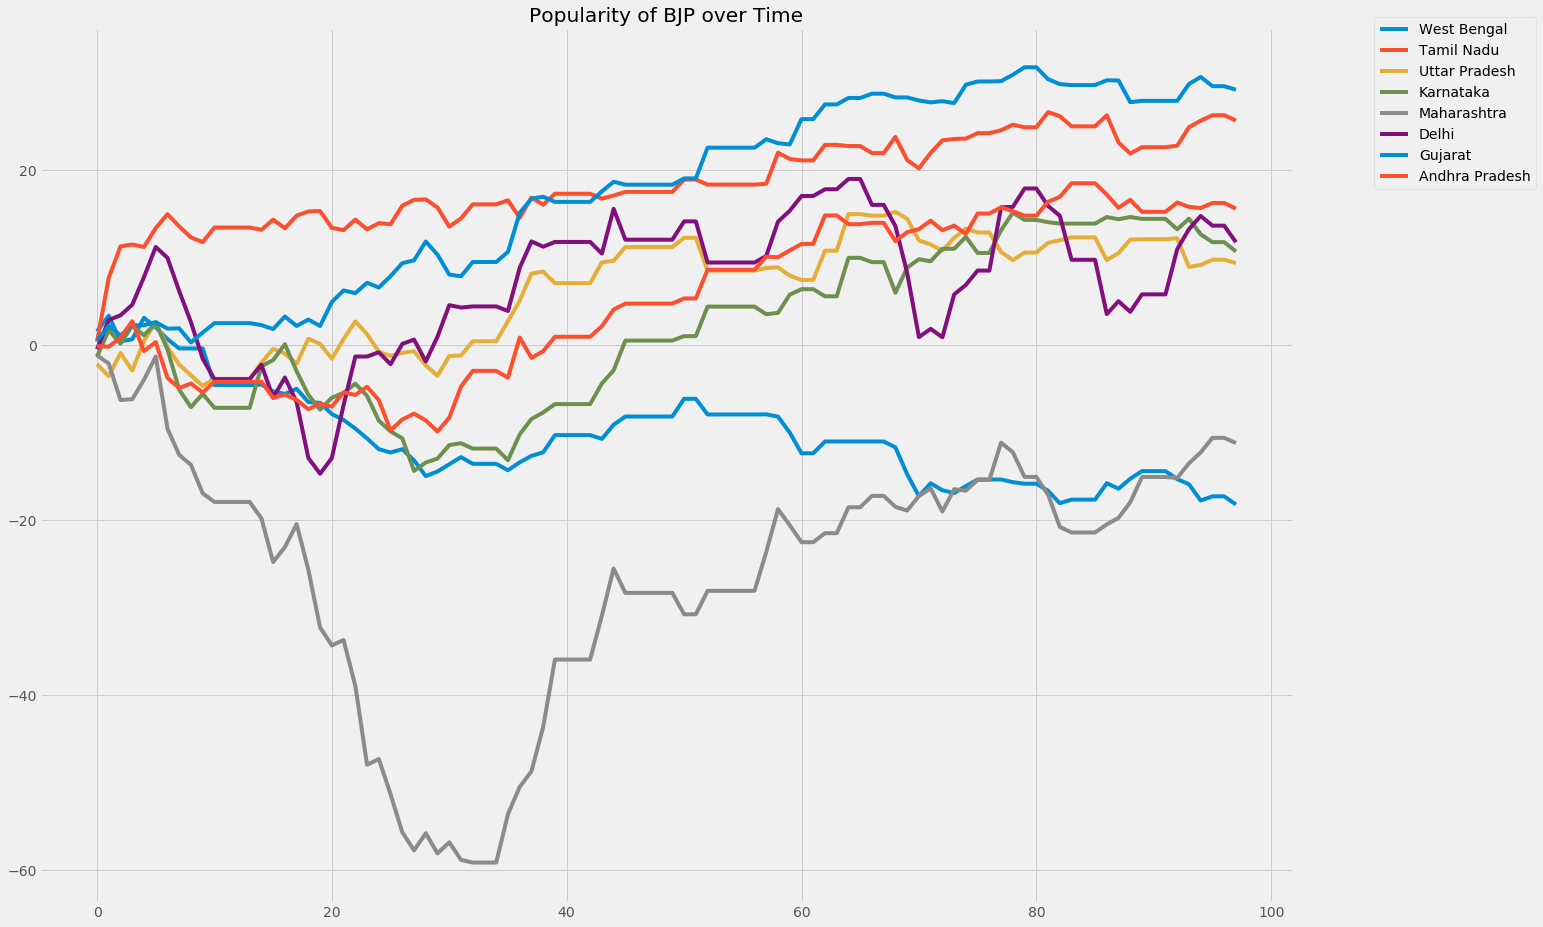

In [128]:
plt.rcParams["figure.figsize"] = [20,15]
plt.figure(num ='Lok Sabha')
#colors = ["red","blue","orange","purple","green","violet","pink","black","lightblue","lightgreen","darkred","grey"]
ctr=0
for i in state_popularity:
    plt.plot([i  for i in range(0,98)],state_popularity[i]["BJP"],label = i)
    ctr+=1
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(20,20))
plt.title("Popularity of BJP over Time")
ax = plt.gca()
plt.grid(True)
plt.legend( loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()
plt.close()

In [129]:
state_day_score = dict()
for i in set(list(df["State"])):
    if list(df["State"]).count(i)>500 and i!='':
        state_day_score[i]=dict()
        for t in all_days:
            state_day_score[i][t] = {"BJP":0,"Congress":0,"Other":0}

In [130]:
state_day_score["Other"]=dict()
for t in all_days:
            state_day_score["Other"][t] = {"BJP":0,"Congress":0,"Other":0}

In [131]:
for i in range(0,39874):
    t = df["last_updated"][i].date()
    st = df["State"][i]
    pty = df["Party"][i]
    cp = df["Score"][i]
    if st in state_day_score:
            state_day_score[st][t][pty]+=cp
    else:
        state_day_score["Other"][t][pty]+=cp

In [132]:
state_popularity = dict()
for i in state_day_score:
    state_popularity[i] = {"BJP":[],"Congress":[],"Other":[]}

for st in state_day_score:
    for t in state_day_score[st]:
        try:
            state_popularity[st]["BJP"].append(state_day_score[st][t]["BJP"]+state_popularity[st]["BJP"][-1])
        except IndexError:
            state_popularity[st]["BJP"].append(state_day_score[st][t]["BJP"]+0)
            
for st in state_day_score:
    for t in state_day_score[st]:
        try:
            state_popularity[st]["Congress"].append(state_day_score[st][t]["Congress"]+state_popularity[st]["Congress"][-1])
        except IndexError:
            state_popularity[st]["Congress"].append(state_day_score[st][t]["Congress"]+0)

for st in state_day_score:
    for t in state_day_score[st]:
        try:
            state_popularity[st]["Other"].append(state_day_score[st][t]["Other"]+state_popularity[st]["Other"][-1])
        except IndexError:
            state_popularity[st]["Other"].append(state_day_score[st][t]["Other"]+0)


In [133]:
del state_popularity["Other"]

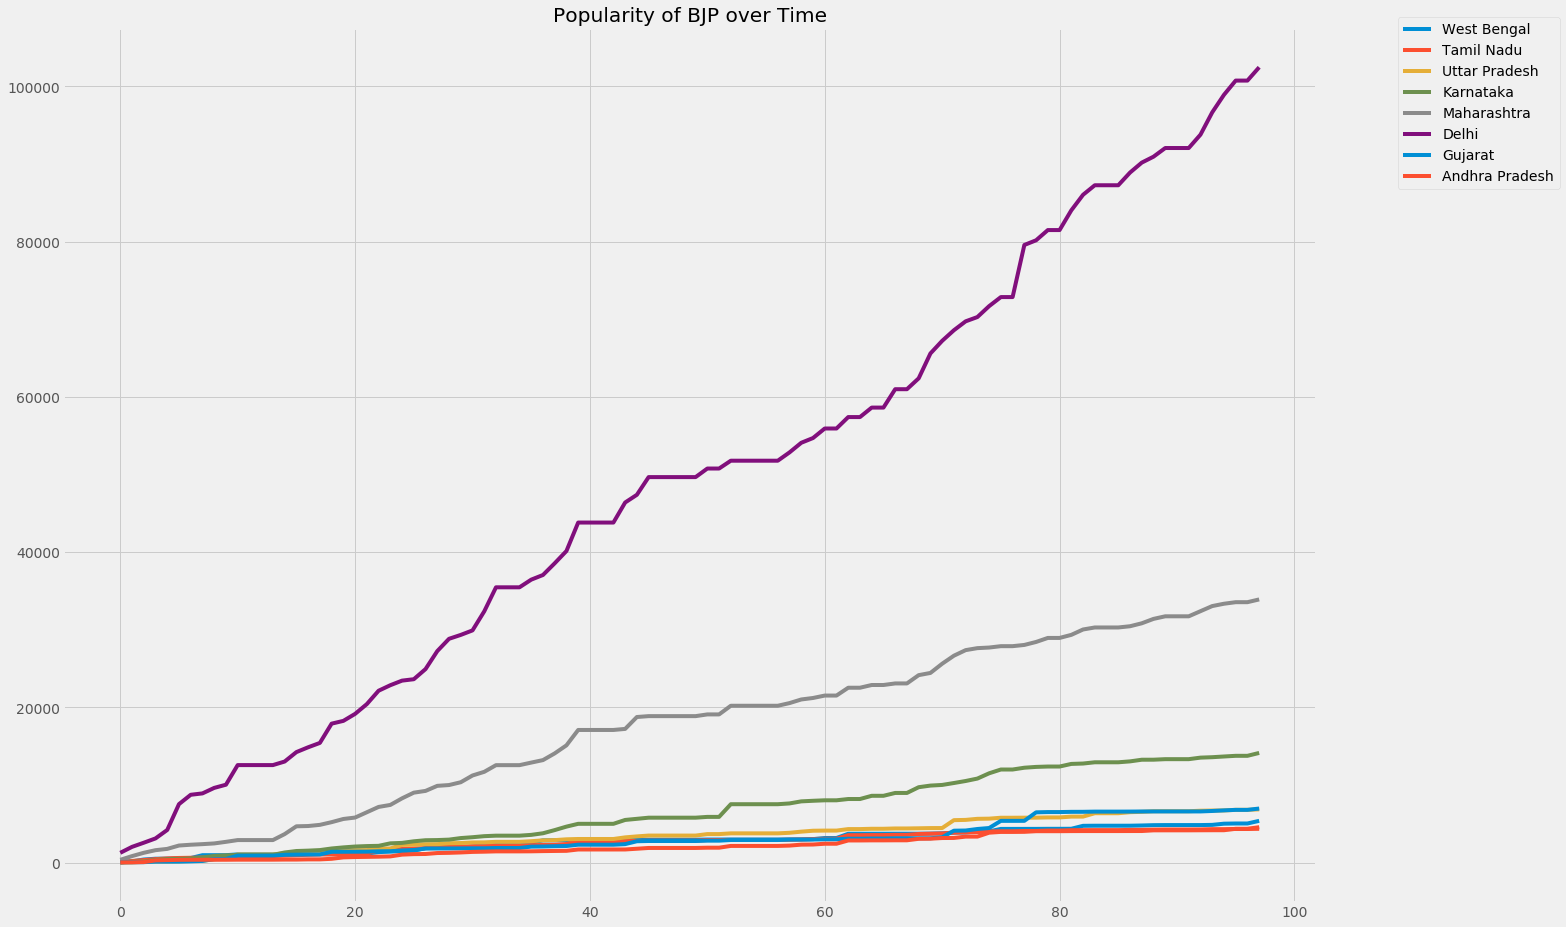

In [134]:
plt.rcParams["figure.figsize"] = [20,15]
plt.figure(num ='Lok Sabha')
#colors = ["red","blue","orange","purple","green","violet","pink","black","lightblue","lightgreen","darkred","grey"]
ctr=0
for i in state_popularity:
    plt.plot([i  for i in range(0,98)],state_popularity[i]["BJP"],label = i)
    ctr+=1
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(20,20))
plt.title("Popularity of BJP over Time")
ax = plt.gca()
plt.grid(True)
plt.legend( loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()
plt.close()

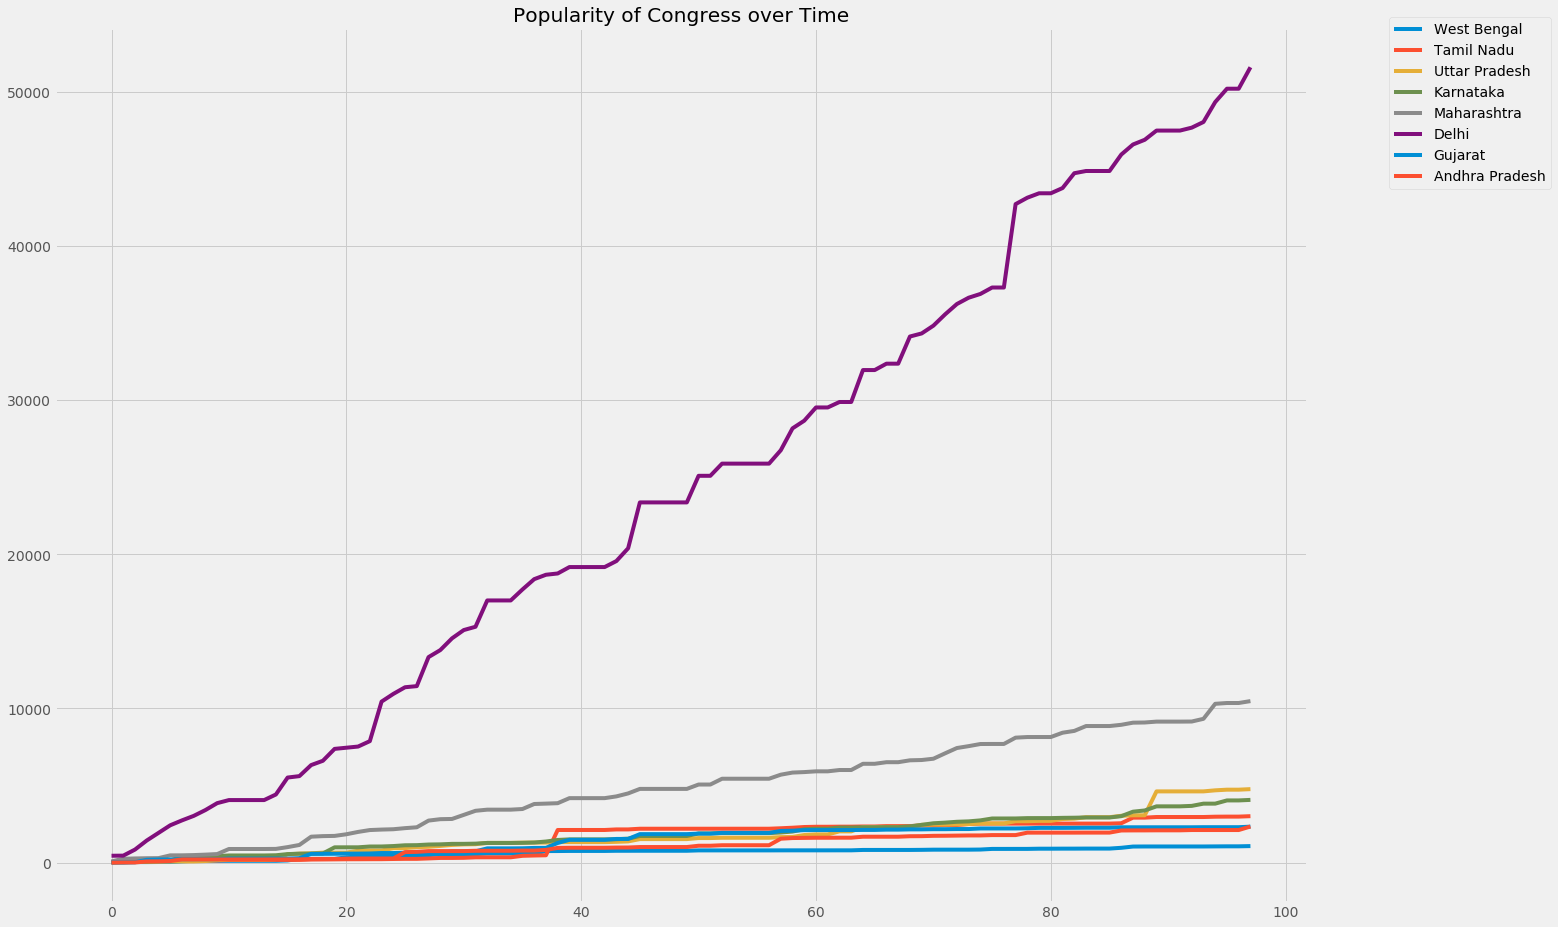

In [135]:
plt.figure(num ='Lok Sabha')
plt.rcParams["figure.figsize"] = [20,15]
for i in state_popularity:
    plt.plot([i  for i in range(0,98)],state_popularity[i]["Congress"],label = i)
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(20,20))
plt.title("Popularity of Congress over Time")
ax = plt.gca()
plt.grid(True)
plt.legend( loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()
plt.close()

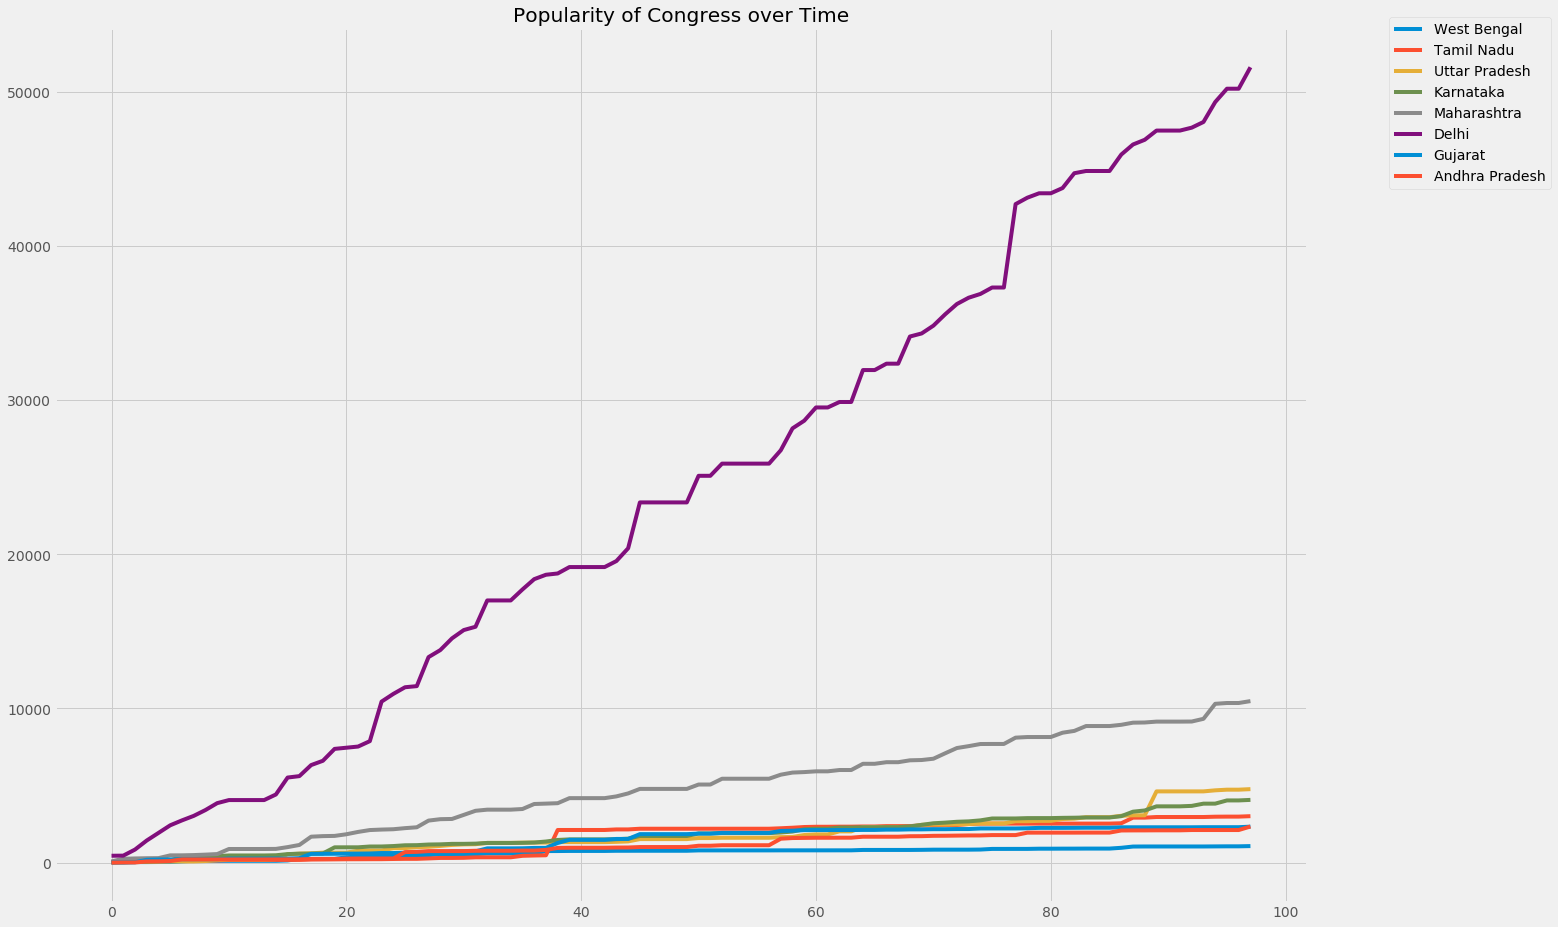

In [136]:
plt.figure(num ='Lok Sabha')
plt.rcParams["figure.figsize"] = [20,15]
for i in state_popularity:
    plt.plot([i  for i in range(0,98)],state_popularity[i]["Congress"],label = i)
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(20,20))
plt.title("Popularity of Congress over Time")
ax = plt.gca()
plt.grid(True)
plt.legend( loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()
plt.close()

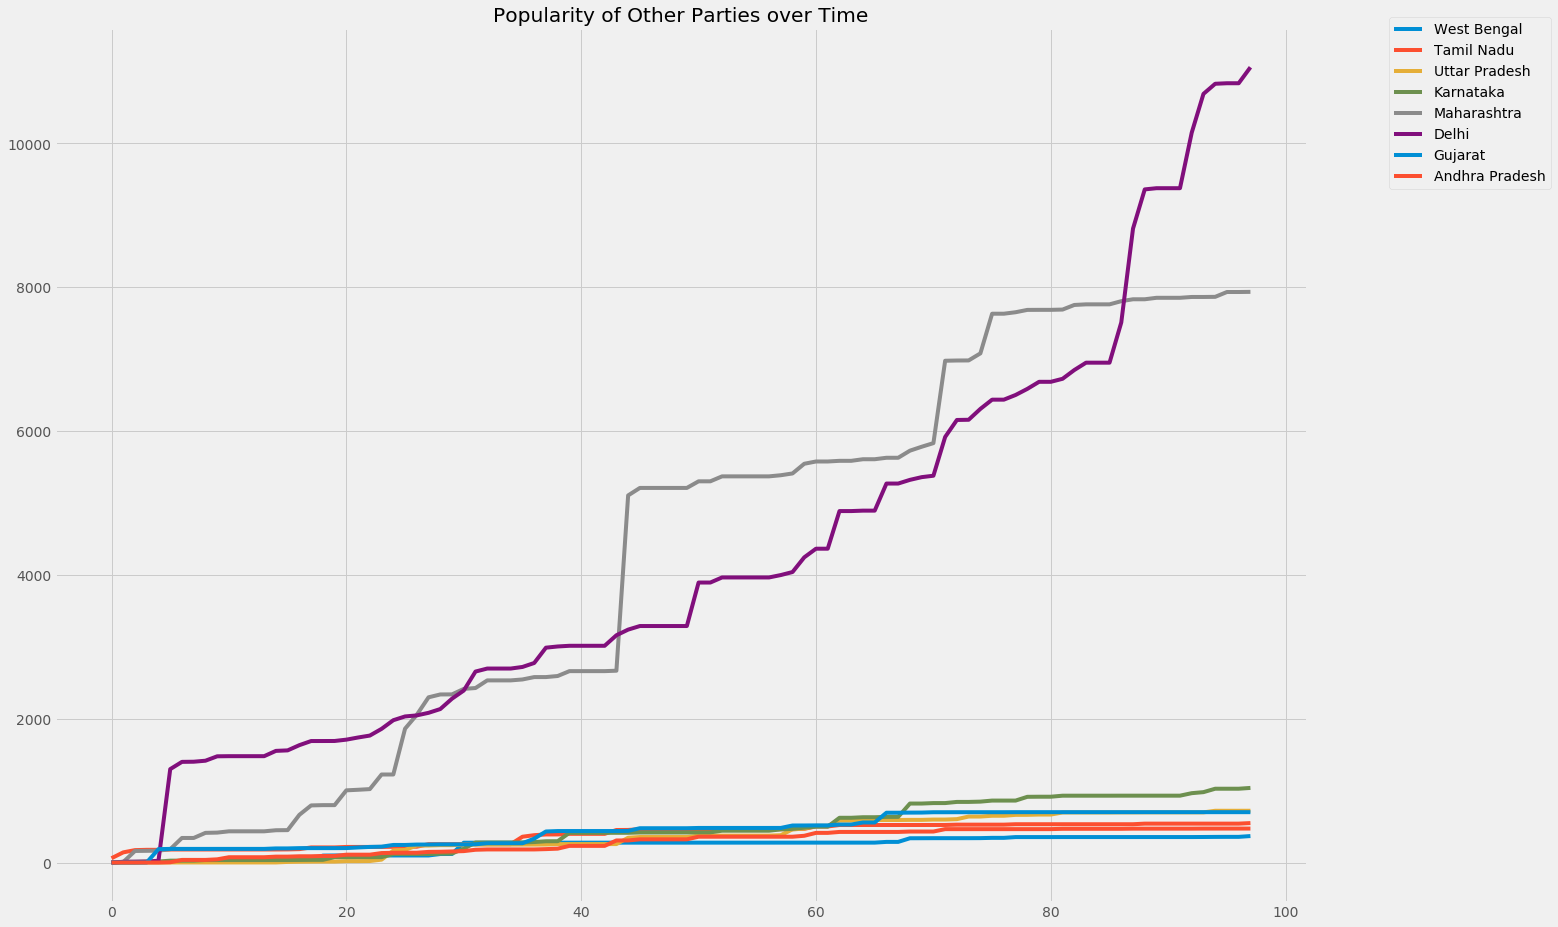

In [137]:
plt.figure(num ='Lok Sabha')
plt.rcParams["figure.figsize"] = [20,15]
for i in state_popularity:
    plt.plot([i  for i in range(0,98)],state_popularity[i]["Other"],label = i)
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(20,20))
ax = plt.gca()
plt.grid(True)
plt.title("Popularity of Other Parties over Time")
plt.legend( loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show() 
plt.close()

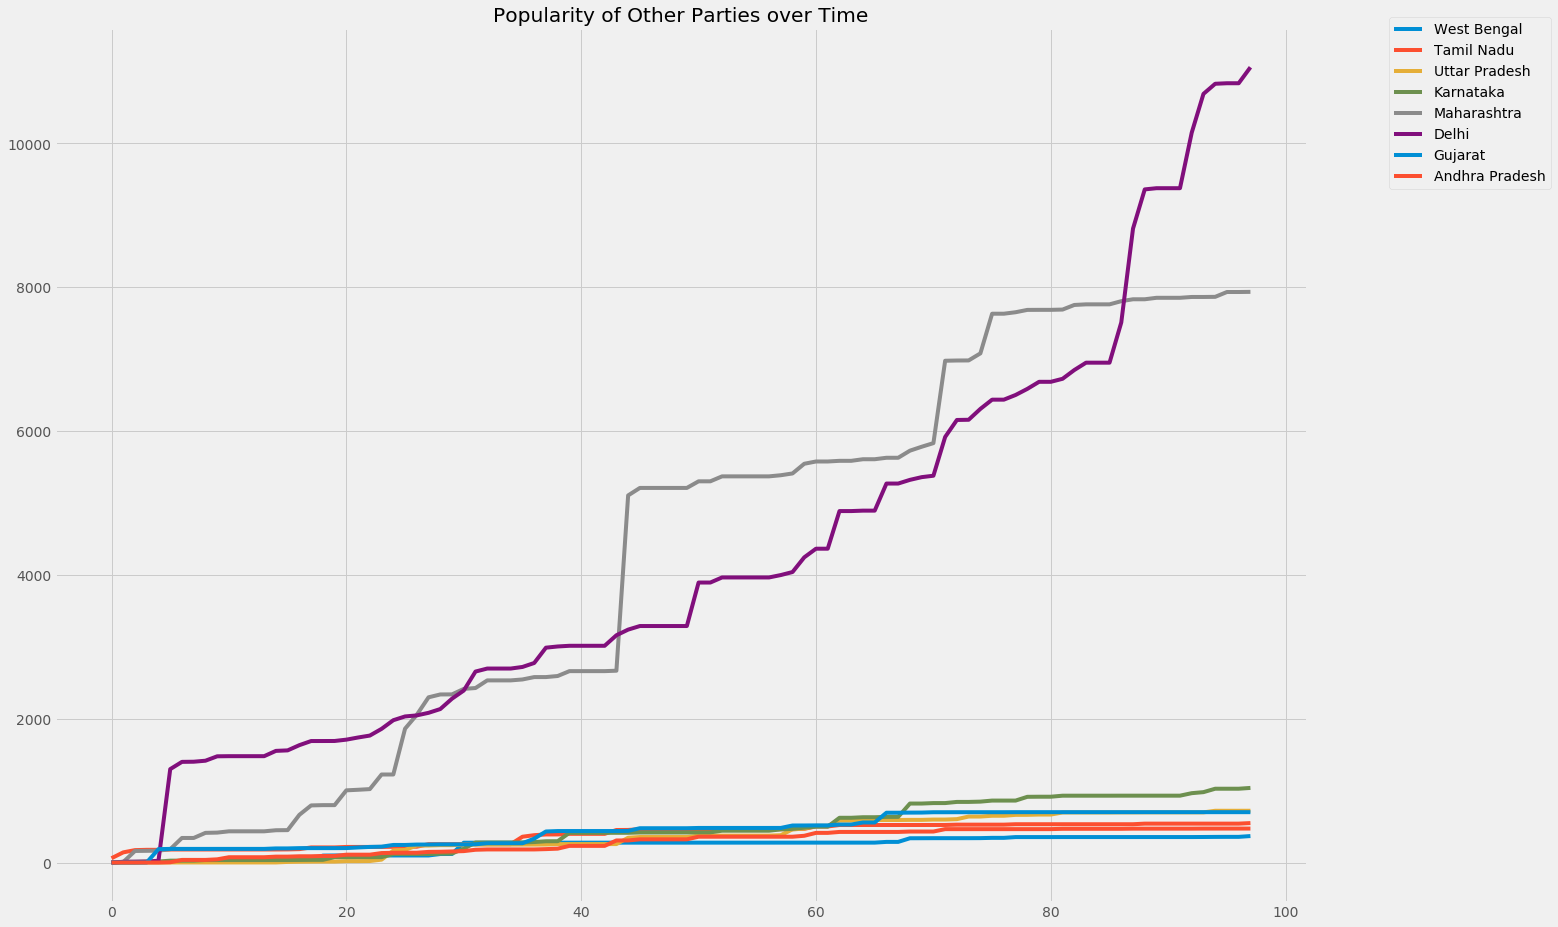

In [138]:
plt.figure(num ='Lok Sabha')
plt.rcParams["figure.figsize"] = [20,15]
for i in state_popularity:
    plt.plot([i  for i in range(0,98)],state_popularity[i]["Other"],label = i)
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(20,20))
ax = plt.gca()
plt.grid(True)
plt.title("Popularity of Other Parties over Time")
plt.legend( loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show() 
plt.close()

# Plotting Final Popularity before Results

Text(0.5, 1.0, 'Final Popularity Index')

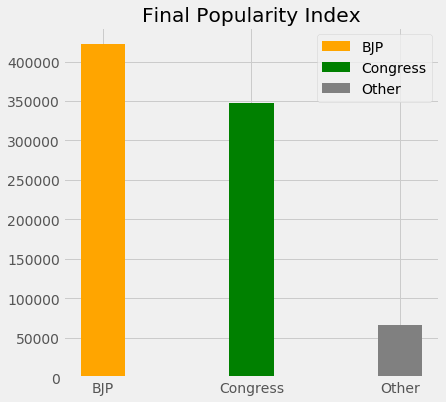

In [139]:
plt.rcParams["figure.figsize"] = [6,6]
x = matplotlib.pyplot.bar(["BJP","Congress","Other"],[max(day_total_bjp),max(day_total_cong),max(day_total_other)],width=0.3,color=["Orange","green","grey"])
plt.legend([x[0],x[1],x[2]],["BJP","Congress","Other"])
plt.title("Final Popularity Index")

In [140]:
states = list(set(list(df["State"])))
states.remove("")

# Most tweeted from States

In [141]:
state_count = dict(df["State"].value_counts())
del state_count[""]
state_count["Other"] = 0
most_state_count = dict()
most_state_count["Other"] =0

In [142]:
for i in state_count:
    if state_count[i]<150:
        most_state_count["Other"]+=state_count[i]
    else:
        most_state_count[i] = state_count[i]

Text(0.5, 1.0, 'Most Tweeted from States')

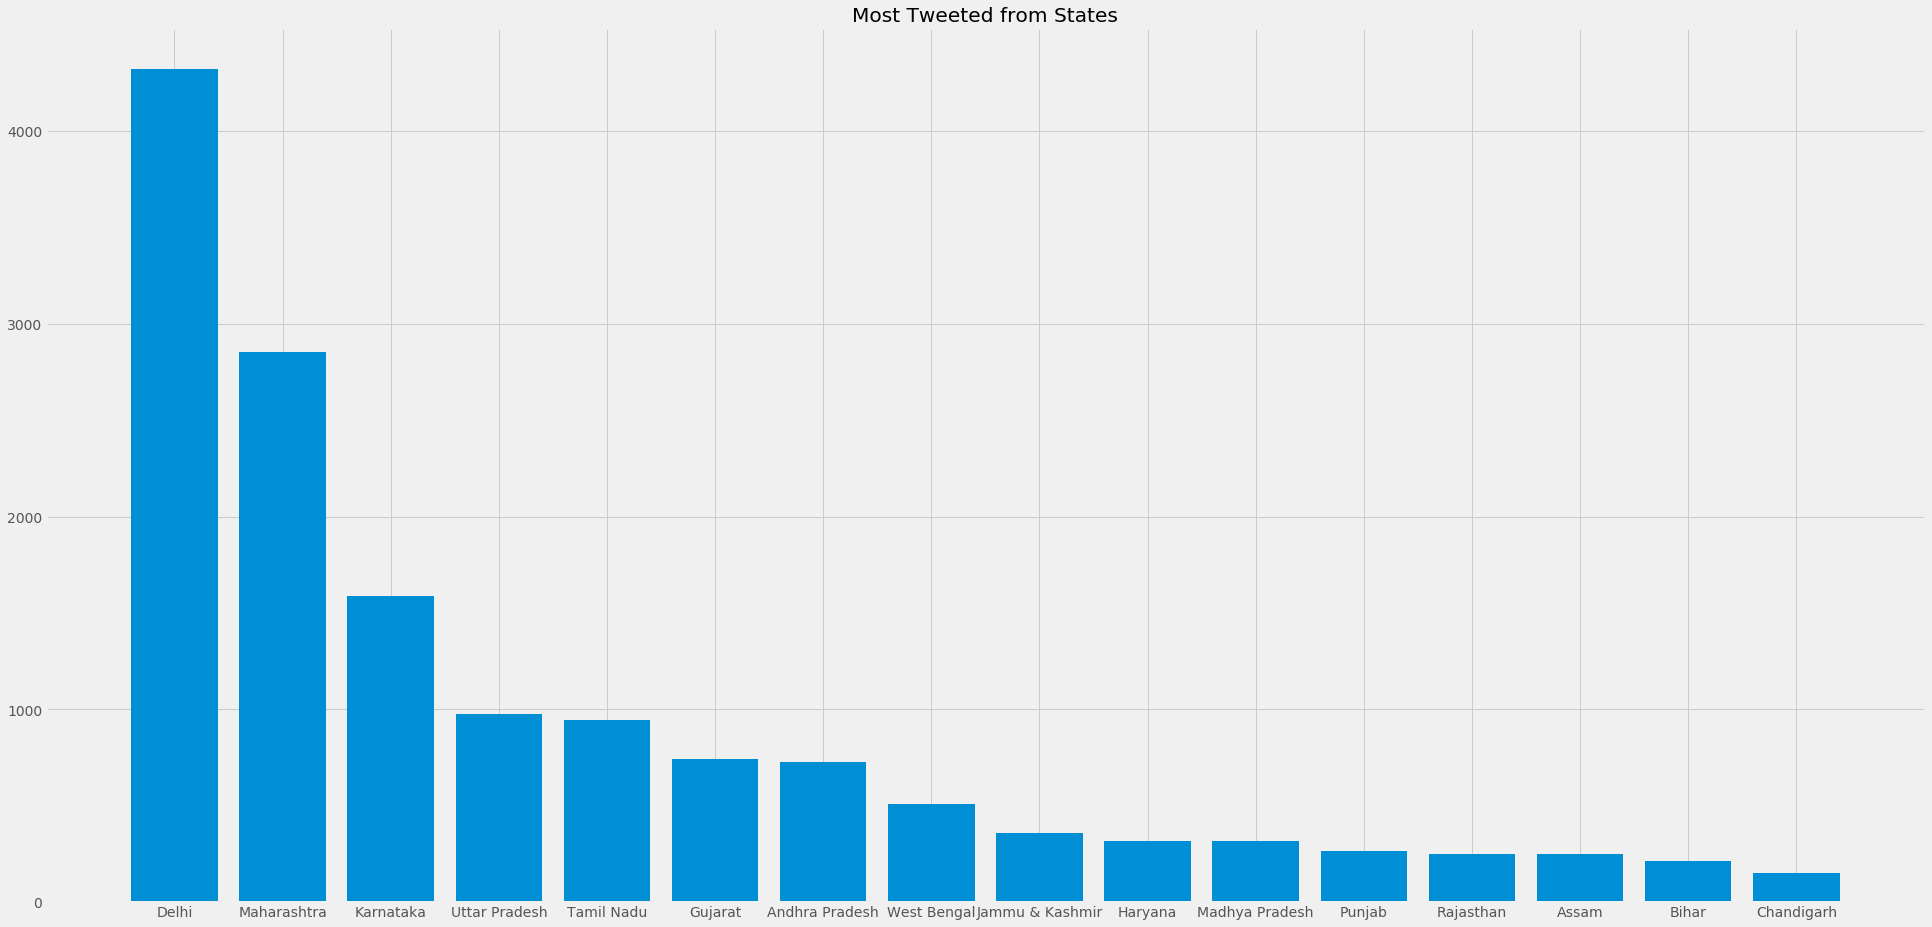

In [143]:
plt.rcParams["figure.figsize"] = [30,15]
del most_state_count["Other"]
plt.style.use('fivethirtyeight')
fig = plt.bar(list(most_state_count.keys()),list(most_state_count.values()),width = 0.8)
plt.title("Most Tweeted from States")

In [144]:
fp1 = r"INDIA\IND_adm1.shp"
map_df1 = gpd.read_file(fp1)

In [145]:
count = dict(df["State"].value_counts())
states = list(count.keys())
states.remove("")

In [146]:
geo=[]
for i in states:
    for j in range(0,36):
        name1 = i
        name2 = map_df1["NAME_1"][j]
        if(name1==name2):
            geo.append(map_df1["geometry"][j])
            break
        elif len(set(name1.split()).intersection(set(name2.split())))>1:
            geo.append(map_df1["geometry"][j])
            break
        elif name2=="Puducherry" and name1 == "Pondicherry":
            geo.append(map_df1["geometry"][j])
            break

In [147]:
bjp,cong,other,party,tweets,bjppop,congpop,opop=[],[],[],[],[],[],[],[]
partycount = dict()
for i in states:
    partycount[i] = {"BJP":0,"Congress":0,"Other":0,"BJPPop":0,"CongPop":0,"OtherPop":0,
                     'narendramodi':0,'bjp4india':0,'incindia':0,'rahulgandhi':0,
                    "htmodi":0,'htbjp':0,'htloksabha':0,'htcong':0,'htrahulgandhi':0,'htchow':0}

In [148]:
for i in range(0,39874):
    p = df["Party"][i]
    s = df["State"][i]
    cp = df["Compound"][i]
    temp = df["hashtags"][i]
    user = df["user_mentions_screen_name"][i]
    if s=="":
        continue
    partycount[s][p]+=1
    if p=="BJP":
        partycount[s]["BJPPop"]+=cp
    if p=="Congress":
        partycount[s]["CongPop"]+=cp
    if p=="Other":
        partycount[s]["OtherPop"]+=cp
    for hst in temp.split(','):
        if hst =="BJP":
            partycount[s]['htbjp']+=1
        if hst =="Modi":
            partycount[s]['htmodi']+=1
        if hst =="LokSabhaElections2019":
            partycount[s]['htloksabha']+=1
        if hst =="Congress":
            partycount[s]['htcong']+=1
        if hst =="RahulGandhi":
            partycount[s]['htrahulgandhi']+=1
        if hst =="MainBhiChowkidar":
            partycount[s]['htchow']+=1
    for x in user.split(','):
        if x=="BJP4India":
            partycount[s]['bjp4india']+=1
        if x=="narendramodi":
            partycount[s]['narendramodi']+=1
        if x=="INCIndia":
            partycount[s]['incindia']+=1
        if x=="RahulGandhi":
            partycount[s]['rahulgandhi']+=1          

In [149]:
htbjp,htmodi,htls,htcong,htrg,htchow = [],[],[],[],[],[]
hdbjp,hdmodi,hdcong,hdrg=[],[],[],[]

for i in partycount:
    bjp.append(partycount[i]["BJP"])
    cong.append(partycount[i]["Congress"])
    other.append(partycount[i]["Other"])
    tweets.append(partycount[i]["BJP"]+partycount[i]["Congress"]+partycount[i]["Other"])
    bjppop.append(partycount[i]["BJPPop"])
    congpop.append(partycount[i]["CongPop"])
    opop.append(partycount[i]["OtherPop"])
    
    htbjp.append(partycount[i]['htbjp'])
    htmodi.append(partycount[i]['htmodi'])
    htls.append(partycount[i]['htloksabha'])
    htcong.append(partycount[i]['htcong'])
    htrg.append(partycount[i]['htrahulgandhi'])
    htchow.append(partycount[i]['htchow'])
    
    hdbjp.append(partycount[i]['bjp4india'])
    hdmodi.append(partycount[i]['narendramodi'])
    hdcong.append(partycount[i]['incindia'])
    hdrg.append(partycount[i]['rahulgandhi'])
    
    if partycount[i]["BJPPop"]>partycount[i]["CongPop"] and partycount[i]["BJPPop"]>partycount[i]["OtherPop"]:
        party.append("BJP")
    elif partycount[i]["BJPPop"]<partycount[i]["CongPop"] and partycount[i]["OtherPop"]<partycount[i]["CongPop"]:
        party.append("Congress")
    else:
        party.append("Other")

In [150]:
testdf = pd.DataFrame({"State":states,"Tweets":tweets,"Geo":geo,"Party":party,"BJP":bjp,"Congress":cong,"Other":other,
                      "BJPPop":bjppop,"Congpop":congpop,"OtherPop":opop,
                      "#BJP":htbjp,"#Modi":htmodi,"#LokSabhaElections2019":htls,"#Congress":htcong,"#RahulGandhi":htrg,"#MainBhiChowkidar":htchow,
                      "@BJP4India":hdbjp,"@narendramodi":hdmodi,"@INCIndia":hdcong,"@RahulGandhi":hdrg})
testdf.head()

State  Tweets                                                Geo  \
0          Delhi    4320  POLYGON ((77.32713317871099 28.68515968322754,...   
1    Maharashtra    2852  (POLYGON ((73.45597076416021 15.88986206054688...   
2      Karnataka    1587  (POLYGON ((74.67097473144554 13.19986152648931...   
3  Uttar Pradesh     975  POLYGON ((77.58467864990263 30.4087810516358, ...   
4     Tamil Nadu     946  (POLYGON ((77.55596160888689 8.079030990600586...   

      Party   BJP  Congress  Other   BJPPop  Congpop  OtherPop  #BJP  #Modi  \
0     Other  2671      1206    443  11.7668  11.3243   12.8376    38     14   
1  Congress  1837       736    279 -11.2046  31.4115   12.2441    31     44   
2  Congress  1055       395    137  10.7177  23.2182    8.2489     7      5   
3       BJP   627       252     96   9.3838   3.8522   -3.5447     7      4   
4       BJP   682       192     72  25.6935  -0.6582    1.9070    18     12   

   #LokSabhaElections2019  #Congress  #RahulGandhi  #MainBhiChowkidar  \
0                      37         28            19                 10   
1                      15         15             4                  5   
2                       5          5             7                  9   
3                       4          2             1                  5   
4                       3          5             2                  3   

   @BJP4India  @narendramodi  @INCIndia  @RahulGandhi  
0          77            312        139           205  
1          62            226        133           166  
2          28            141         68            94  
3          42            125         43            57  
4          39             87         24            26

In [151]:
gdf = gpd.GeoDataFrame(testdf, geometry="Geo")

Text(0.5, 1, 'Most Tweeted from States')

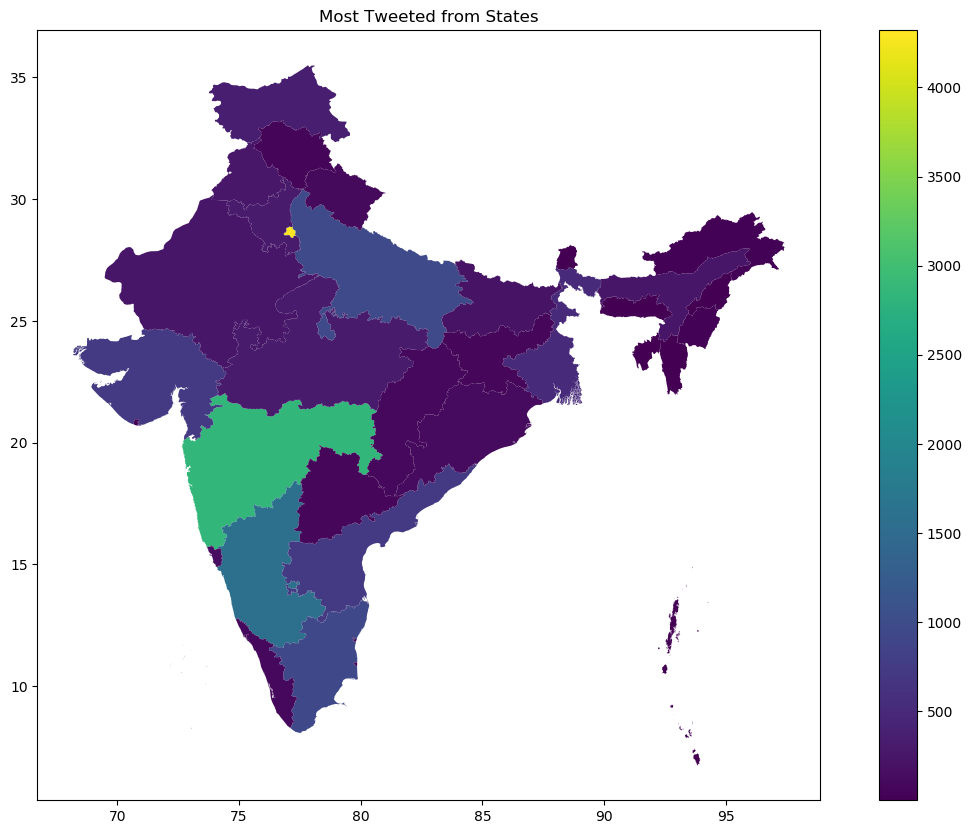

In [152]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
gdf.plot(column="Tweets",legend = True)
plt.title("Most Tweeted from States")

Text(0.5, 1, 'States tweeting about BJP')

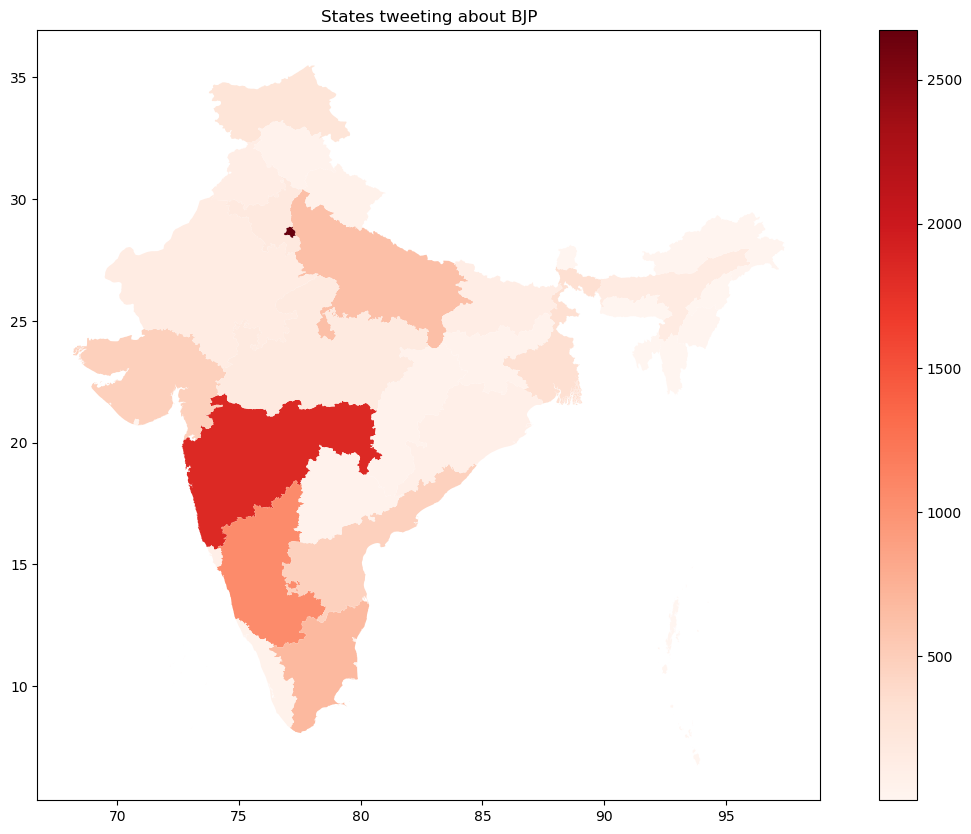

In [153]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
gdf.plot(column="BJP",legend = True,cmap="Reds")
plt.title("States tweeting about BJP")

Text(0.5, 1, 'States tweeting about Congress')

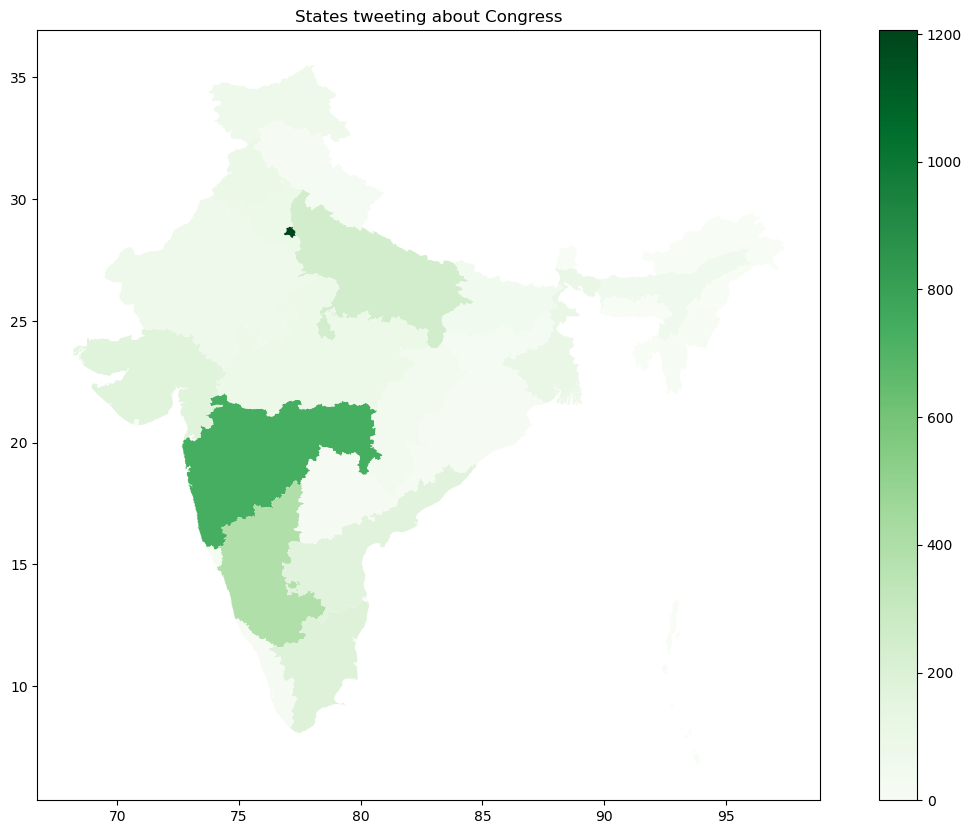

In [154]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
gdf.plot(column="Congress",legend = True,cmap="Greens")
plt.title("States tweeting about Congress")

Text(0.5, 1, 'States tweeting about Other Parties')

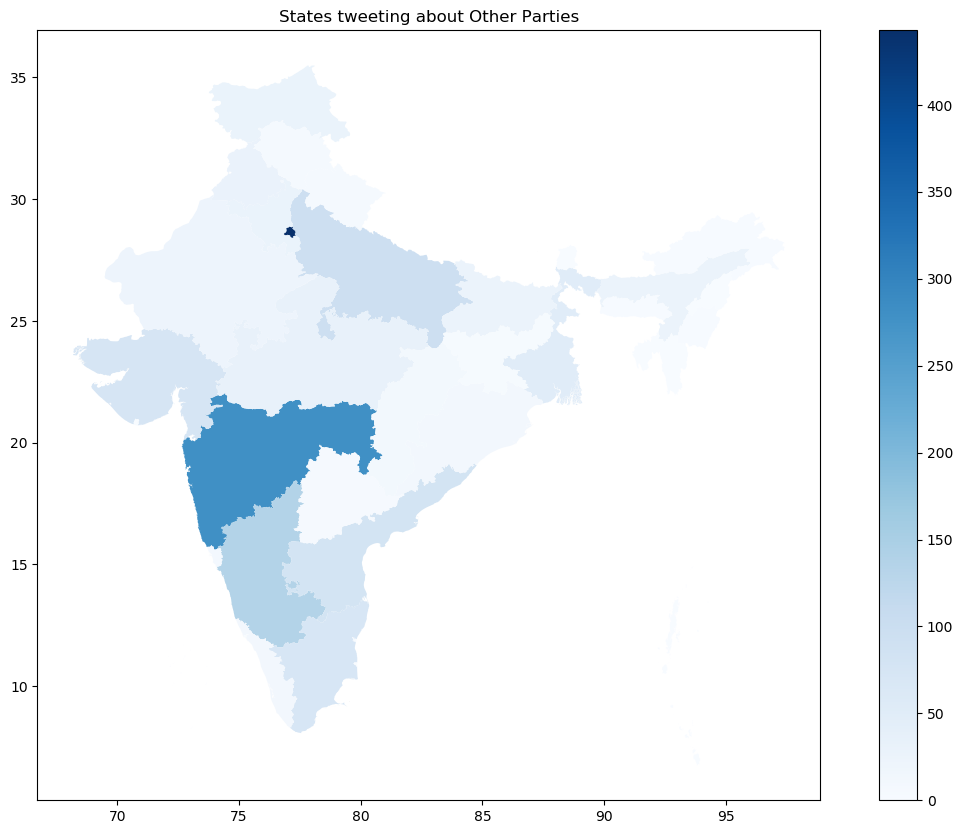

In [155]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
gdf.plot(column="Other",legend = True,cmap = "Blues")
plt.title("States tweeting about Other Parties")

Text(0.5, 1, 'Popularity Trend Across States')

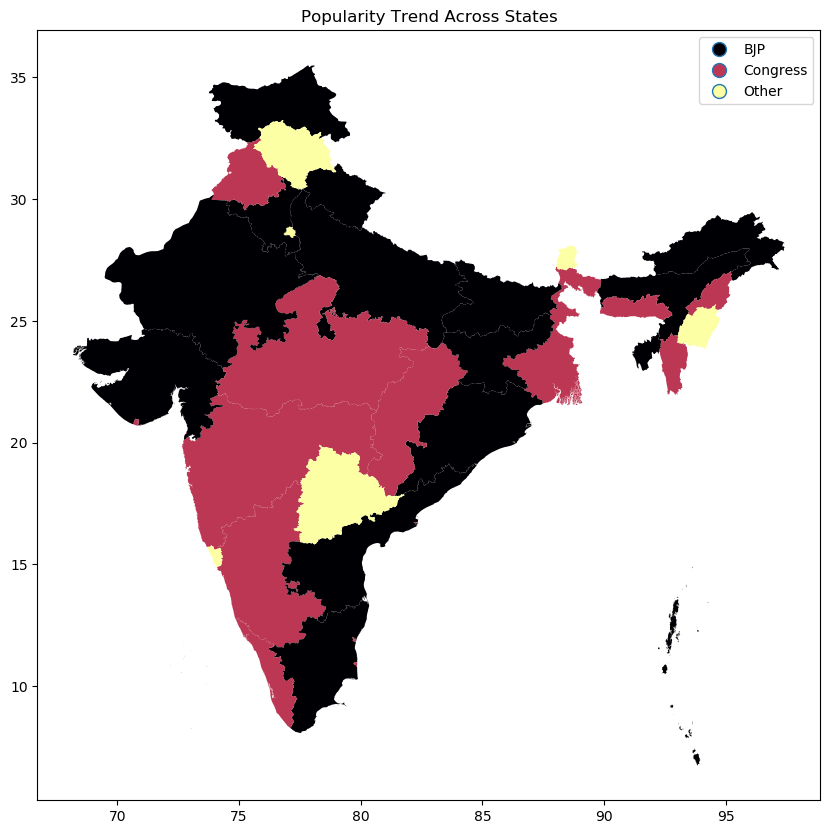

In [156]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
gdf.plot(column="Party",legend = True,cmap="inferno")
plt.title("Popularity Trend Across States")

Text(0.5, 1, 'BJP Popularity')

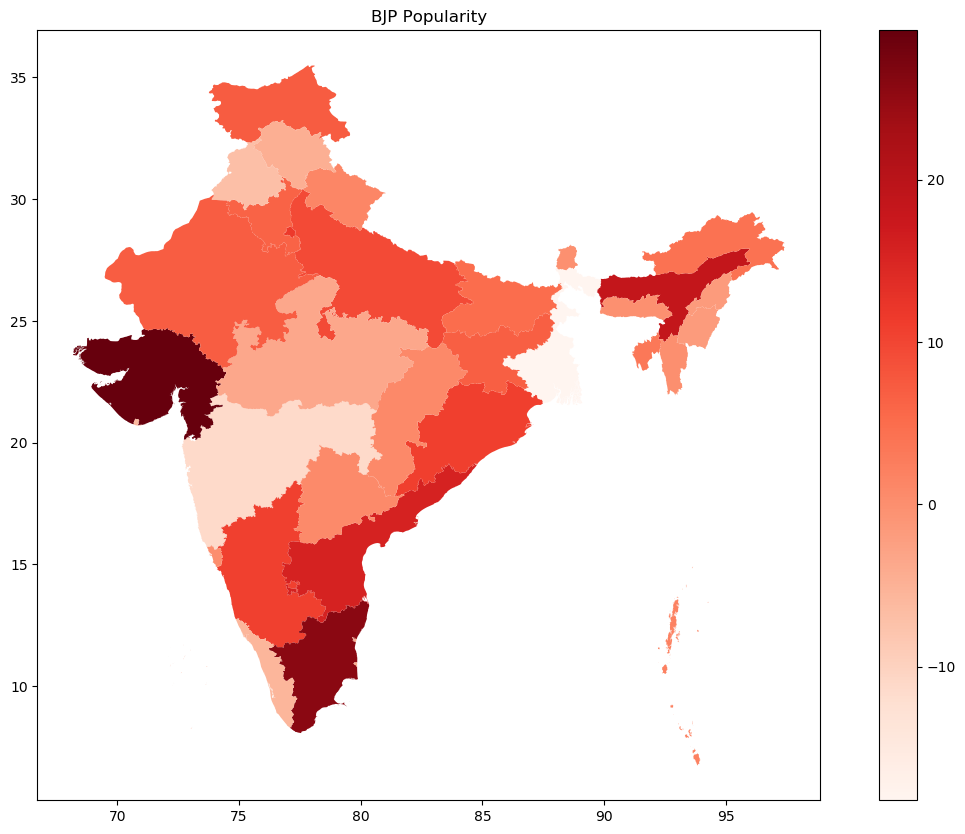

In [157]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
gdf.plot(column="BJPPop",cmap="Reds",legend = True)
plt.title("BJP Popularity")

Text(0.5, 1, 'Congress Popularity')

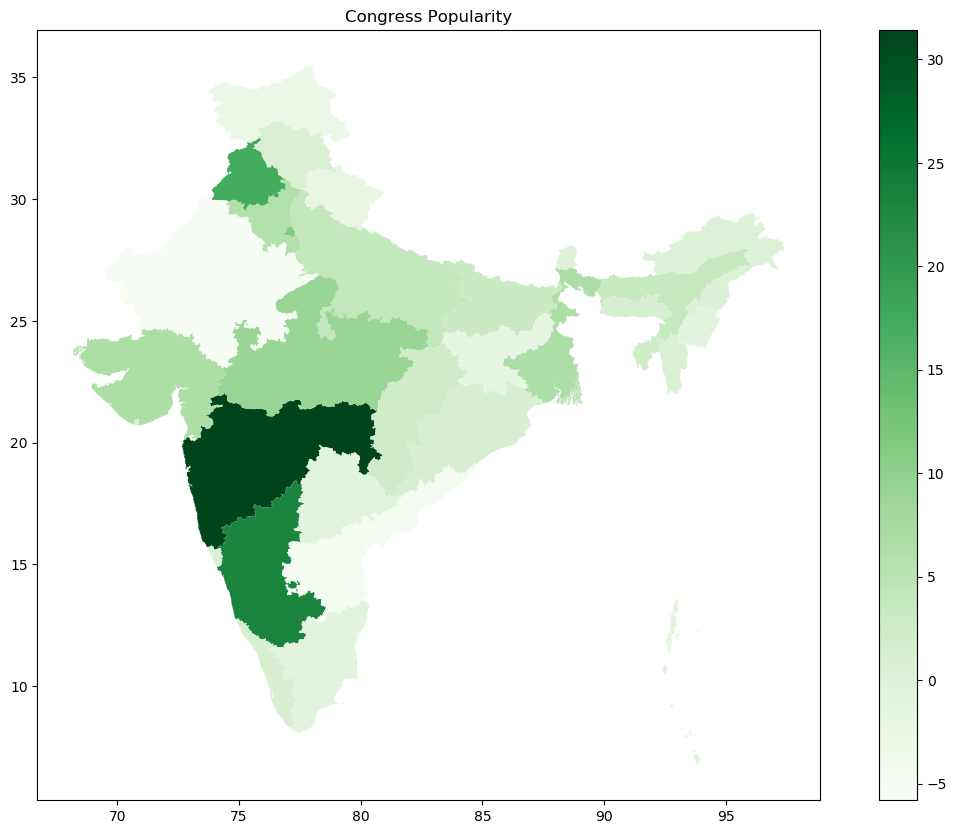

In [158]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
gdf.plot(column="Congpop",cmap="Greens",legend = True)
plt.title("Congress Popularity")

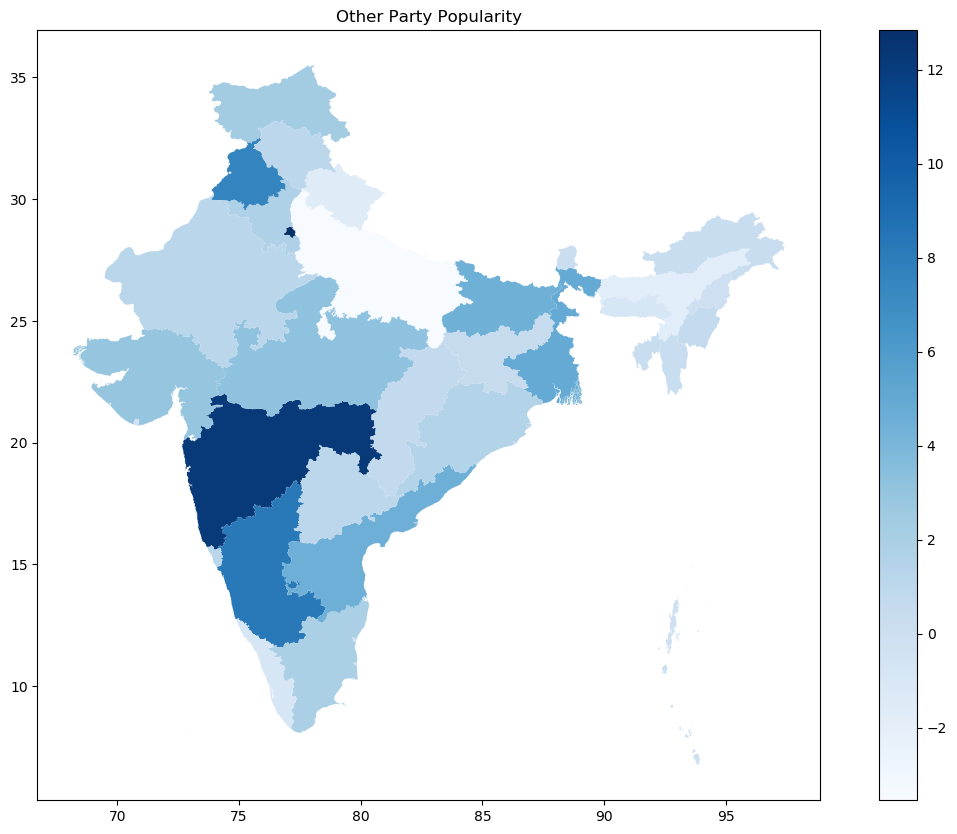

In [159]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
gdf.plot(column="OtherPop",cmap="Blues",legend = True)
plt.title("Other Party Popularity")
plt.show()

# Most Tweeted from Cities

In [160]:
city_count = dict(df["City"].value_counts())
city_count["Other"] = 0
del city_count[""]
most_city_count = dict()
most_city_count["Other"] = 0

In [161]:
for i in city_count:
    if city_count[i]<200:
        most_city_count["Other"]+=city_count[i]
    else:
        most_city_count[i] = city_count[i]

Text(0.5, 1.0, 'Most Tweeted from Cities')

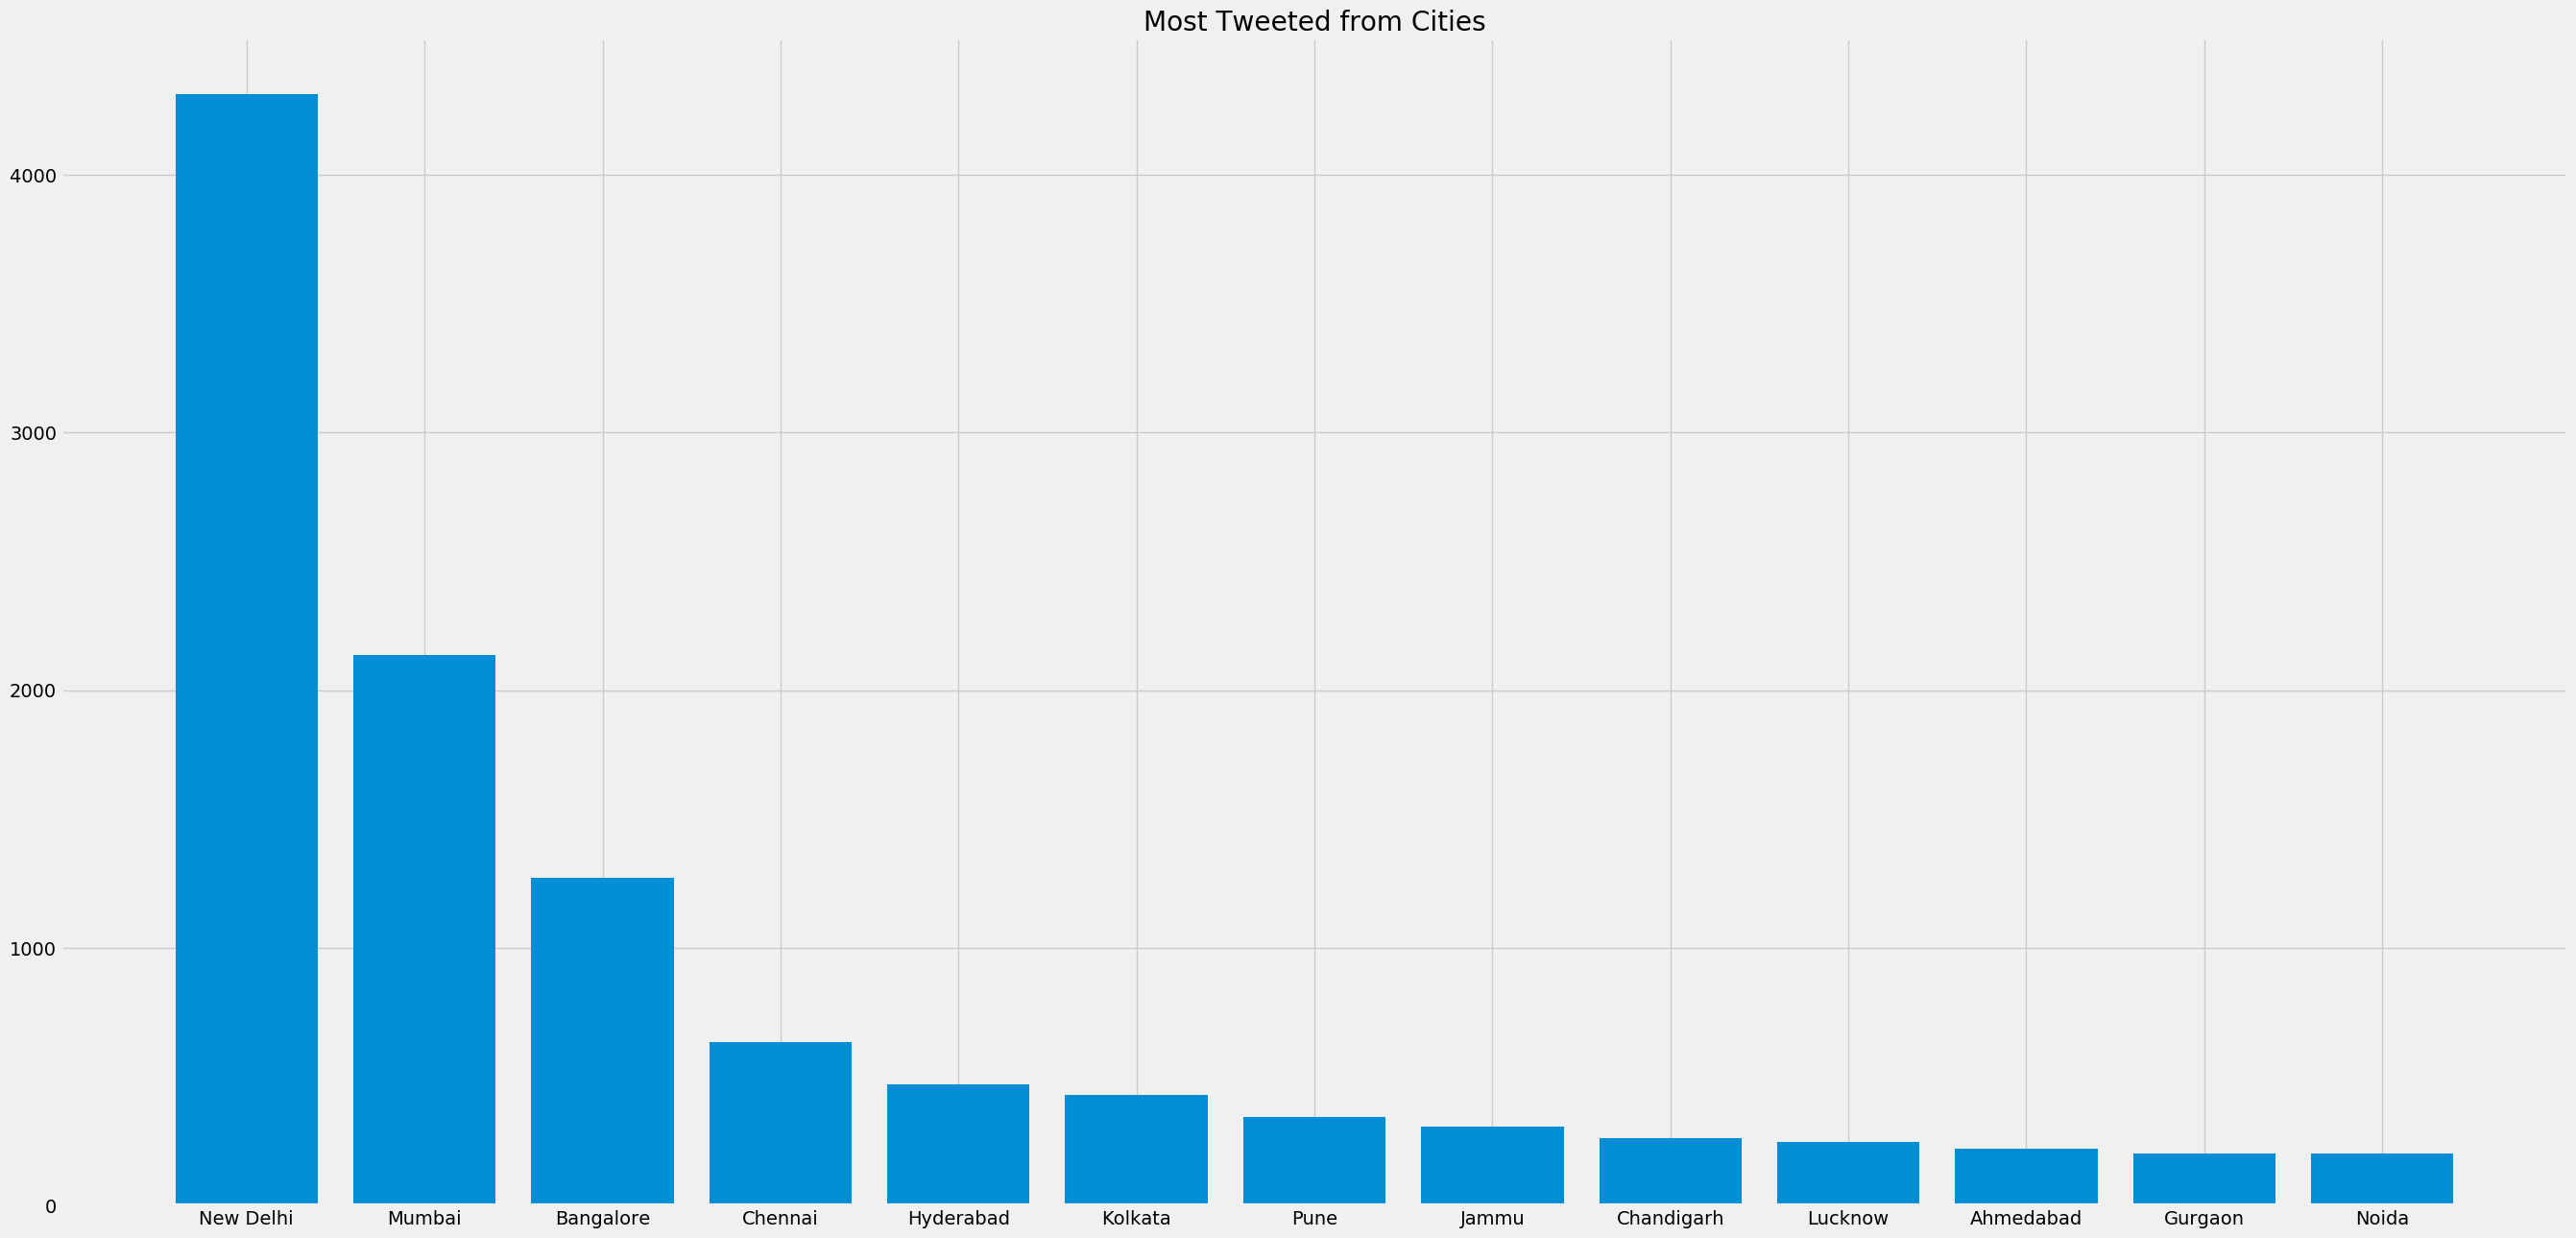

In [162]:
del most_city_count["Other"]
plt.rcParams["figure.figsize"] = [30,15]
plt.style.use('fivethirtyeight')
fig = plt.bar(list(most_city_count.keys()),list(most_city_count.values()),width = 0.8)
plt.title("Most Tweeted from Cities")

# Most Popular Hashtags

In [163]:
hashtags = []
for i in list(df["hashtags"]):
    x = i.split(',')
    for j in x:
        hashtags.append(j)
hashdata = [i for i in hashtags if i!=""]

In [164]:
hash_count = dict()
hash_count["Other"] = 0
for i in set(hashtags):
    x = hashtags.count(i)
    if x<60: #70 is best count
        hash_count["Other"]+= x
    else:
        hash_count[i] = x
del hash_count[""]
del hash_count["Other"]

Text(0.5, 1.0, 'Most Popular Hashtags')

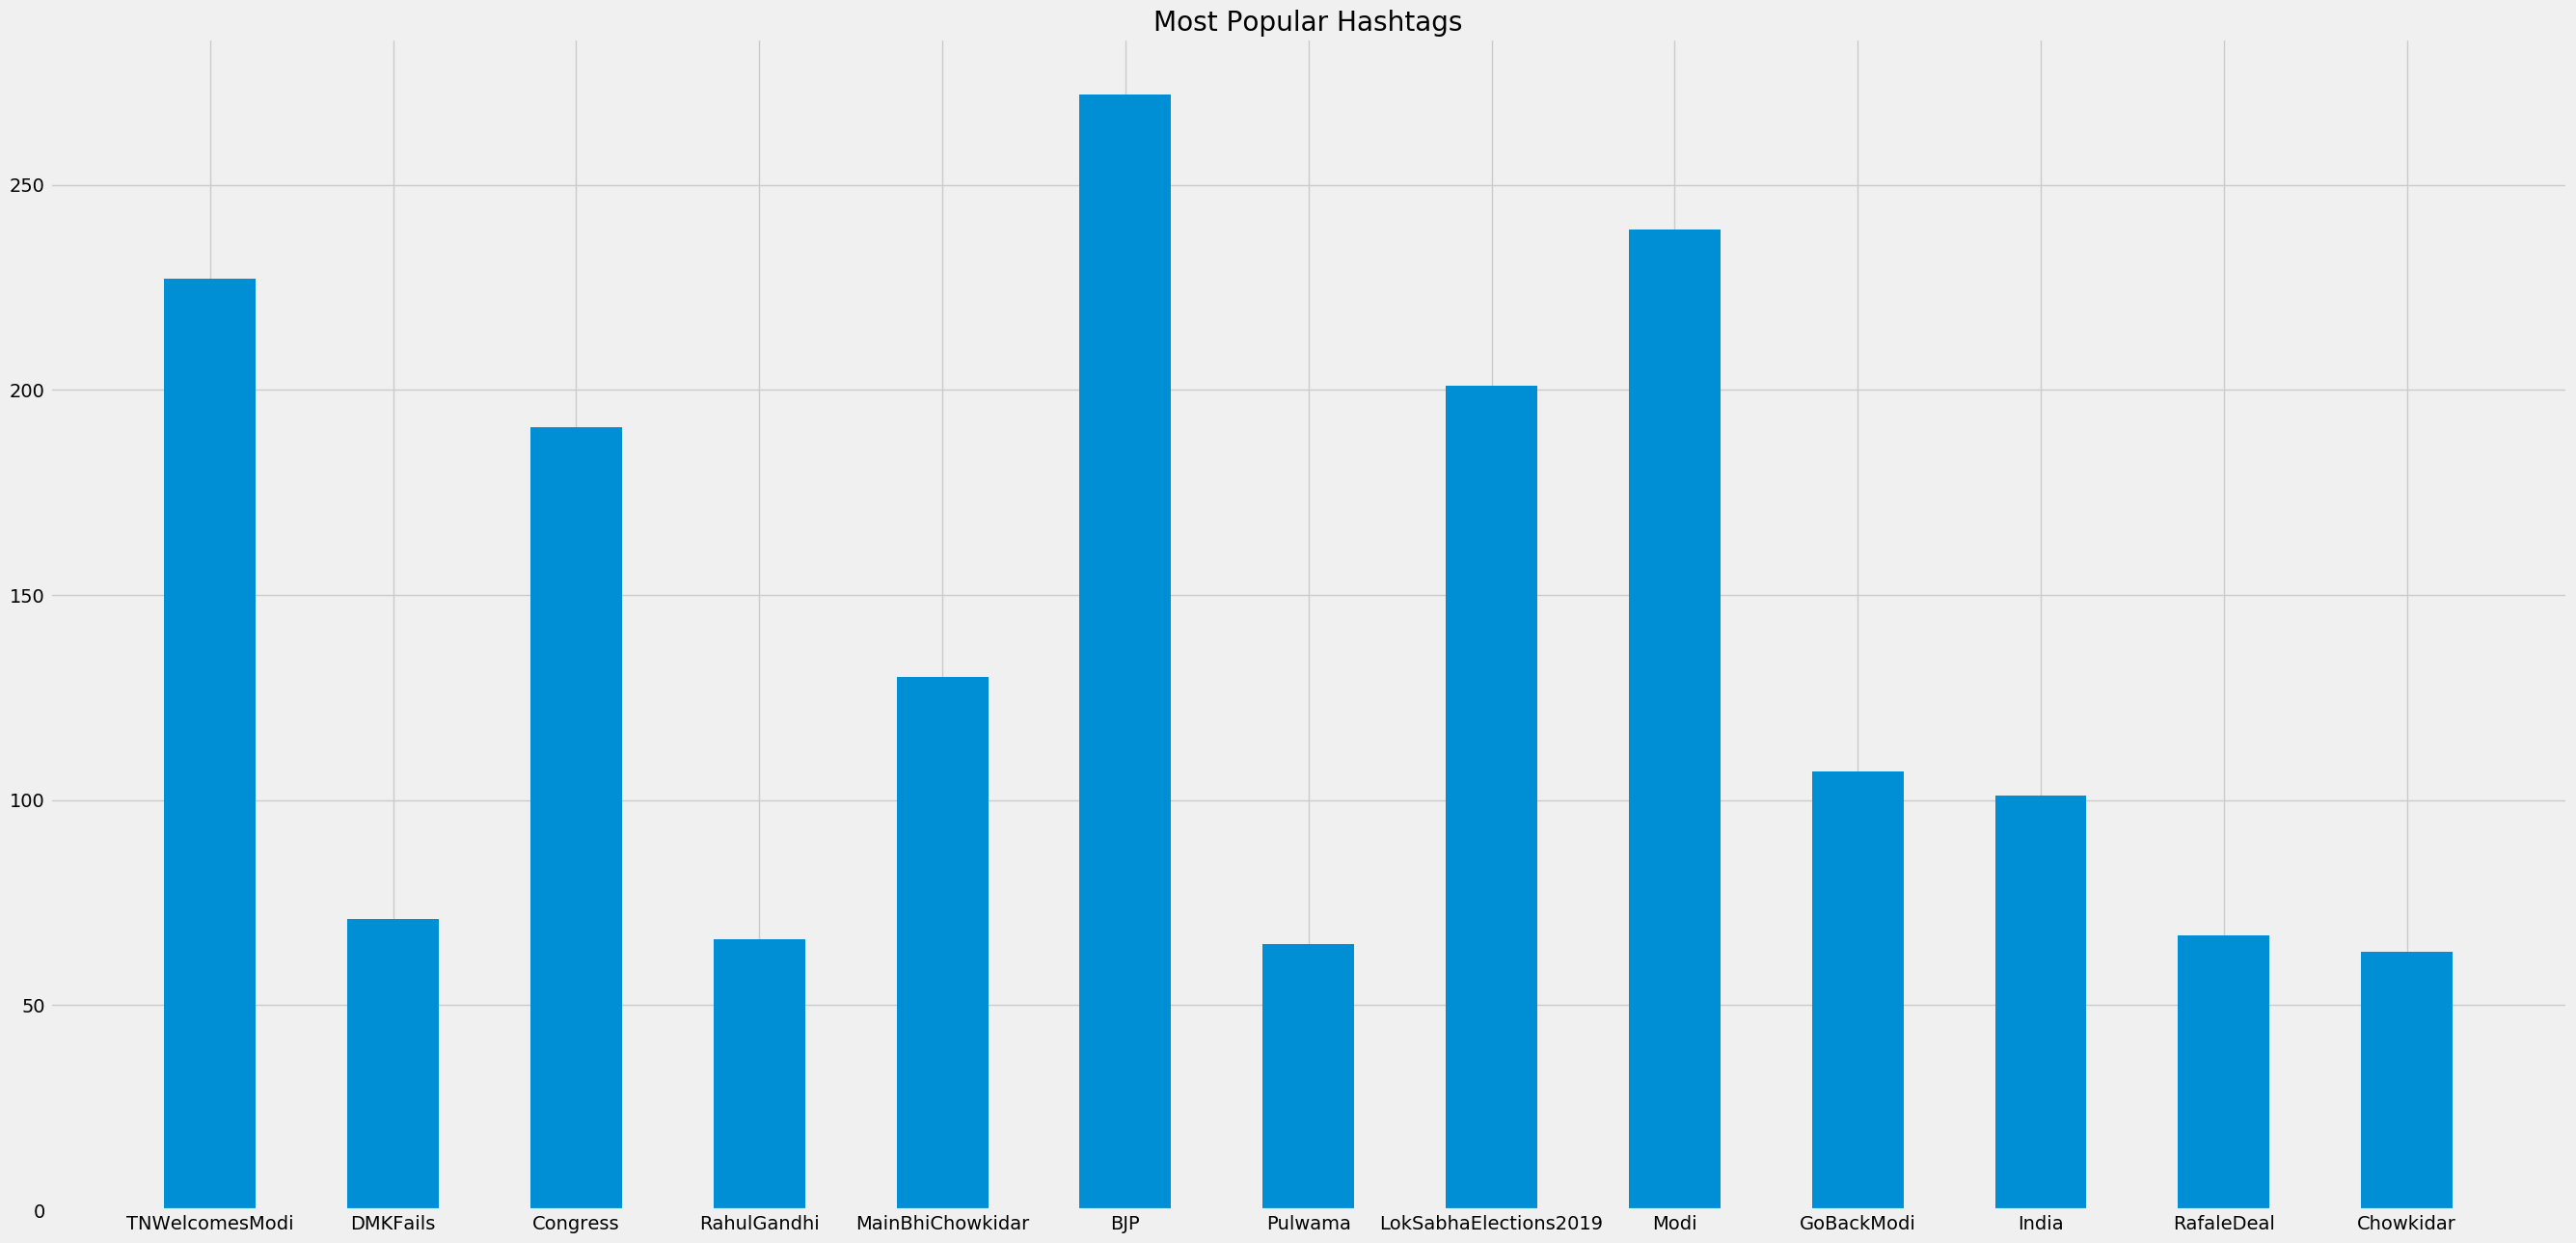

In [165]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = [30,15]
fig = plt.bar(list(hash_count.keys()),list(hash_count.values()),width = 0.5)
plt.title("Most Popular Hashtags")

Text(0.5, 1, '#BJP')

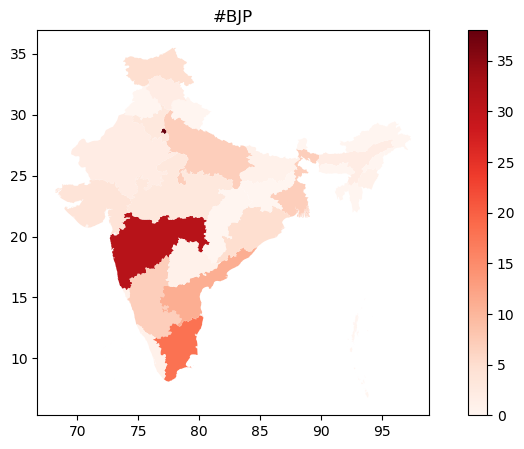

In [166]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="#BJP",legend = True,cmap="Reds")
plt.title("#BJP")

Text(0.5, 1, '#Modi')

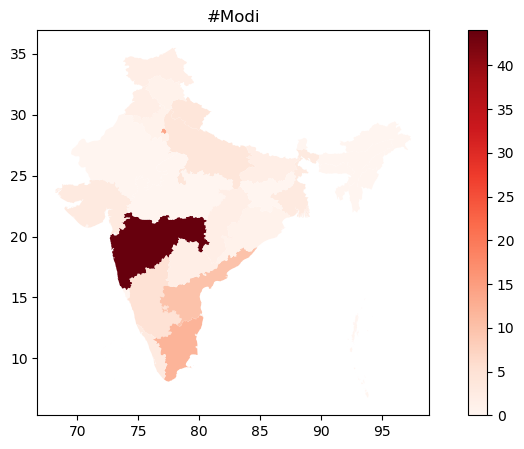

In [167]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="#Modi",legend = True,cmap="Reds")
plt.title("#Modi")

Text(0.5, 1, '#Congress')

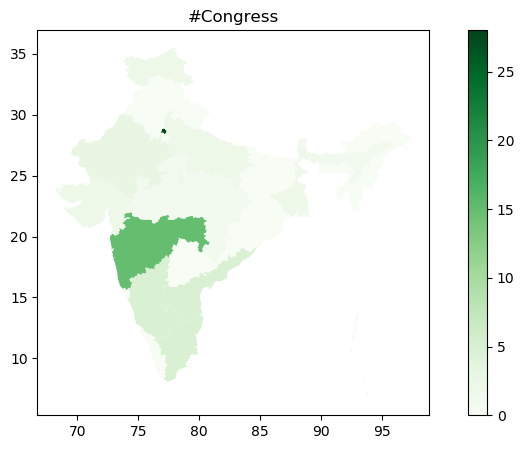

In [168]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="#Congress",legend = True,cmap="Greens")
plt.title("#Congress")

Text(0.5, 1, '#RahulGandhi')

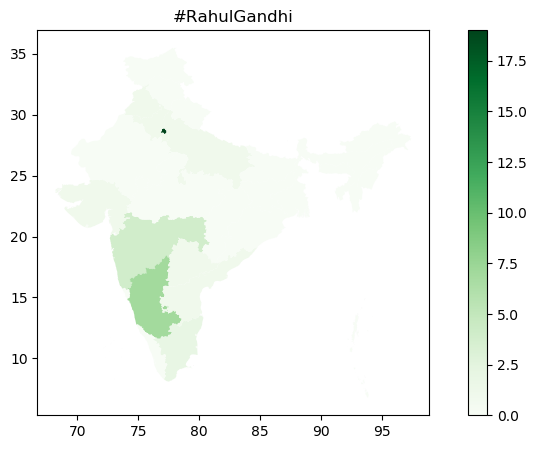

In [169]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="#RahulGandhi",legend = True,cmap="Greens")
plt.title("#RahulGandhi")

Text(0.5, 1, '#MainBhiChowkidar')

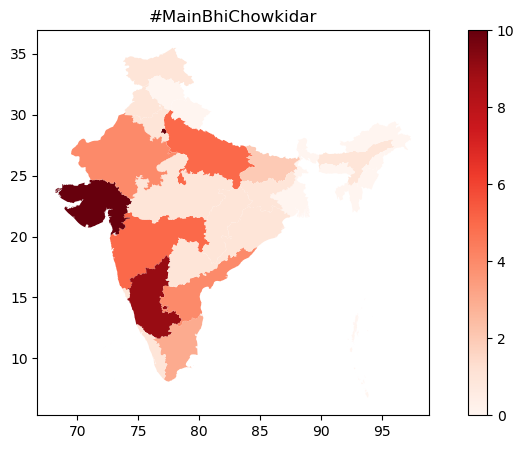

In [170]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="#MainBhiChowkidar",legend = True,cmap="Reds")
plt.title("#MainBhiChowkidar")

Text(0.5, 1, '#LokSabhaElections2019')

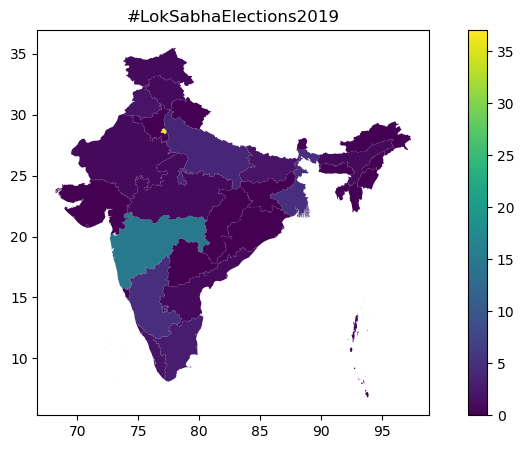

In [171]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="#LokSabhaElections2019",legend = True)
plt.title("#LokSabhaElections2019")

# Most Tagged Handles

In [172]:
handles = []
for i in df["user_mentions_screen_name"]:
    x = i.split(',')
    for j in x:
        handles.append(j)
handles = [i for i in handles if i!=""]

In [173]:
handle_count = dict()
handle_count["Other"] = 0
for i in set(handles):
    x = handles.count(i)
    if x<120:
        handle_count["Other"]+= x
    else:
        handle_count[i] = x
#del handle_count[""]
del handle_count["Other"]

Text(0.5, 1.0, 'Most Tagged Handles')

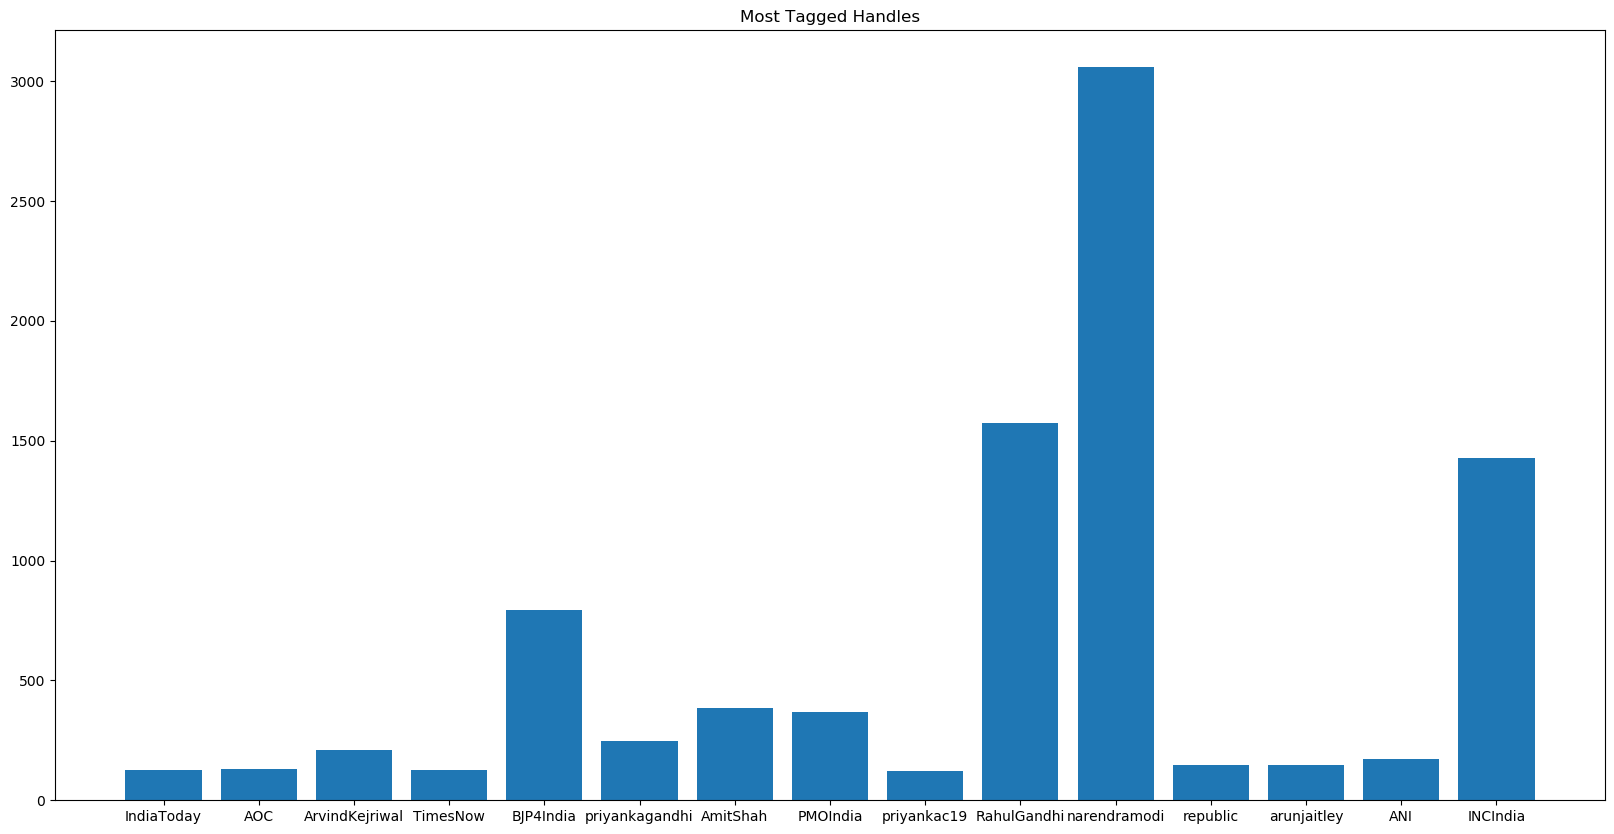

In [174]:
plt.rcParams["figure.figsize"] = [20,10]
fig = plt.bar(list(handle_count.keys()),list(handle_count.values()),width = 0.8)
plt.title("Most Tagged Handles")

Text(0.5, 1, 'People tagging @Modi')

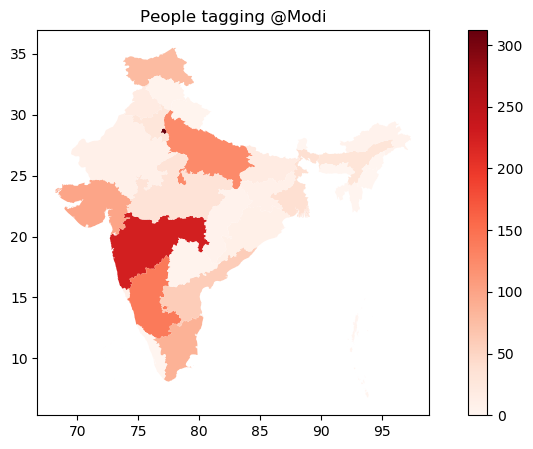

In [175]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="@narendramodi",legend = True,cmap="Reds")
plt.title("People tagging @Modi")

Text(0.5, 1, 'People tagging @BJP4India')

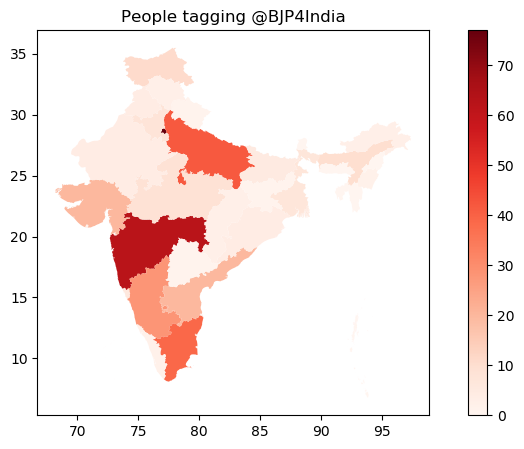

In [176]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="@BJP4India",legend = True,cmap="Reds")
plt.title("People tagging @BJP4India")

Text(0.5, 1, 'People tagging @Congress')

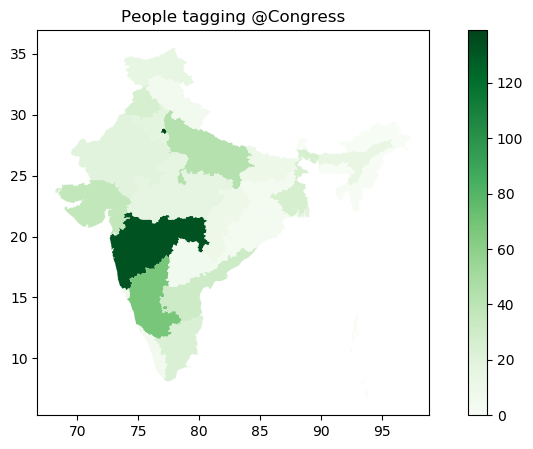

In [177]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="@INCIndia",legend = True,cmap="Greens")
plt.title("People tagging @Congress")

Text(0.5, 1, 'People tagging @RahulGandhi')

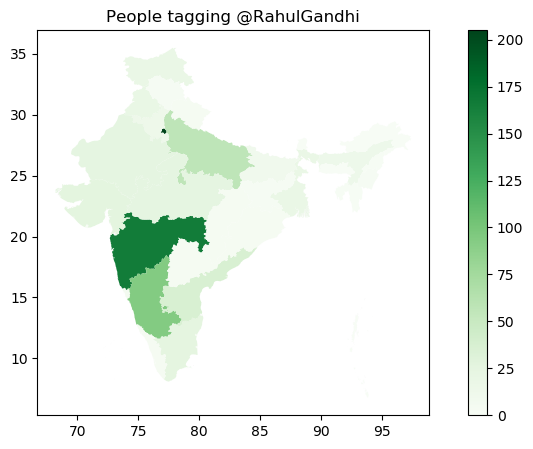

In [178]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [10,5]
gdf.plot(column="@RahulGandhi",legend = True,cmap="Greens")
plt.title("People tagging @RahulGandhi")

# Frequency of Tweets per Day

In [179]:
tweets_per_day = dict()
for i in all_days:
    tweets_per_day[i]=0
for i in range(0,39874):
    tweets_per_day[df["last_updated"][i].date()]+=1

In [180]:
temp = dict()
for i in tweets_per_day:
    if tweets_per_day[i]!=0:
        temp[i] = tweets_per_day[i]
        #tweets_per_day[i] = tweets_per_day[i-timedelta(days=1)]     
tweets_per_day = temp

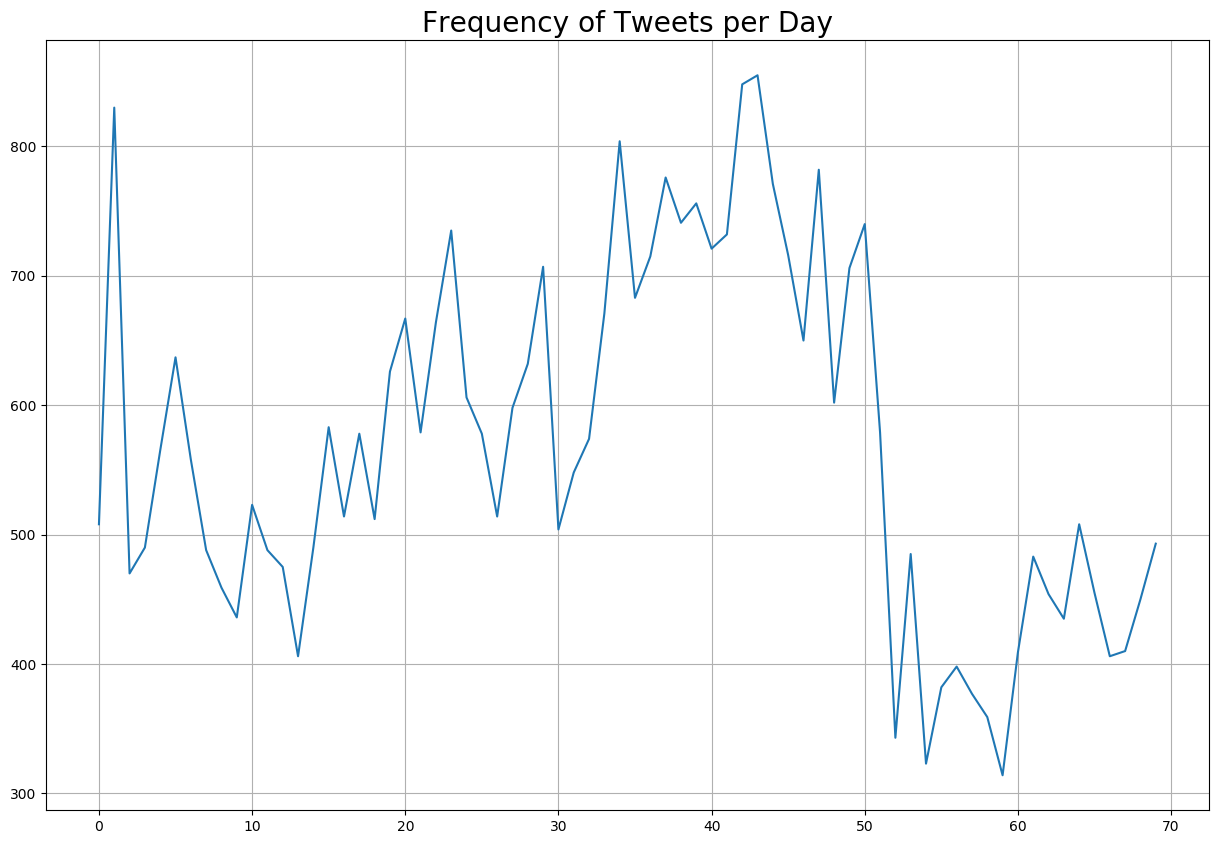

In [181]:
plt.rcParams["figure.figsize"] = [15,10]
plt.plot([i  for i in range(len(tweets_per_day.keys()))],list(tweets_per_day.values()))
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(20,20))
ax = plt.gca()
plt.grid(True)
plt.title("Frequency of Tweets per Day")
#plt.legend( loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()
plt.close()

# Tagging Frequency over Time

In [182]:
ht = ["narendramodi","BJP4India","RahulGandhi","INCIndia"]
ht_time = dict()
for i in all_days:
    ht_time[i] = {"narendramodi":0,"BJP4India":0,"RahulGandhi":0,"INCIndia":0}

In [183]:
for i in range(0,39874):
    t = df["last_updated"][i].date()
    temp = df["user_mentions_screen_name"][i].split(',')
    for j in temp:
        if j in ht:
            ht_time[t][j]+=1

In [184]:
modi_tag1 = []
bjp_tag1 = []
rahulgandhi_tag1 = []
cong_tag1 = []
modi_tag2 = []
bjp_tag2 = []
rahulgandhi_tag2 = []
cong_tag2 = []

for t in ht_time:
    temp = ht_time[t]
    try:
        modi_tag1.append(temp["narendramodi"])
        modi_tag2.append(modi_tag2[-1]+temp["narendramodi"])
    except:
        modi_tag2.append(0+temp["narendramodi"])
        
for t in ht_time:
    temp = ht_time[t]
    try:
        bjp_tag1.append(temp["BJP4India"])
        bjp_tag2.append(bjp_tag2[-1]+temp["BJP4India"])
    except:
        bjp_tag2.append(0+temp["BJP4India"])
        
for t in ht_time:
    temp = ht_time[t]
    try:
        rahulgandhi_tag1.append(temp["RahulGandhi"])
        rahulgandhi_tag2.append(rahulgandhi_tag2[-1]+temp["RahulGandhi"])
    except:
        rahulgandhi_tag2.append(0+temp["RahulGandhi"])
        
for t in ht_time:
    temp = ht_time[t]
    try:
        cong_tag1.append(temp["INCIndia"])
        cong_tag2.append(cong_tag2[-1]+temp["INCIndia"])
    except:
        cong_tag2.append(0+temp["INCIndia"])
        
        
tagged_scores = {"narendramodi":[modi_tag1,modi_tag2],"BJP4India":[bjp_tag1,bjp_tag2],
                "RahulGandhi":[rahulgandhi_tag1,rahulgandhi_tag2],"INCIndia":[cong_tag1,cong_tag2]}

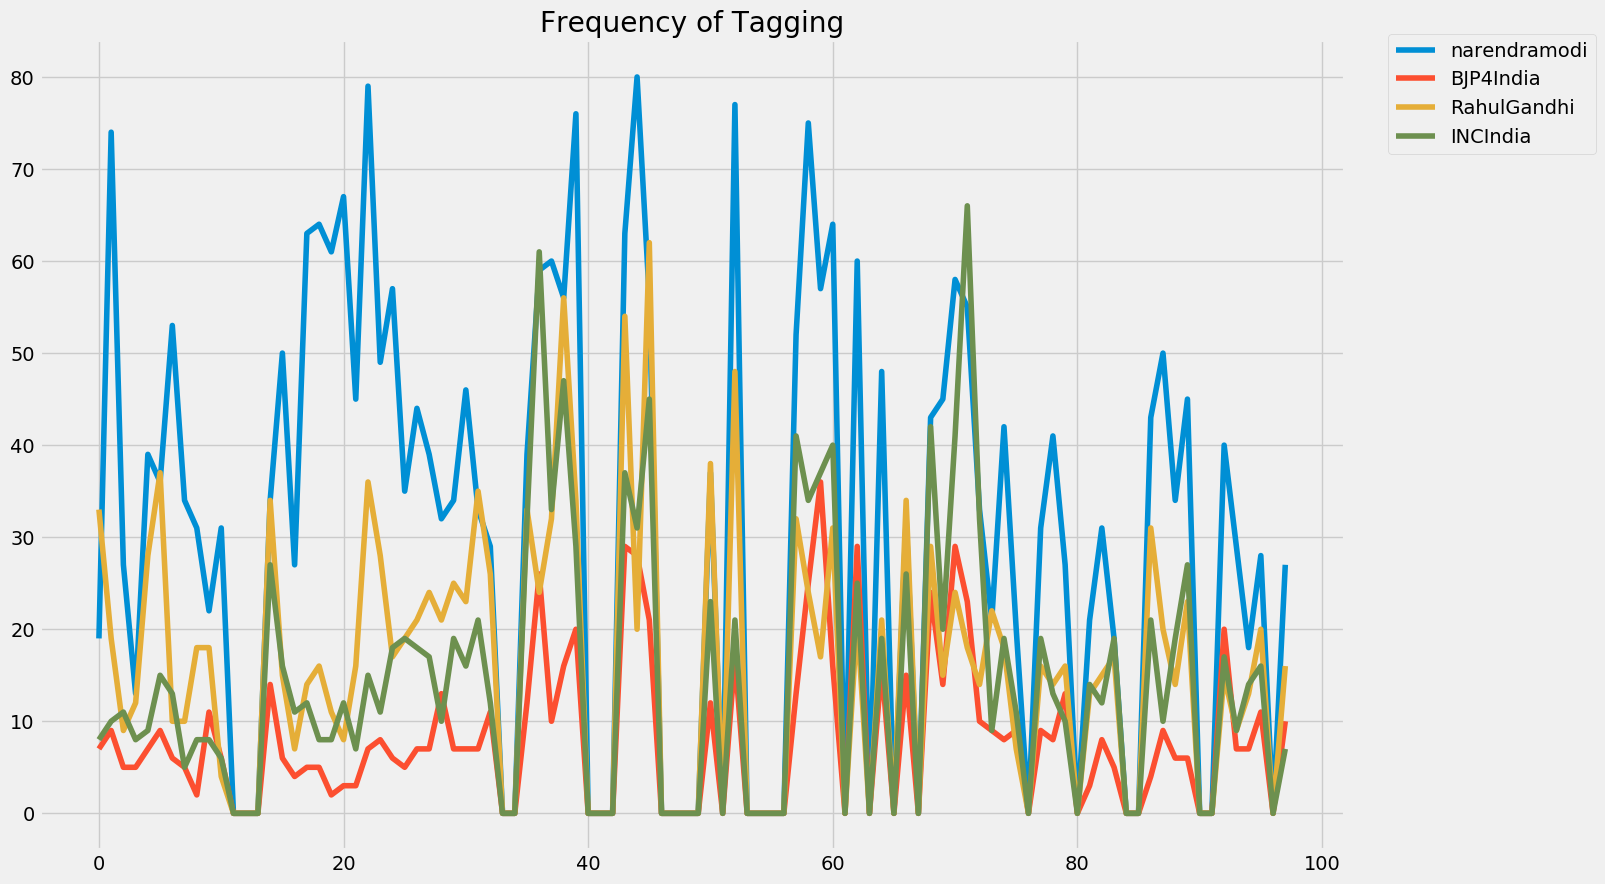

In [185]:
plt.figure(num ='Lok Sabha')
plt.rcParams["figure.figsize"] = [15,10]
for i in ht:
    plt.plot([i  for i in range(0,98)],tagged_scores[i][0],label = i)
plt.style.use('fivethirtyeight')
plt.title("Frequency of Tagging")
plt.grid(True)
ax = plt.gca()
plt.legend(loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()
plt.close()

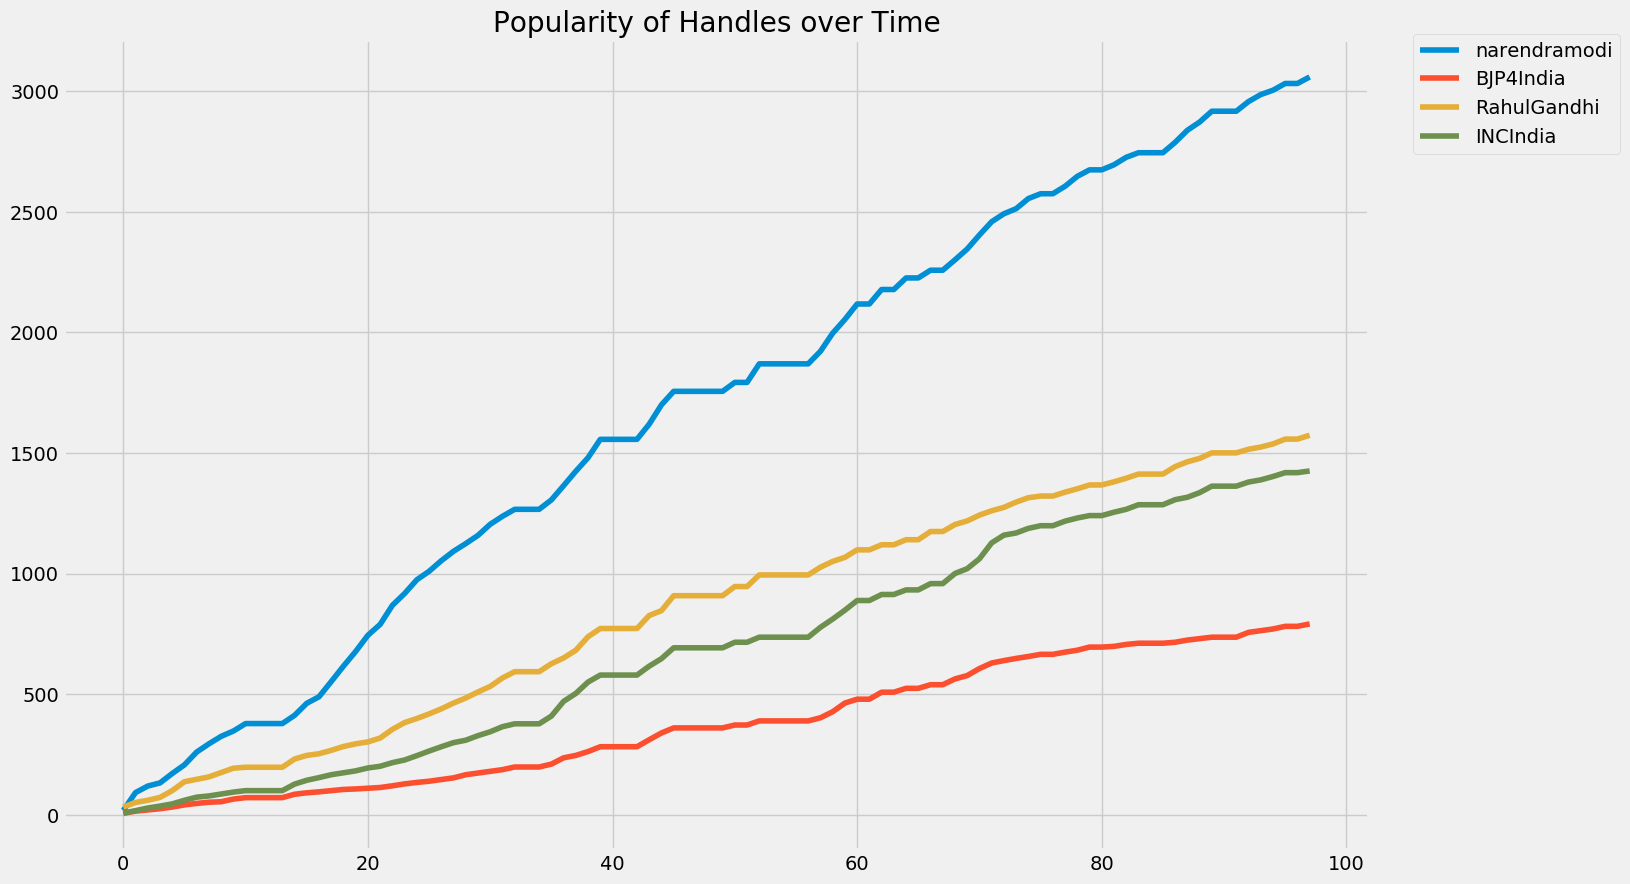

In [186]:
plt.figure(num ='Lok Sabha')
plt.rcParams["figure.figsize"] = [15,5]
for i in ht:
    plt.plot([i  for i in range(0,98)],tagged_scores[i][1],label = i)
plt.style.use('fivethirtyeight')
plt.title("Popularity of Handles over Time")
plt.grid(True)
ax = plt.gca()
plt.legend(loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()
plt.close()

# Discrete Probabilites

In [187]:
vote_score = dict()
for i in all_days:
  vote_score[i] = {"bjp_votes":0, "cong_votes":0, "other_votes":0, "cong_coal":0, "bjp_coal":0,"total":0}
#bjp_votes, cong_votes, other_votes, cong_coal, bjp_coal = [0 for i in range(5)]
total = 0
for i in range(0,39874):
  t = df["last_updated"][i].date()
  party = df["Party"][i]
  score = df["Score"][i]
  scoreadd=1
  if party=="BJP":
    if score>0:
      vote_score[t]["bjp_votes"]+=scoreadd
      vote_score[t]["total"]+=1
    else:
      if score >=-0.4 and score <=0:
        vote_score[t]["cong_coal"]+=scoreadd
        vote_score[t]["total"]+=1
      else:
        vote_score[t]["cong_votes"]+=scoreadd
        vote_score[t]["total"]+=1
  elif party=="Congress":
    if score>0:
      vote_score[t]["cong_votes"]+=scoreadd
      vote_score[t]["total"]+=1
    else:
      if score >=-0.4 and score <=0:
        vote_score[t]["bjp_coal"]+=scoreadd
        vote_score[t]["total"]+=1
      else:
        vote_score[t]["bjp_votes"]+=scoreadd
        vote_score[t]["total"]+=1
  else:
    if score>0:
      vote_score[t]["other_votes"]+=scoreadd
      vote_score[t]["total"]+=1
    elif score >=-0.4 and score <=0:
      if vote_score[t]["bjp_votes"]>vote_score[t]["cong_votes"]:
        vote_score[t]["bjp_coal"]+=scoreadd
        vote_score[t]["total"]+=1
      else:
        vote_score[t]["cong_coal"]+=scoreadd
        vote_score[t]["total"]+=1

In [188]:
vote_bjp1, vote_cong1, vote_other1, vote_bjp_coal1, vote_cong_coal1 = [],[],[],[],[]
vote_bjp2, vote_cong2, vote_other2, vote_bjp_coal2, vote_cong_coal2 = [],[],[],[],[]
temp = dict()
for i in vote_score:
    if vote_score[i]["total"]!=0:
        temp[i] = vote_score[i]
vote_score=temp
for t in vote_score:
  if vote_score[t]['total']==0:
    continue
  vote_bjp1.append((vote_score[t]["bjp_votes"]/vote_score[t]["total"]))
  try:
    vote_bjp2.append((vote_score[t]["bjp_votes"]+vote_bjp2[-1])/(vote_score[t]["total"]+vote_score[t-timedelta(days=1)]["total"]))
  except:
    vote_bjp2.append((vote_score[t]["bjp_votes"]/vote_score[t]["total"]))

for t in vote_score:
  if vote_score[t]['total']==0:
    continue
  vote_cong1.append((vote_score[t]["cong_votes"]/vote_score[t]["total"]))
  try:
    vote_cong2.append((vote_score[t]["cong_votes"]+vote_cong2[-1])/(vote_score[t]["total"]+vote_score[t-timedelta(days=1)]["total"]))
  except:
    vote_cong2.append((vote_score[t]["cong_votes"]/vote_score[t]["total"]))

for t in vote_score:
  if vote_score[t]['total']==0:
    continue
  vote_other1.append((vote_score[t]["other_votes"]/vote_score[t]["total"]))
  try:
    vote_other2.append((vote_score[t]["other_votes"]+vote_other2[-1])/(vote_score[t]["total"]+vote_score[t-timedelta(days=1)]["total"]))
  except:
    vote_other2.append((vote_score[t]["other_votes"]/vote_score[t]["total"]))

for t in vote_score:
  if vote_score[t]['total']==0:
    continue
  vote_bjp_coal1.append((vote_score[t]["bjp_coal"]/vote_score[t]["total"]))
  try:
    vote_bjp_coal2.append((vote_score[t]["bjp_coal"]+vote_bjp_coal2[-1])/(vote_score[t]["total"]+vote_score[t-timedelta(days=1)]["total"]))
  except:
    vote_bjp_coal2.append((vote_score[t]["bjp_coal"]/vote_score[t]["total"]))

for t in vote_score:
  if vote_score[t]['total']==0:
    continue
  vote_cong_coal1.append((vote_score[t]["cong_coal"]/vote_score[t]["total"]))
  try:
    vote_cong_coal2.append((vote_score[t]["cong_coal"]+vote_cong_coal2[-1])/(vote_score[t]["total"]+vote_score[t-timedelta(days=1)]["total"]))
  except:
    vote_cong_coal2.append((vote_score[t]["cong_coal"]/vote_score[t]["total"]))    

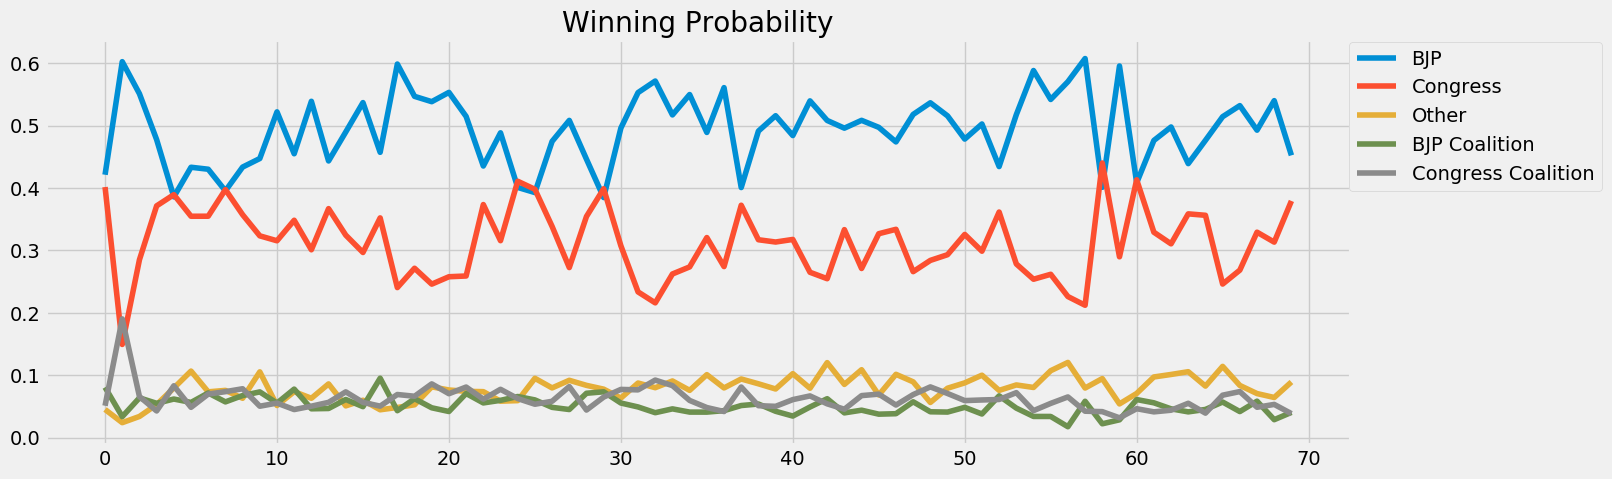

In [189]:
plt.figure(num ='Lok Sabha')
plt.rcParams["figure.figsize"] = [15,5]
labels = ["BJP","Congress","Other","BJP Coalition","Congress Coalition"]
x = [vote_bjp1, vote_cong1, vote_other1, vote_bjp_coal1, vote_cong_coal1]
for i in x:
    plt.plot([j  for j in range(len(i))],i,label= labels[x.index(i)])
plt.style.use('fivethirtyeight')
plt.title("Winning Probability")
plt.grid(True)
ax = plt.gca()
plt.legend(loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()
plt.close()

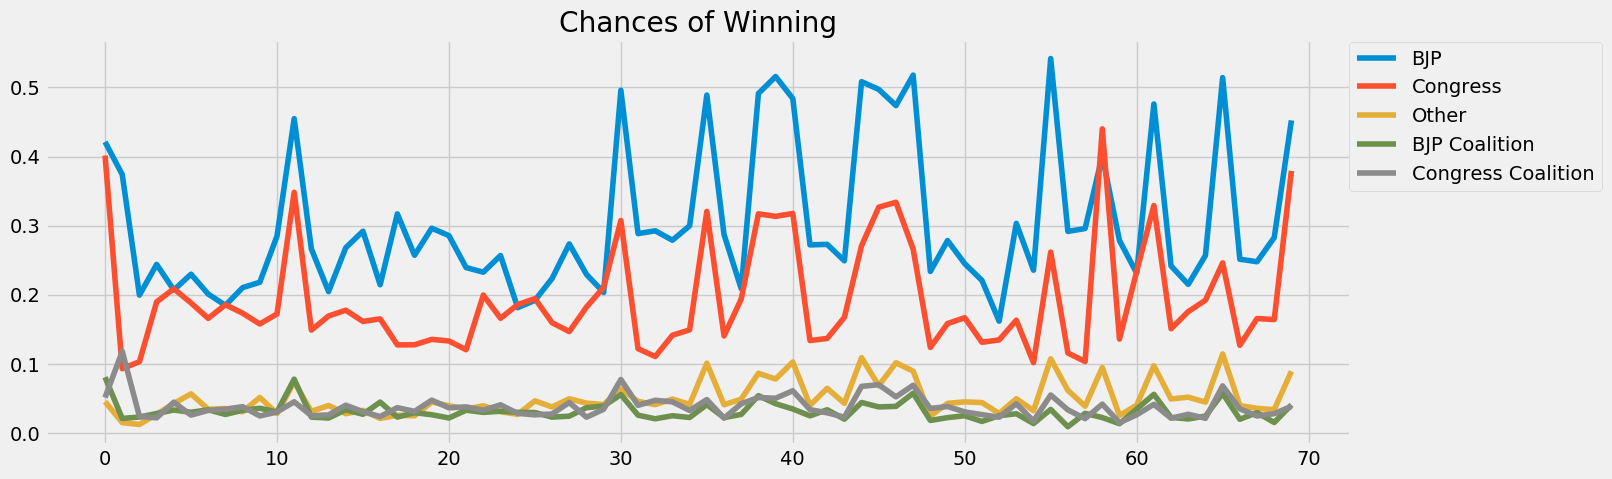

In [190]:
plt.figure(num ='Lok Sabha')
plt.rcParams["figure.figsize"] = [15,5]
labels = ["BJP","Congress","Other","BJP Coalition","Congress Coalition"]
x = [vote_bjp2,vote_cong2, vote_other2, vote_bjp_coal2, vote_cong_coal2]
for i in x:
    plt.plot([j  for j in range(len(i))],i,label = labels[x.index(i)])
plt.style.use('fivethirtyeight')
plt.title("Chances of Winning")
plt.grid(True)
ax = plt.gca()
plt.legend(loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()
plt.close()

# Poisson

In [191]:
poisson = dict()
for i in all_days:
    poisson[i] = {"bjp":0,"cong":0,"other":0,"bjp_coal":0,"cong_coal":0}
for t in vote_score:
    poisson[t]["bjp"]=vote_score[t]["bjp_votes"]
    poisson[t]["cong"]=vote_score[t]["cong_votes"]
    poisson[t]["other"]=vote_score[t]["other_votes"]
    poisson[t]["bjp_coal"]=vote_score[t]["bjp_coal"]
    poisson[t]["cong_coal"]=vote_score[t]["cong_coal"]

In [192]:
finalposisson = {"bjp":0,"cong":0,"other":0,"bjp_coal":0,"cong_coal":0}
for t in poisson:
    finalposisson["bjp"]+=poisson[t]["bjp"]
    finalposisson["cong"]+=poisson[t]["cong"]
    finalposisson["other"]+=poisson[t]["other"]
    finalposisson["bjp_coal"]+=poisson[t]["bjp_coal"]
    finalposisson["cong_coal"]+=poisson[t]["cong_coal"]    

In [193]:
l = len(list(poisson.keys()))
for i in finalposisson:
    finalposisson["bjp"]/=98
    finalposisson["cong"]/=98
    finalposisson["other"]/=98
    finalposisson["bjp_coal"]/=98
    finalposisson["cong_coal"]/=98

In [194]:
finalposisson

{'bjp': 2.181275181387662e-06,
 'cong': 1.3713590885267261e-06,
 'other': 3.5058381345120976e-07,
 'bjp_coal': 2.2557286072168398e-07,
 'cong_coal': 2.82436249839362e-07}

In [195]:
from math import e,factorial

In [196]:
poissondist = []
y1,y2,y3,y4,y5 = [],[],[],[],[]
lam1 = finalposisson["bjp"]
lam2 = finalposisson["cong"]
lam3 = finalposisson["other"]
lam4 = finalposisson["bjp_coal"]
lam5 = finalposisson["cong_coal"]
for i in range(0,98):
    y1.append((((e**(-lam1))*(lam1**i))/factorial(i)))
    y2.append((((e**(-lam2))*(lam2**i))/factorial(i)))
    y3.append((((e**(-lam3))*(lam3**i))/factorial(i)))
    y4.append((((e**(-lam4))*(lam4**i))/factorial(i)))
    y5.append((((e**(-lam5))*(lam5**i))/factorial(i)))

No handles with labels found to put in legend.


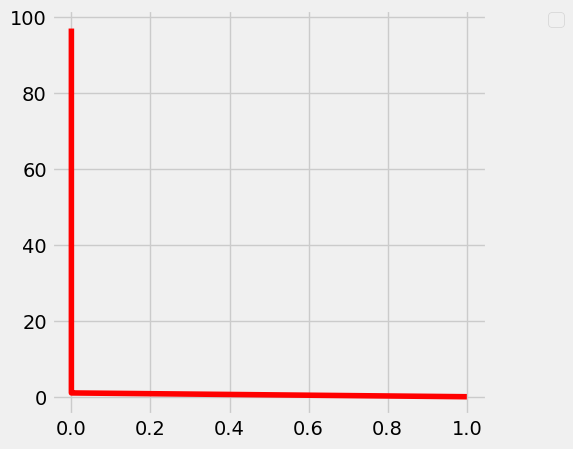

In [197]:
plt.rcParams["figure.figsize"] = [5,5]
plt.plot(y1,[i for i in range(0,98)],color = 'red')
ax = plt.gca()
plt.legend(loc='best', bbox_to_anchor=(1, 0,0.2, 1.02))
plt.show()

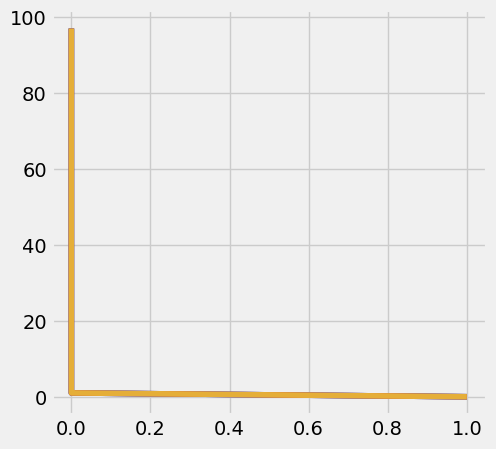

In [198]:
plt.plot(y2,[i for i in range(0,98)],color= 'blue')
plt.plot(y3,[i for i in range(0,98)])
plt.plot(y4,[i for i in range(0,98)])
plt.plot(y5,[i for i in range(0,98)])

# Mood Plots

In [199]:
filepath="NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df=pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(15)

word       emotion  association
0   abandonment           joy            0
1   abandonment      negative            1
2   abandonment      positive            0
3   abandonment       sadness            1
4   abandonment      surprise            1
5   abandonment         trust            0
6         abate         anger            0
7         abate  anticipation            0
8         abate       disgust            0
9         abate          fear            0
10        abate           joy            0
11        abate      negative            0
12        abate      positive            0
13        abate       sadness            0
14        abate      surprise            0

In [200]:
emotions={'BJP':{'positive':0, 'negative':0, 'surprise':0,'sadness':0,'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}, 
          'Congress':{'positive':0, 'negative':0,  'surprise':0,'sadness':0,'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0},
          'Other':{'positive':0, 'negative':0,  'surprise':0,'sadness':0,'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}}
    


In [201]:
word_emotion=dict()
for i in range(0,141776):
    emotion=emolex_df['emotion'][i]
    word=emolex_df['word'][i]
    association=emolex_df['association'][i]
    
    if word not in word_emotion:
        word_emotion[word]=dict()
    word_emotion[word][emotion]=association
    

In [202]:
for i in range(0,39874):
    party=df['Party'][i]
    text=df['full_text'][i]
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                emotions[party][k]+=word_emotion[j][k]


In [203]:
df.head()

last_updated      tweet_id          created_at  \
0 2019-02-08 17:29:00  1.090000e+18 2019-02-08 17:28:00   
1 2019-02-08 17:29:00  1.090000e+18 2019-02-07 05:10:00   
2 2019-02-08 17:30:00  1.090000e+18 2019-02-08 10:18:00   
3 2019-02-08 17:30:00  1.090000e+18 2019-02-08 17:29:00   
4 2019-02-08 17:30:00  1.090000e+18 2019-02-08 14:19:00   

                                           full_text  \
0  @DasComrade Sir any comment on modi's grand en...   
1  Congress made Vemula national talking point ev...   
2  BJP has been winning battles over the past mon...   
3  @inclusivemind2 @Ark82876233 @BJP4India @Rahul...   
4  Senior Congress leader @ManishTewari : There w...   

                                     processed_tweet     Party  quote_count  \
0             dascomrad sir comment modi grand entri       BJP          0.0   
1  congress made vemula nation talk point even th...       BJP         47.0   
2  bjp win battl past month bengal pm modi arriv ...       BJP          1.0   
3  inclusivemind ark bjpindia rahul gandhi bjp th...     Other          0.0   
4  senior congress leader manishtewari jpc defini...  Congress          0.0   

   reply_count  retweet_count  Importance  ...  Neutral  Positive  Negative  \
0          0.0            1.0           0  ...    0.625     0.375     0.000   
1         72.0         2353.0           1  ...    0.868     0.000     0.132   
2         12.0          513.0           1  ...    0.582     0.276     0.142   
3          0.0            2.0           0  ...    0.884     0.116     0.000   
4          1.0          159.0           1  ...    1.000     0.000     0.000   

   Compound  hashtags                         user_mentions_screen_name  \
0    0.4588                                                  DasComrade   
1   -0.5719                                                               
2    0.5719                                                               
3    0.4404            inclusivemind2,Ark82876233,BJP4India,RahulGandhi   
4    0.0000                                                ManishTewari   

        City          State Country       Score  
0   Guwahati          Assam   India    0.045645  
1     Mumbai    Maharashtra   India  108.990410  
2    Kolkata    West Bengal   India   24.487725  
3    Aligarh  Uttar Pradesh   India    0.091290  
4  New Delhi          Delhi   India    8.263217  

[5 rows x 21 columns]

In [204]:
emotions

{'BJP': {'positive': 21702,
  'negative': 18696,
  'surprise': 5289,
  'sadness': 8415,
  'anger': 10380,
  'joy': 7886,
  'trust': 14669,
  'fear': 10657,
  'anticipation': 10036,
  'disgust': 5195},
 'Congress': {'positive': 13267,
  'negative': 10688,
  'surprise': 2956,
  'sadness': 4673,
  'anger': 5718,
  'joy': 4414,
  'trust': 9727,
  'fear': 6004,
  'anticipation': 6178,
  'disgust': 4032},
 'Other': {'positive': 3389,
  'negative': 2717,
  'surprise': 766,
  'sadness': 1219,
  'anger': 1494,
  'joy': 1215,
  'trust': 2315,
  'fear': 1473,
  'anticipation': 1482,
  'disgust': 797}}

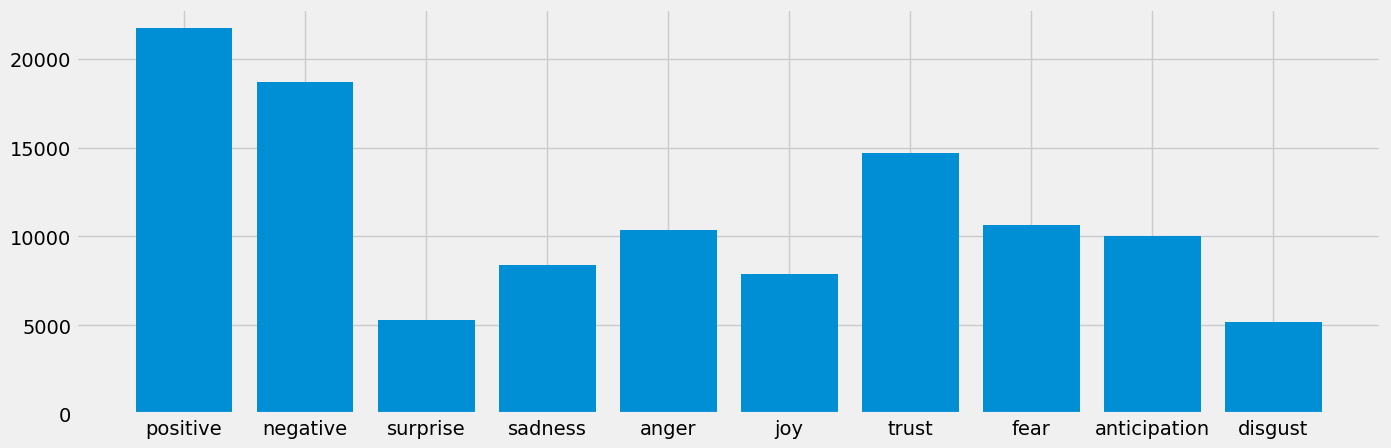

In [205]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,5]
plt.bar(list(emotions['BJP'].keys()),list(emotions['BJP'].values()))
plt.show()

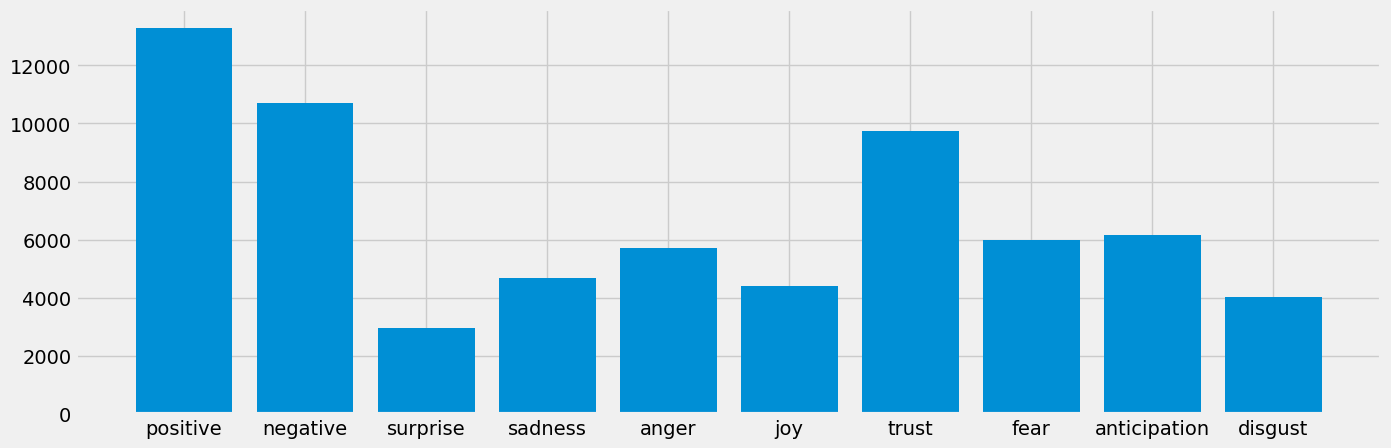

In [206]:
plt.bar(list(emotions['Congress'].keys()),list(emotions['Congress'].values()))
plt.rcParams["figure.figsize"] = [15,5]
plt.show()

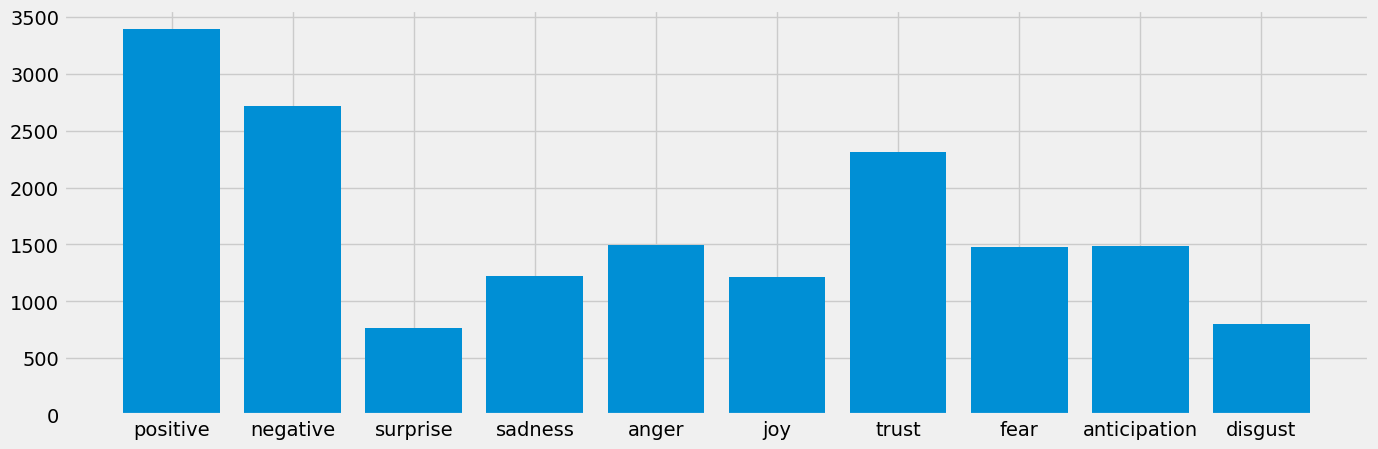

In [207]:
plt.bar(list(emotions['Other'].keys()),list(emotions['Other'].values()))
plt.rcParams["figure.figsize"] = [15,5]
plt.show()

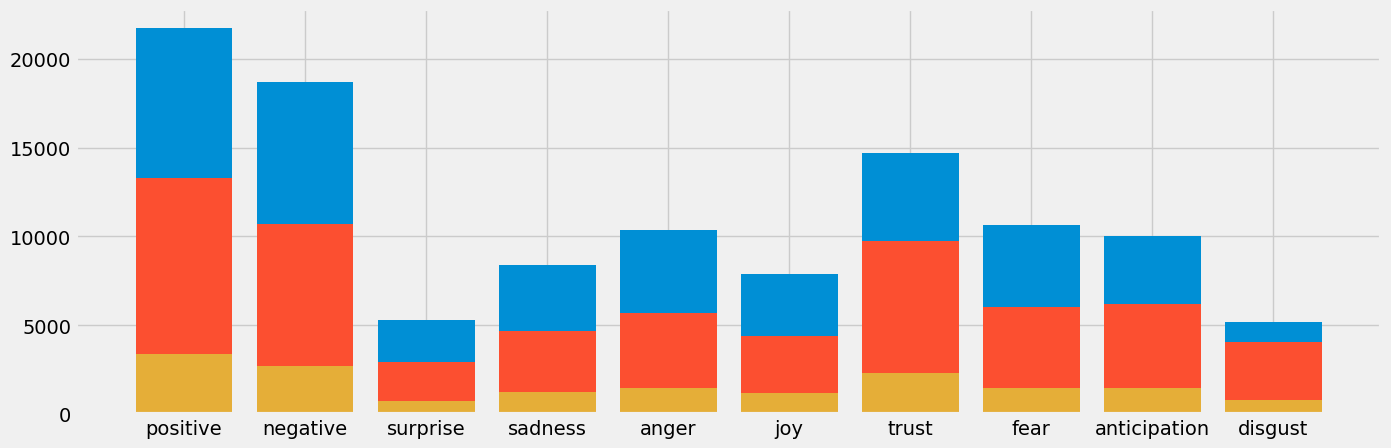

In [208]:
plt.rcParams["figure.figsize"] = [15,5]
for i in emotions:
    plt.bar(list(emotions[i].keys()),list(emotions[i].values()))  

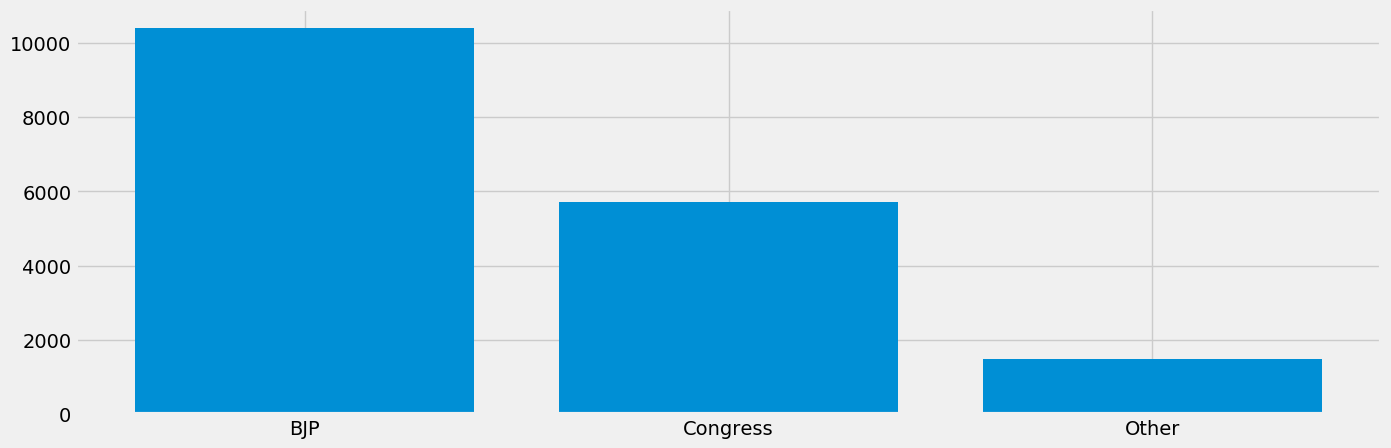

In [209]:
plt.bar(['BJP','Congress','Other'],[emotions['BJP']['anger'],emotions['Congress']['anger'],emotions['Other']['anger']])
plt.rcParams["figure.figsize"] = [15,5]

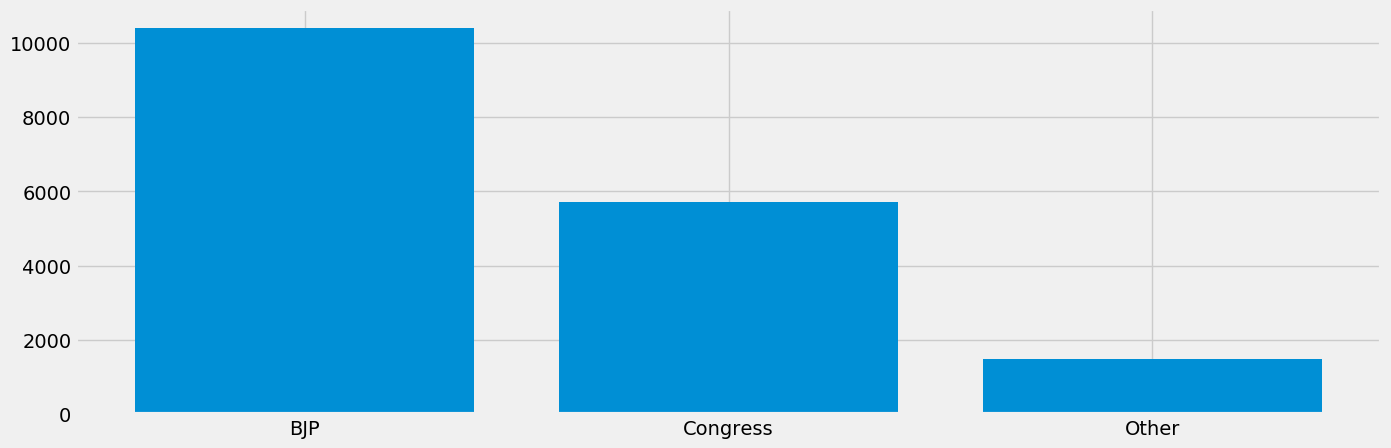

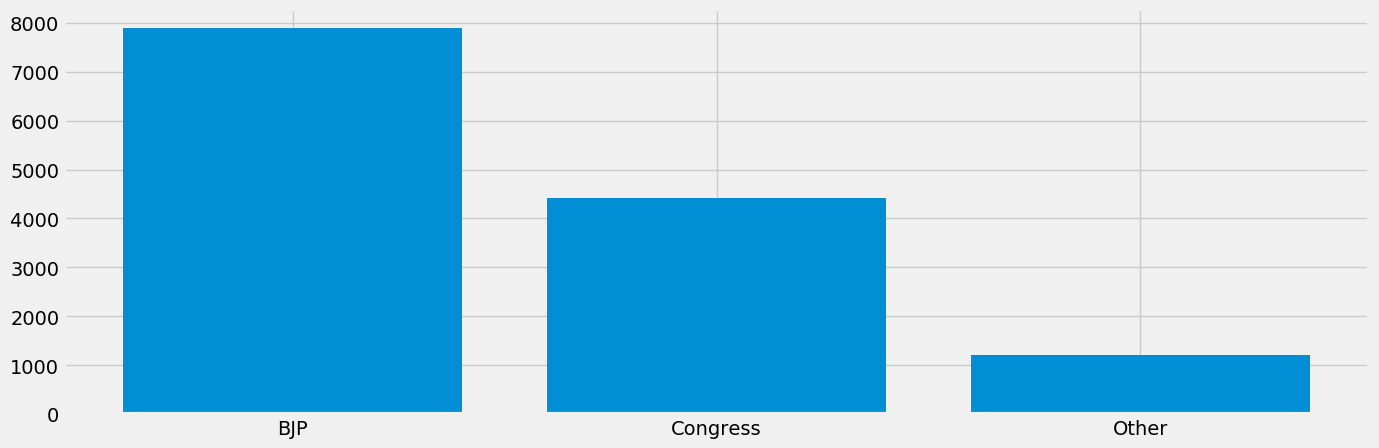

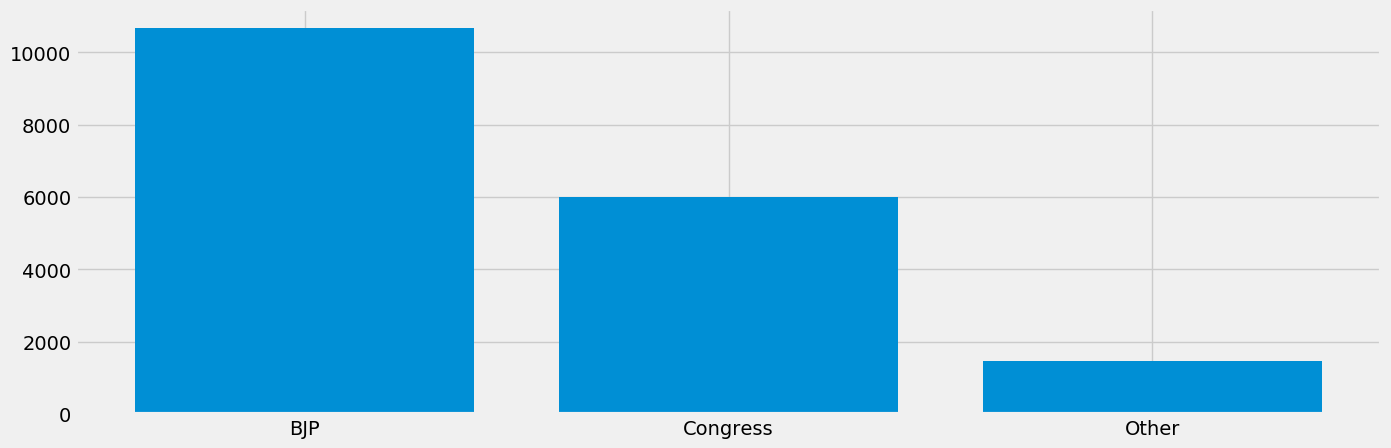

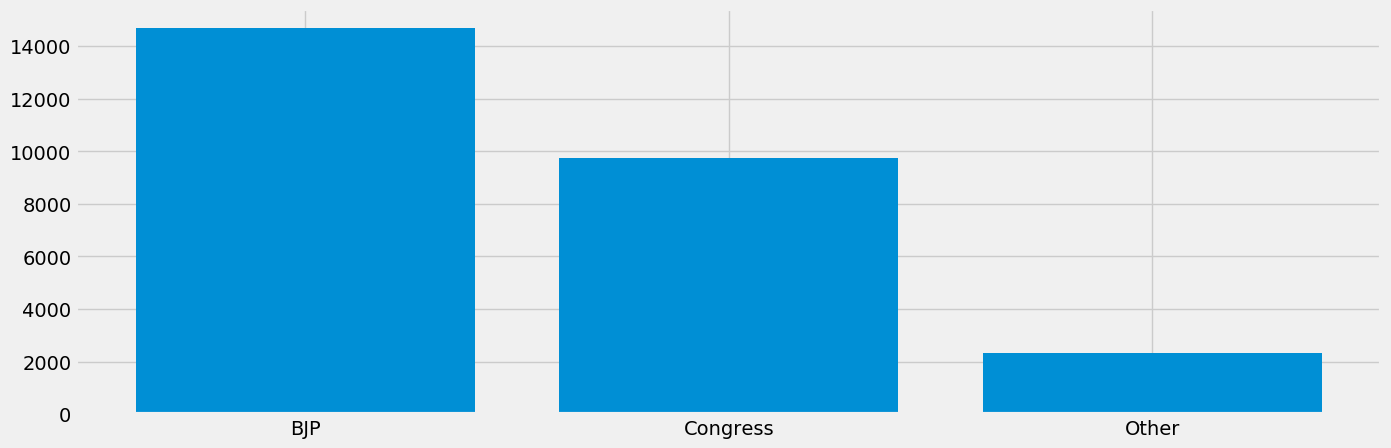

In [210]:
for i in ['anger','joy','fear','trust']:
    plt.bar(['BJP','Congress','Other'],[emotions['BJP'][i],emotions['Congress'][i],emotions['Other'][i]])
    plt.show()

In [211]:
most_state_count

{'Delhi': 4320,
 'Maharashtra': 2852,
 'Karnataka': 1587,
 'Uttar Pradesh': 975,
 'Tamil Nadu': 946,
 'Gujarat': 742,
 'Andhra Pradesh': 730,
 'West Bengal': 509,
 'Jammu & Kashmir': 361,
 'Haryana': 319,
 'Madhya Pradesh': 318,
 'Punjab': 266,
 'Rajasthan': 250,
 'Assam': 248,
 'Bihar': 214,
 'Chandigarh': 152}

In [212]:
state_mood=dict()
for i in list(most_state_count.keys()):
    state_mood[i]={'positive':0, 'negative':0, 'surprise':0,'sadness':0,'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}

In [213]:
for i in range(0,39874):
    party=df['State'][i]
    text=df['full_text'][i]
    if party not in list(most_state_count.keys()):
        continue
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                state_mood[party][k]+=word_emotion[j][k]


In [214]:
state_mood

{'Delhi': {'positive': 4343,
  'negative': 3453,
  'surprise': 918,
  'sadness': 1495,
  'anger': 1941,
  'joy': 1422,
  'trust': 2812,
  'fear': 1983,
  'anticipation': 1889,
  'disgust': 968},
 'Maharashtra': {'positive': 2759,
  'negative': 2302,
  'surprise': 649,
  'sadness': 1023,
  'anger': 1269,
  'joy': 1012,
  'trust': 1931,
  'fear': 1321,
  'anticipation': 1305,
  'disgust': 686},
 'Karnataka': {'positive': 1643,
  'negative': 1390,
  'surprise': 381,
  'sadness': 615,
  'anger': 770,
  'joy': 595,
  'trust': 1154,
  'fear': 767,
  'anticipation': 778,
  'disgust': 432},
 'Uttar Pradesh': {'positive': 884,
  'negative': 728,
  'surprise': 221,
  'sadness': 351,
  'anger': 430,
  'joy': 313,
  'trust': 590,
  'fear': 400,
  'anticipation': 404,
  'disgust': 204},
 'Tamil Nadu': {'positive': 935,
  'negative': 676,
  'surprise': 206,
  'sadness': 305,
  'anger': 363,
  'joy': 315,
  'trust': 634,
  'fear': 393,
  'anticipation': 381,
  'disgust': 190},
 'Gujarat': {'positive'

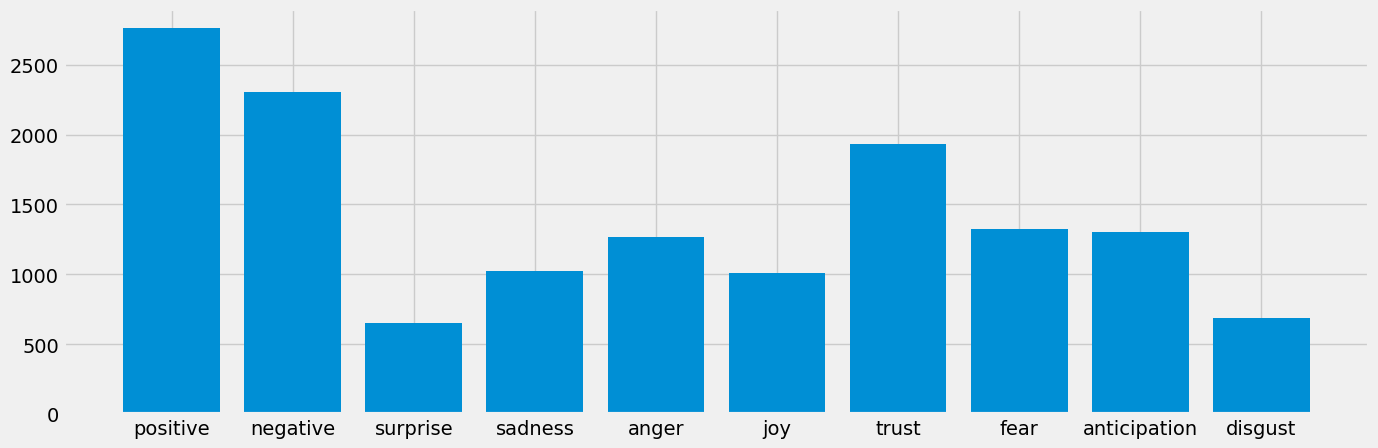

In [215]:
plt.bar(list(state_mood['Maharashtra'].keys()),list(state_mood['Maharashtra'].values()))
plt.rcParams["figure.figsize"] = [15,5]
plt.show()

In [216]:
map_df1.tail()

ID_0  ISO NAME_0  ID_1         NAME_1 TYPE_1 ENGTYPE_1 NL_NAME_1  \
31   105  IND  India    32      Telangana  State     State      None   
32   105  IND  India    33        Tripura  State     State      None   
33   105  IND  India    34  Uttar Pradesh  State     State      None   
34   105  IND  India    35    Uttaranchal  State     State      None   
35   105  IND  India    36    West Bengal  State     State      None   

                                            VARNAME_1  \
31                                               None   
32                                               None   
33                                   United Provinces   
34                                        Uttarakhand   
35  Bangla|Bengala Occidentale|Bengala Ocidental|B...   

                                             geometry  
31  POLYGON ((78.33625030517595 19.8831901550293, ...  
32  POLYGON ((92.18519592285179 24.52287292480469,...  
33  POLYGON ((77.58467864990263 30.4087810516358, ...  
34  POLYGON ((79.19477844238281 31.35362243652355,...  
35  (POLYGON ((88.01860809326178 21.57277870178234...

In [217]:
geo=[]
for i in list(most_state_count.keys()):
   for j in range(0,36):
       name1 = i
       name2 = map_df1["NAME_1"][j]
       if(name1==name2):
           geo.append(map_df1["geometry"][j])
           break
       elif len(set(name1.split()).intersection(set(name2.split())))>1:
           geo.append(map_df1["geometry"][j])
           break
       elif name2=="Puducherry" and name1 == "Pondicherry":
           geo.append(map_df1["geometry"][j])
           break

In [218]:
emo_dict={'positive':[],'negative':[],'anger':[],'joy':[],'trust':[],'sadness':[],'surprise':[],'fear':[],'anticipation':[],'disgust':[]}
for state in state_mood:
    for mood in state_mood[state]:
        emo_dict[mood].append(state_mood[state][mood])

In [219]:
state_df=pd.DataFrame({'State':list(most_state_count.keys()),'Geo':geo,'positive':emo_dict['positive'],'negative':emo_dict['negative'],'anger':emo_dict['anger'],'joy':emo_dict['joy'],'trust':emo_dict['trust'],'sadness':emo_dict['sadness'],'surprise':emo_dict['surprise'],'fear':emo_dict['fear'],'anticipation':emo_dict['anticipation'],'disgust':emo_dict['disgust']})


In [220]:
state_df.head()

State                                                Geo  positive  \
0          Delhi  POLYGON ((77.32713317871099 28.68515968322754,...      4343   
1    Maharashtra  (POLYGON ((73.45597076416021 15.88986206054688...      2759   
2      Karnataka  (POLYGON ((74.67097473144554 13.19986152648931...      1643   
3  Uttar Pradesh  POLYGON ((77.58467864990263 30.4087810516358, ...       884   
4     Tamil Nadu  (POLYGON ((77.55596160888689 8.079030990600586...       935   

   negative  anger   joy  trust  sadness  surprise  fear  anticipation  \
0      3453   1941  1422   2812     1495       918  1983          1889   
1      2302   1269  1012   1931     1023       649  1321          1305   
2      1390    770   595   1154      615       381   767           778   
3       728    430   313    590      351       221   400           404   
4       676    363   315    634      305       206   393           381   

   disgust  
0      968  
1      686  
2      432  
3      204  
4      190

In [221]:
geo_state=gpd.GeoDataFrame(state_df,geometry='Geo')

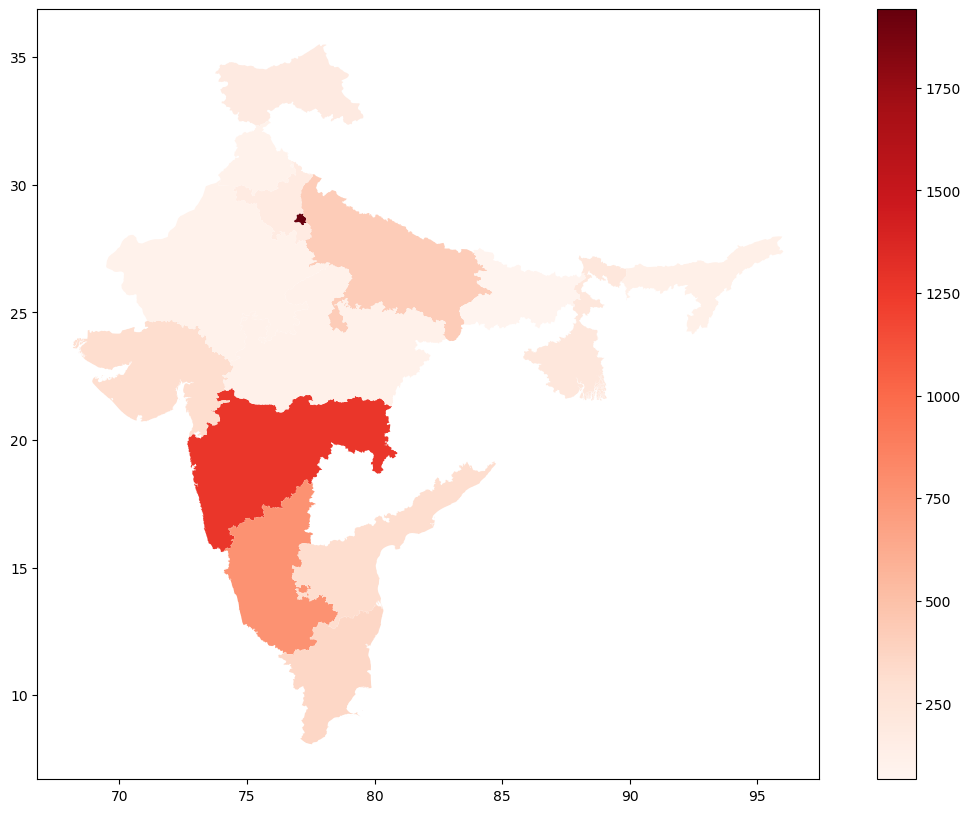

In [222]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
geo_state.plot(column='anger',legend=True,cmap='Reds')

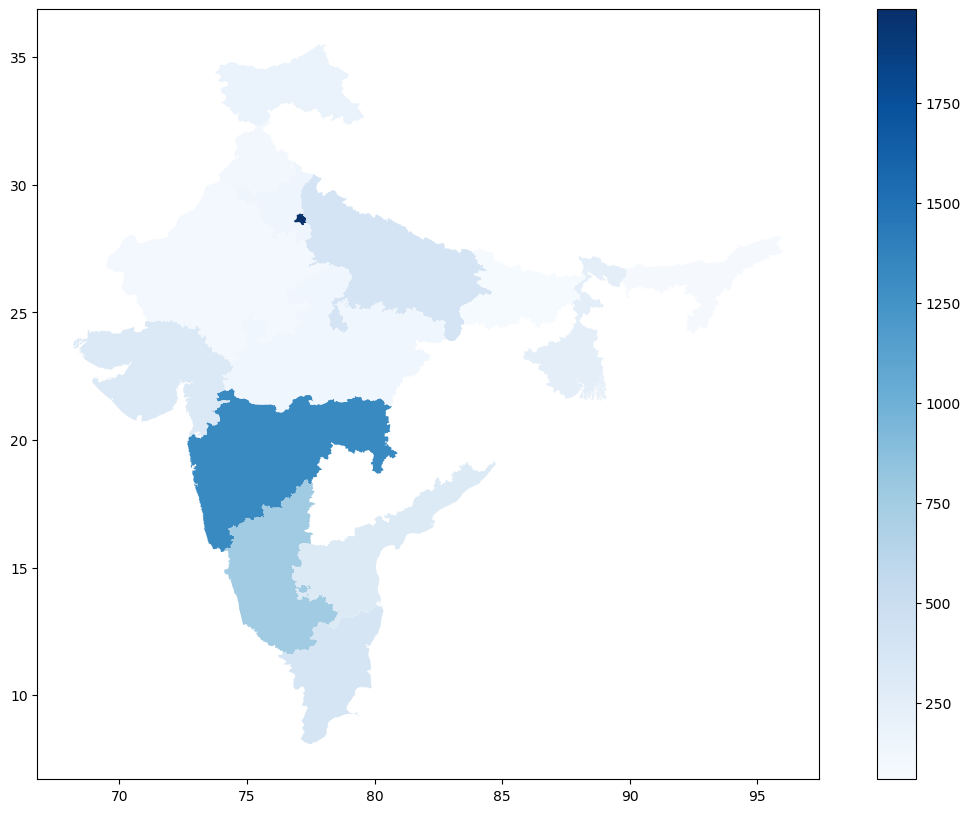

In [223]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
geo_state.plot(column='fear',legend=True,cmap='Blues')

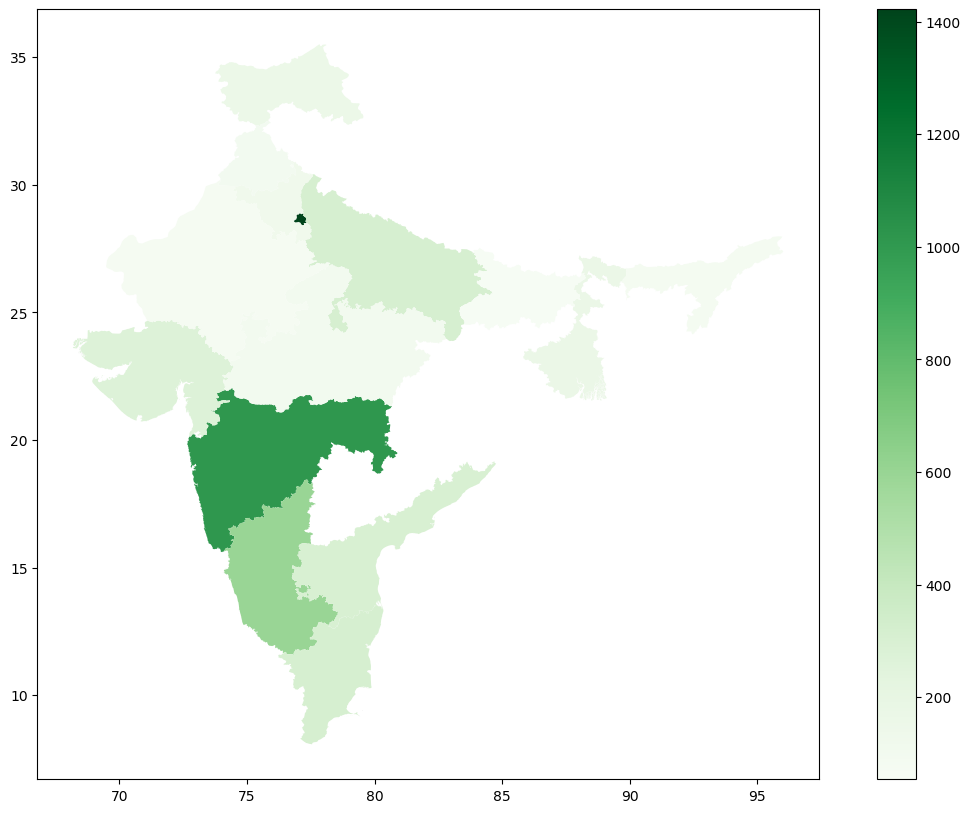

In [224]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
geo_state.plot(column='joy',legend=True,cmap='Greens')

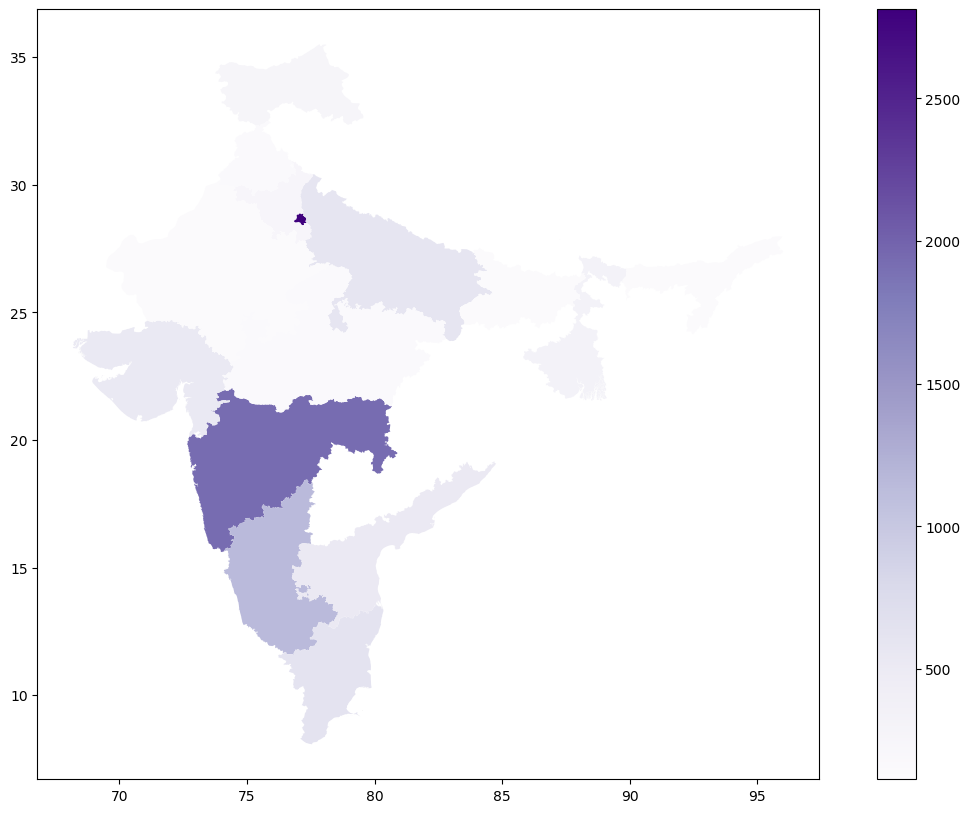

In [225]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
geo_state.plot(column='trust',legend=True,cmap='Purples')

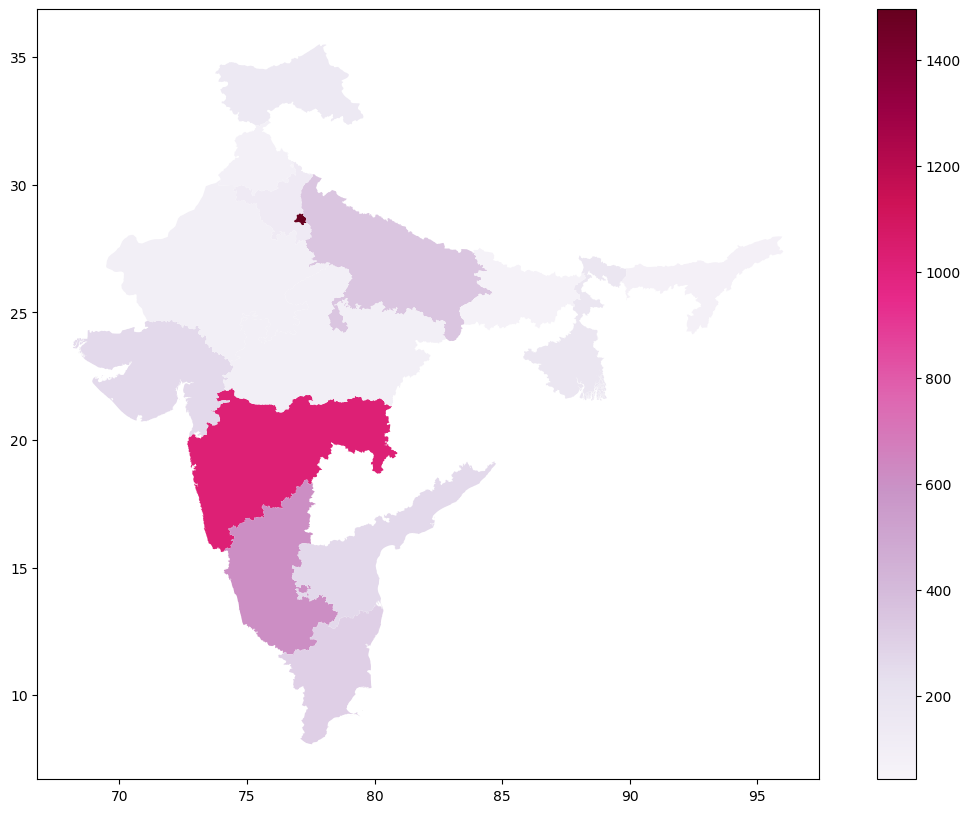

In [226]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
geo_state.plot(column='sadness',legend=True,cmap='PuRd')

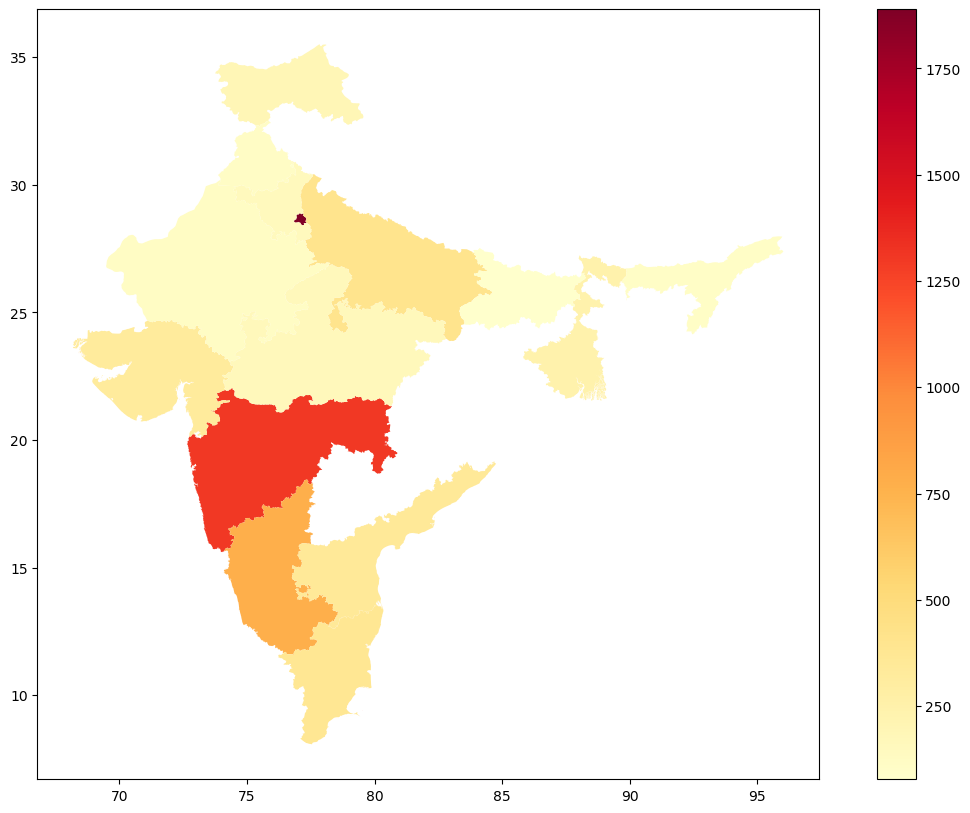

In [227]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
geo_state.plot(column='anticipation',legend=True,cmap='YlOrRd')

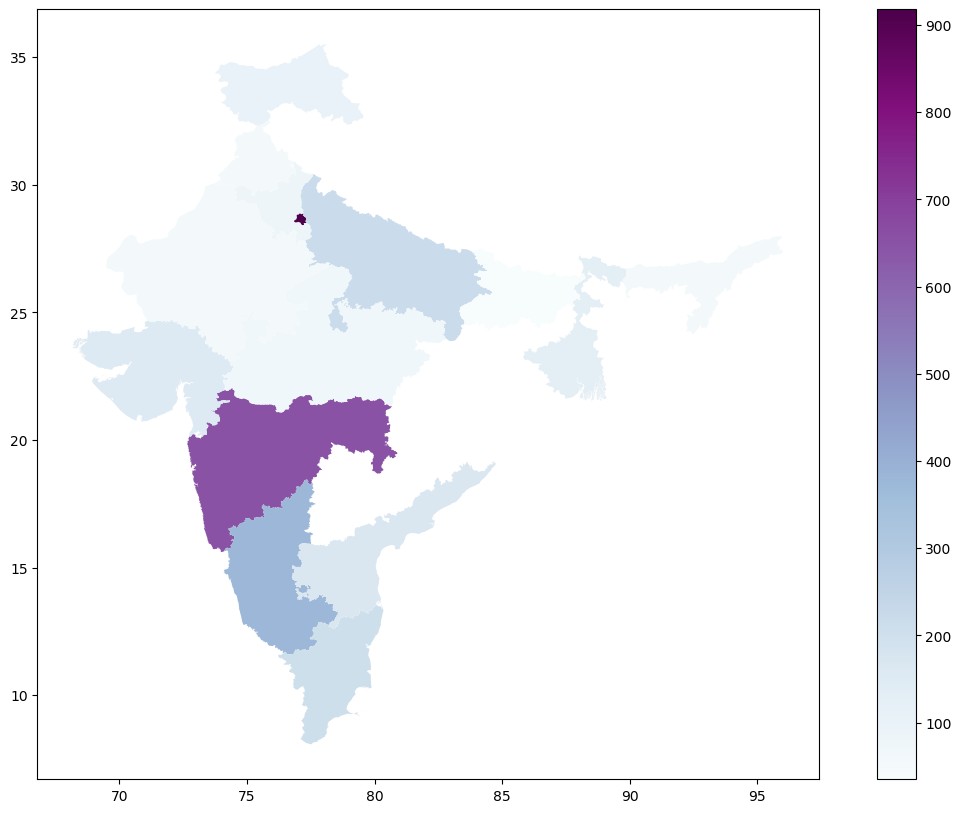

In [228]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
geo_state.plot(column='surprise',legend=True,cmap='BuPu')

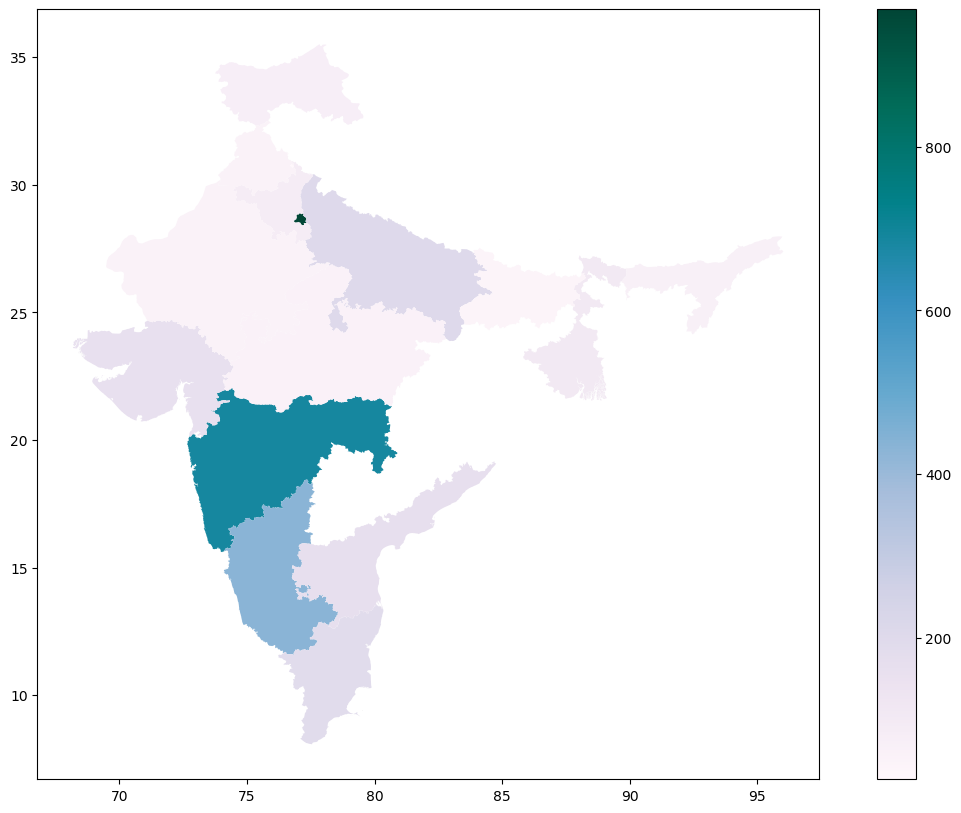

In [229]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = [15,10]
geo_state.plot(column='disgust',legend=True,cmap='PuBuGn')

In [230]:
end_time = time.time()
print("Total Execution Time: ",int((end_time-start_time)/60),"min", (int(end_time)-int(start_time))%60,"s")

Total Execution Time:  72 min 27 s


# Hypothesis Testing and Confidence Intervals

## We will be testing to see if BJP Tweets are scored above 25 at 95% Confidence Level

### H0 : Score <= 25
### H1 : Score > 25

In [231]:
dfhtest = df[df["Party"]=="BJP"][::300]

In [232]:
dfhtest = dfhtest.reset_index()
dfhtest.drop("index", axis=1, inplace = True)

In [233]:
dfhtest.shape

(75, 21)

In [234]:
x = dfhtest["Score"]
min1 = min(x)
max1 = max(x)
norm = lambda x : (x-min1)/(max1-min1)

In [235]:
x_norm = [norm(i) for i in x]

In [262]:
#plt.plot([i for i in range(len(x_norm))],x_norm)

In [237]:
y = df["Score"]
min1 = min(y)
max1 = max(y)
norm = lambda x : (x-min1)/(max1-min1)
y_norm = [norm(i) for i in y]

Zalpha = 1.64
pmean = np.mean(y_norm)
smean = np.mean(x_norm)
psd = np.std(y_norm)
ssd = np.std(x_norm)
n = 75

z = (0.1-smean)/(psd/math.sqrt(n))

In [238]:
z

46.65344733180021

##### Since the calculated Z Score is greater than the critical value, it lies in the rejection region and hence H0 is rejected

## We will be testing to see if Other Party popularity is 0.05 at 95% Confidence Level

### H0 : Popularity = 0.05
### H1 : Popularity != 0.05

In [239]:
dfhtest = df[df["Party"]=="Other"][::100]

In [240]:
dfhtest.shape

(37, 21)

In [241]:
x = dfhtest["Positive"]
y = df["Positive"]
min1, max1 = min(x), max(x)
min2, max2 = min(y), max(y)
norm_x = lambda x : (x-min1)/(min1-max1)
norm_y = lambda x : (x-min2)/(min1-max2)
x_norm = [norm(i) for i in x]
y_norm = [norm(i) for i in y]
z = (0.05-np.mean(x_norm))/(np.std(y_norm)/math.sqrt(37))

In [242]:
z

-5.481359684836815

##### Since z < 1.64, it lies in the rejection region and hence null hypothesis is rejected

# Normal Probability Plot

In [243]:
dfhtest = df[df["Party"]=="Congress"]

In [244]:
dfhtest.tail()

last_updated      tweet_id          created_at  \
39861 2019-05-16 18:28:00  1.130000e+18 2019-05-16 13:47:00   
39868 2019-05-16 18:28:00  1.130000e+18 2019-05-16 11:43:00   
39869 2019-05-16 18:29:00  1.130000e+18 2019-05-16 14:55:00   
39870 2019-05-16 18:29:00  1.130000e+18 2019-05-15 13:15:00   
39871 2019-05-16 18:29:00  1.120000e+18 2019-04-26 14:10:00   

                                               full_text  \
39861  @OmarAbdullah Absolutely NOT. \nHe was a Natio...   
39868  This is way way way more important than what h...   
39869  A web page dedicated to tracking Rahul Gandhi'...   
39870  Itâ€™s time to end the forever wars. But in th...   
39871  The only phone number you need to reach any re...   

                                         processed_tweet     Party  \
39861  omarabdullah absolut not nationalist like s ni...  Congress   
39868  way way way import happen decad ago rahul gand...  Congress   
39869  web page dedic track rahul gandhi numer lie ma...  Congress   
39870  it s time end forev war white hous peopl got u...  Congress   
39871            phone number need reach repres congress  Congress   

       quote_count  reply_count  retweet_count  Importance  ...  Neutral  \
39861          1.0         18.0          280.0           1  ...    0.637   
39868          0.0          0.0           10.0           0  ...    0.661   
39869          0.0          1.0           18.0           0  ...    0.751   
39870        156.0        318.0        16017.0           1  ...    0.675   
39871          0.0          0.0           99.0           1  ...    0.625   

       Positive  Negative  Compound  hashtags user_mentions_screen_name City  \
39861     0.127     0.236   -0.4479                        OmarAbdullah        
39868     0.000     0.339   -0.8271                                            
39869     0.083     0.165   -0.3887                                            
39870     0.000     0.325   -0.8779                                            
39871     0.375     0.000    0.1027                                            

      State Country       Score  
39861         India   13.886478  
39868         India    0.456449  
39869         India    0.827280  
39870         India  734.494352  
39871         India    5.518849  

[5 rows x 21 columns]

In [245]:
dfhtest.shape

(13991, 21)

In [246]:
p = []
x = list(dfhtest["Positive"])
x = [i for i in x if i!=0.0]
x.sort()
l = len(x)
min1, max1 = min(x), max(x)
norm = lambda x : (x-min1)/(max1-min1)
x = [norm(i) for i in x]
pi = lambda i,n : (i-0.5)/n
n = len(x)
p = [pi(i,n) for i in range(1,l+1)]

In [247]:
Zscores = scipy.stats.zscore(p)

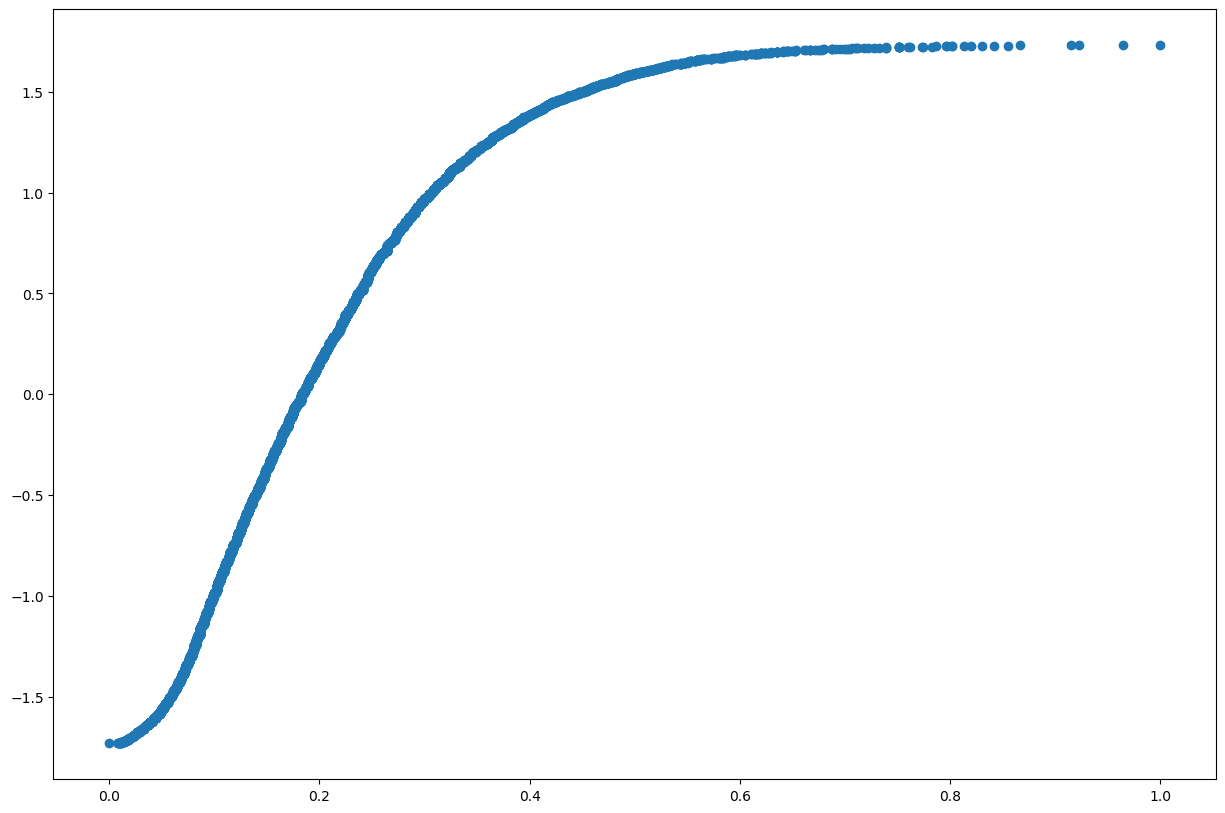

In [263]:
plt.scatter(x,Zscores)

# Chi Squared Test

### Testing Chi Squared Statistic for Polarity

In [249]:
dfchi = pd.DataFrame({"Positive":df["Positive"],"Negative":df["Negative"],"Neutral":df["Neutral"]})

In [250]:
dfchi.tail()

Positive  Negative  Neutral
39869     0.083     0.165    0.751
39870     0.000     0.325    0.675
39871     0.375     0.000    0.625
39872     0.345     0.155    0.500
39873     0.123     0.000    0.877

In [251]:
rowSum = dfchi.sum(axis = 1, skipna = True) 
colSumPos = sum(dfchi["Positive"])
colSumNeu = sum(dfchi["Neutral"])
colSumNeg = sum(dfchi["Negative"])
total = 39874

In [252]:
f_expected_pos = colSumPos/total
f_expected_neu = colSumNeu/total
f_expected_neg = colSumNeg/total

In [253]:
chi = scipy.stats.chisquare(dfchi["Positive"],[f_expected_pos for i in range(0,39874)])

In [255]:
chi

Power_divergenceResult(statistic=6084.588177009764, pvalue=1.0)

In [256]:
chi2 = 0
for i in range(0,39874):
    chi2 += ((dfchi["Positive"][i]-f_expected_pos)**2)/f_expected_pos
    chi2 += ((dfchi["Negative"][i]-f_expected_neg)**2)/f_expected_neg
    chi2 += ((dfchi["Neutral"][i]-f_expected_neu)**2)/f_expected_neu

In [257]:
chi2

14376.683953098189

In [258]:
p = scipy.stats.chi2.cdf(chi2,(39873*2))

In [259]:
p

0.0

In [260]:
chitest = dfchi.values
chi2 = scipy.stats.chi2_contingency(chitest)

In [261]:
chi2

(14376.667083825329, 1.0, 79746, array([[0.10430654, 0.09696888, 0.79872457],
        [0.10430654, 0.09696888, 0.79872457],
        [0.10430654, 0.09696888, 0.79872457],
        ...,
        [0.10430654, 0.09696888, 0.79872457],
        [0.10430654, 0.09696888, 0.79872457],
        [0.10430654, 0.09696888, 0.79872457]]))

##### Since p < 0.1, we reject the null hypothesis which states that there is no relation between the three columns